In [ ]:
!pip install --user colour-science
!pip install rdkit-pypi
!pip install colormath
!pip install colour
!pip install pymatgen

In [ ]:
# importing necessary libraries

from itertools import product
import pandas as pd
import pandas as pd
import numpy as np
from numpy import array, linspace
from numpy.random import randint
from matplotlib.pyplot import hist, xticks, show, yticks, savefig
from matplotlib.pyplot import figure
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import itertools
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy import stats
from colour import Color
import ast
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from pymatgen.core import Structure
from pymatgen.util.plotting import pretty_plot
import pickle
from pymatgen.analysis.xas.spectrum import XAS
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy import signal

In [ ]:
# load the in_house and literature datasets

data_lit = pd.read_csv(
    '/content/literature_only_dataset_with_abs_all_analysis.csv'
)
data_inhouse = pd.read_csv(
    '/content/in_house_dataset_with_abs_all_analysis.csv'
)
data_inhouse = data_inhouse.rename(
    columns={
        'smiles1': 'smiles_A',
        'smiles2': 'smiles_B',
        'smiles3': 'smiles_C',
        'percentage_1': 'Percentage of A %',
        'percentage_2': 'Percentage of B %',
        'percentage_3': 'Percentage of C %',
        'L': 'L* (Colored State)',
        'a': 'a* (Colored State)',
        'b': 'b*(Colored State)',
    }
)

data_inhouse['peak_loc3'] = np.zeros(data_inhouse.shape[0])
data_inhouse['HWHM3'] = np.zeros(data_inhouse.shape[0])
data_inhouse['intensities3'] = np.zeros(data_inhouse.shape[0])

In [ ]:
data_inhouse.columns.values

array(['source', 'polymer_id', 'monomer_A ', 'smiles_A',
       'Percentage of A %', 'monomer_B', 'smiles_B', 'Percentage of B %',
       'monomer_C', 'smiles_C', 'Percentage of C %', 'ratios',
       'num_monomers', 'L* (Colored State)', 'a* (Colored State)',
       'b*(Colored State)', 'wavelength', 'intensity', 'peak_location',
       'HWHM', 'intensities', 'peak_loc1', 'peak_loc2', 'HWHM1', 'HWHM2',
       'intensities1', 'intensities2', 'peak_loc3', 'HWHM3',
       'intensities3'], dtype=object)

# Abs properties calcualtion

In [ ]:
inhouse_abs = pd.read_csv(
    "/content/literature_only_dataset_with_abs_corrected.csv"
)
inhouse_abs.head(5)

source polymer_id  \
0    Adv. Mater., 20, 2772-2776, 2008  Polymer_A   
1    Adv. Mater., 20, 2772-2776, 2008  Polymer_B   
2  Nature Materials, 2008, 7, 795–799         P1   
3  Nature Materials, 2008, 7, 795–799         P2   
4  Nature Materials, 2008, 7, 795–799         P3   

                                          monomer_A   \
0  3,3-bis(octyloxymethyl)-3,4-dihydro-2Hthieno[3...   
1  3,3-bis(octyloxymethyl)-3,4-dihydro-2Hthieno[3...   
2   3,4-bis(2-ethylhexyloxy)thiophene (DOT-(OEtHx)2)   
3   3,4-bis(2-ethylhexyloxy)thiophene (DOT-(OEtHx)2)   
4   3,4-bis(2-ethylhexyloxy)thiophene (DOT-(OEtHx)2)   

                                     smiles_A  Percentage of A %  \
0  *c1sc(*)c2OCC(COCCCCCCCC)(COCCCCCCCC)COc12               67.0   
1  *c1sc(*)c2OCC(COCCCCCCCC)(COCCCCCCCC)COc12               67.0   
2         *c1sc(*)c(OCC(CC)CCCC)c1OCC(CC)CCCC               67.0   
3         *c1sc(*)c(OCC(CC)CCCC)c1OCC(CC)CCCC               80.0   
4         *c1sc(*)c(OCC(CC)CCCC)c1OCC(CC)CCCC               86.0   

                                           monomer_B  \
0    4,7-Di(thiophen-2-yl)benzo[c][1,2,5]thiadiazole   
1  4,7-bis(2,3-dihydrothieno[3,4-b][1,4]dioxin5-y...   
2                        2,1,3-benzothiadiazole (BTD   
3                        2,1,3-benzothiadiazole (BTD   
4                        2,1,3-benzothiadiazole (BTD   

                                          smiles_B  Percentage of B %  \
0              *c4ccc(c2ccc(c1ccc(*)s1)c3nsnc23)s4               33.0   
1  *c5sc(c3ccc(c2sc(*)c1OCCOc12)c4nsnc34)c6OCCOc56               33.0   
2                                *c1ccc(*)c2nsnc12               33.0   
3                                *c1ccc(*)c2nsnc12               20.0   
4                                *c1ccc(*)c2nsnc12               14.0   

  monomer_C smiles_C  ...  ratios num_monomers  color L* (Colored State)  \
0         0        0  ...   67_33            2  green               59.0   
1         0        0  ...   67_33            2  green               66.0   
2         0        0  ...   67_33            2   blue               64.0   
3         0        0  ...   80_20            2   blue               57.0   
4         0        0  ...   86_14            2  black               52.0   

   a* (Colored State)  b*(Colored State)                         Link  Year  \
0               -29.0               -7.0  DOI: 10.1002/adma.200800280  2008   
1               -30.0               -4.0  DOI: 10.1002/adma.200800280  2008   
2               -37.0               -7.0         DOI:10.1038/nmat2272  2008   
3                 7.0               -7.0         DOI:10.1038/nmat2272  2008   
4                34.0                7.0         DOI:10.1038/nmat2272  2008   

                                          wavelength  \
0  [350.0, 351.0, 352.0, 353.0, 354.0, 355.0, 356...   
1  [350.0, 351.0, 352.0, 353.0, 354.0, 355.0, 356...   
2  [350.0, 351.0, 352.0, 353.0, 354.0, 355.0, 356...   
3  [350.0, 351.0, 352.0, 353.0, 354.0, 355.0, 356...   
4  [350.0, 351.0, 352.0, 353.0, 354.0, 355.0, 356...   

                                           intensity  
0  [0.21725298, 0.21725298, 0.21725298, 0.2172529...  
1  [0.0803381453, 0.0803381453, 0.0803381453, 0.0...  
2  [0.36196319, 0.36196319, 0.36196319, 0.3619631...  
3  [0.38271605, 0.38271605, 0.38271605, 0.3827160...  
4  [0.634146341, 0.634146341, 0.634146341, 0.6341...  

[5 rows x 21 columns]

In [ ]:
# peak_loc, peak_HWHM, intensities_list

inhouse_abs['peak_location'] = peak_loc
inhouse_abs['HWHM'] = peak_HWHM
inhouse_abs['intensities'] = intensities_list

In [ ]:
# Finding the maximum list length to determine the number of columns needed
max_len = inhouse_abs['peak_location'].apply(len).max()

# Expanding the 'Scores' list into separate columns, handling varying lengths
scores_df_var_length = pd.DataFrame(
    inhouse_abs['peak_location'].tolist(),
    columns=[f'peak_loc{i+1}' for i in range(max_len)],
)
scores_df_var_length = scores_df_var_length.fillna(0)


expanded_df_var_length = pd.concat([inhouse_abs, scores_df_var_length], axis=1)

# # Calculate the correlation matrix, including handling NaN values as needed
# correlation_matrix_var_length = expanded_df_var_length.corr()

# correlation_matrix_var_length
expanded_df_var_length

source polymer_id  \
0     Adv. Mater., 20, 2772-2776, 2008  Polymer_A   
1     Adv. Mater., 20, 2772-2776, 2008  Polymer_B   
2   Nature Materials, 2008, 7, 795–799         P1   
3   Nature Materials, 2008, 7, 795–799         P2   
4   Nature Materials, 2008, 7, 795–799         P3   
..                                 ...        ...   
81    Polym. Chem., 2018, 9, 5262-5267         P2   
82    Polym. Chem., 2018, 9, 5262-5267         P3   
83    Polym. Chem., 2018, 9, 5262-5267         P4   
84    Polym. Chem., 2018, 9, 5262-5267         P5   
85    Polym. Chem., 2018, 9, 5262-5267         P6   

                                           monomer_A   \
0   3,3-bis(octyloxymethyl)-3,4-dihydro-2Hthieno[3...   
1   3,3-bis(octyloxymethyl)-3,4-dihydro-2Hthieno[3...   
2    3,4-bis(2-ethylhexyloxy)thiophene (DOT-(OEtHx)2)   
3    3,4-bis(2-ethylhexyloxy)thiophene (DOT-(OEtHx)2)   
4    3,4-bis(2-ethylhexyloxy)thiophene (DOT-(OEtHx)2)   
..                                                ...   
81  3,3-Bis-(2-ethyl-hexyloxymethyl)-3,4-dihydro-2...   
82  3,3-Bis-(2-ethyl-hexyloxymethyl)-3,4-dihydro-2...   
83  3,3-Bis-(2-ethyl-hexyloxymethyl)-3,4-dihydro-2...   
84  3,3-Bis-(2-ethyl-hexyloxymethyl)-3,4-dihydro-2...   
85  3,3-Bis-(2-ethyl-hexyloxymethyl)-3,4-dihydro-2...   

                                          smiles_A  Percentage of A %  \
0       *c1sc(*)c2OCC(COCCCCCCCC)(COCCCCCCCC)COc12               67.0   
1       *c1sc(*)c2OCC(COCCCCCCCC)(COCCCCCCCC)COc12               67.0   
2              *c1sc(*)c(OCC(CC)CCCC)c1OCC(CC)CCCC               67.0   
3              *c1sc(*)c(OCC(CC)CCCC)c1OCC(CC)CCCC               80.0   
4              *c1sc(*)c(OCC(CC)CCCC)c1OCC(CC)CCCC               86.0   
..                                             ...                ...   
81  *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12               70.0   
82  *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12               67.5   
83  *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12               62.5   
84  *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12               57.5   
85  *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12               50.0   

                                            monomer_B  \
0     4,7-Di(thiophen-2-yl)benzo[c][1,2,5]thiadiazole   
1   4,7-bis(2,3-dihydrothieno[3,4-b][1,4]dioxin5-y...   
2                         2,1,3-benzothiadiazole (BTD   
3                         2,1,3-benzothiadiazole (BTD   
4                         2,1,3-benzothiadiazole (BTD   
..                                                ...   
81                       2,1,3-benzothiadiazole (BTD)   
82                       2,1,3-benzothiadiazole (BTD)   
83                       2,1,3-benzothiadiazole (BTD)   
84                       2,1,3-benzothiadiazole (BTD)   
85                       2,1,3-benzothiadiazole (BTD)   

                                           smiles_B  Percentage of B %  \
0               *c4ccc(c2ccc(c1ccc(*)s1)c3nsnc23)s4               33.0   
1   *c5sc(c3ccc(c2sc(*)c1OCCOc12)c4nsnc34)c6OCCOc56               33.0   
2                                 *c1ccc(*)c2nsnc12               33.0   
3                                 *c1ccc(*)c2nsnc12               20.0   
4                                 *c1ccc(*)c2nsnc12               14.0   
..                                              ...                ...   
81                                *c1ccc(*)c2nsnc12               15.0   
82                                *c1ccc(*)c2nsnc12               15.0   
83                                *c1ccc(*)c2nsnc12               17.5   
84                                *c1ccc(*)c2nsnc12               20.0   
85                                *c1ccc(*)c2nsnc12               25.0   

       monomer_C                   smiles_C  ...  \
0              0                          0  ...   
1              0                          0  ...   
2              0                          0  ...   
3              0                          0  ...   

In [ ]:
# Finding the maximum list length to determine the number of columns needed
max_len = inhouse_abs['HWHM'].apply(len).max()

# Expanding the 'Scores' list into separate columns, handling varying lengths
scores_df_var_length = pd.DataFrame(
    inhouse_abs['HWHM'].tolist(),
    columns=[f'HWHM{i+1}' for i in range(max_len)],
)
scores_df_var_length = scores_df_var_length.fillna(0)


expanded_df_var_length_1 = pd.concat(
    [expanded_df_var_length, scores_df_var_length], axis=1
)

# Calculate the correlation matrix, including handling NaN values as needed
# correlation_matrix_var_length = expanded_df_var_length.corr()

# correlation_matrix_var_length

In [ ]:
# Finding the maximum list length to determine the number of columns needed
max_len = inhouse_abs['intensities'].apply(len).max()

# Expanding the 'Scores' list into separate columns, handling varying lengths
scores_df_var_length = pd.DataFrame(
    inhouse_abs['intensities'].tolist(),
    columns=[f'intensities{i+1}' for i in range(max_len)],
)
scores_df_var_length = scores_df_var_length.fillna(0)


expanded_df_var_length_2 = pd.concat(
    [expanded_df_var_length_1, scores_df_var_length], axis=1
)

In [ ]:
expanded_df_var_length_2  # .to_csv('/content/literature_only_dataset_with_abs_all_analysis.csv', index=None)

In [ ]:
import ast

xaxis = inhouse_abs['wavelength'].values
intensity = inhouse_abs['intensity'].values


# wavelength = ast.literal_eval(xaxis[0])
# energy = ast.literal_eval(intensity[0])

In [ ]:
intensity = inhouse_abs['intensity'].values

In [ ]:
len(xaxis)
len(intensity)

68

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, find_peaks_cwt
import os

from scipy.signal import savgol_filter


def apply_savgol_filter(y, window_size, poly_order):
    """
    Apply a Savitzky-Golay filter to a 1D array.

    Parameters:
    y (array_like): The input signal.
    window_size (int): The size of the moving window. Must be odd.
    poly_order (int): The order of the polynomial used to fit the samples.

    Returns:
    numpy.ndarray: The smoothed signal.
    """
    return savgol_filter(y, window_size, poly_order)


def find_peaks_HWHM(x, y):
    """Find all the peaks in the spectrum and calculate their half width half maximum.



    Parameters:

    x (array_like): The x values of the spectrum.

    y (array_like): The y values of the spectrum.



    Returns:

    A tuple of two arrays:

    - peak_locs: The x locations of the peaks.

    - peak_HWHMs: The half width half maximum of the peaks.

    """

    # Find all the peaks in the spectrum

    # peaks, _ = find_peaks(y)

    # peaks = find_peaks_cwt(y, [5])
    y = apply_savgol_filter(y, window_size=80, poly_order=3)
    peaks, properties = find_peaks(y, prominence=0.01)

    # Calculate the half width half maximum of each peak

    peak_locs = np.array(x)[peaks]

    intensities = np.array(y)[peaks]

    peak_HWHMs = np.zeros_like(peak_locs)

    for i, peak_loc in enumerate(peak_locs):

        y_peak = y[peaks[i]]

        half_max = y_peak / 2

        left_idx = np.argmin(np.abs(np.array(y)[: peaks[i]] - half_max))

        right_idx = (
            np.argmin(np.abs(np.array(y)[peaks[i] :] - half_max)) + peaks[i]
        )

        peak_HWHMs[i] = x[right_idx] - x[left_idx]

    # Plot the data
    plt.plot(x, y, label='Spectrum')

    # Mark the peaks
    plt.scatter(peak_locs, intensities, color='red', zorder=5, label='Peaks')

    # Annotate the peaks with their wavelength and visualize HWHM
    for i, peak_loc in enumerate(peak_locs):
        # Annotate peak wavelength
        plt.annotate(
            f'{peak_loc} nm',
            (peak_loc, intensities[i]),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center',
        )

        # Visualize HWHM by drawing horizontal and vertical lines
        half_max = intensities[i] / 2
        hwhm_start = peak_loc - peak_HWHMs[i] / 2
        hwhm_end = peak_loc + peak_HWHMs[i] / 2

        # Draw HWHM lines
        plt.hlines(
            half_max,
            hwhm_start,
            hwhm_end,
            color='green',
            linestyles='dashed',
            label='HWHM' if i == 0 else "",
        )
        plt.vlines(
            [hwhm_start, hwhm_end],
            half_max - 0.05,
            half_max + 0.05,
            color='green',
            linestyles='dotted',
        )

    plt.legend()
    # plt.savefig('test_plot.svg')
    plt.show()

    return peak_locs, peak_HWHMs, intensities


def abs_max_intensity(wavelength, intensities):
    """

    For a given Absorption spectra detect the maximum peak in a given range



    Args:

        dataset : The saved absorption spectra

        range: The range in nm, in which we expect the absorption peak for our material

    """

    # intensities =dataset.intensities

    peaks = find_peaks_cwt(intensities, [5])

    return peaks  # properties['peak_heights']#.max()


def export_data(folder_name, file_name):

    filename = os.path.join(folder_name, file_name)

    data = pd.read_csv(filename, delimiter='\t')  # , asty)

    name = data.iloc[0, 1]

    x, y = (
        list(data.iloc[1:, 0].values)[::-1],
        [float(i) for i in data.iloc[1:, 1].values][::-1],
    )

    peak_locs, peak_HWHMs, intensities = find_peaks_HWHM(x, y)

    indexes_1 = np.where(peak_locs > 420)

    indexes_2 = np.where(intensities > 0.15)

    is_in_array2 = np.isin(indexes_1, indexes_2)

    common_elements = set(np.array(indexes_1)[is_in_array2])

    ind = np.array(peak_locs)[list(common_elements)]

    ind_1 = np.array(intensities)[list(common_elements)]

    ind_2 = np.array(peak_HWHMs)[list(common_elements)]

    return ind, ind_1, ind_2, name

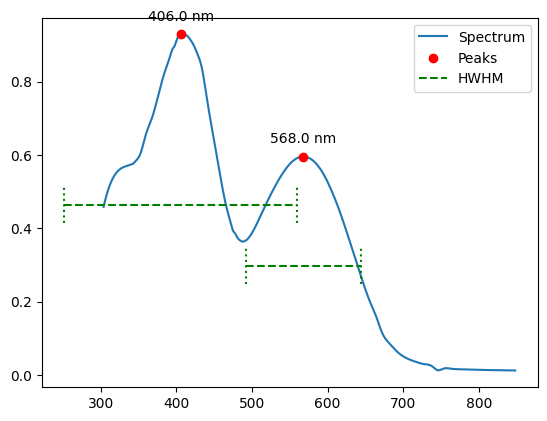

(array([406., 568.]), array([308., 152.]), array([0.92838135, 0.59556591]))

In [ ]:
wavelength = ast.literal_eval(xaxis[85])
energy = ast.literal_eval(intensity[85])
find_peaks_HWHM(wavelength, energy)
# fwhm

0


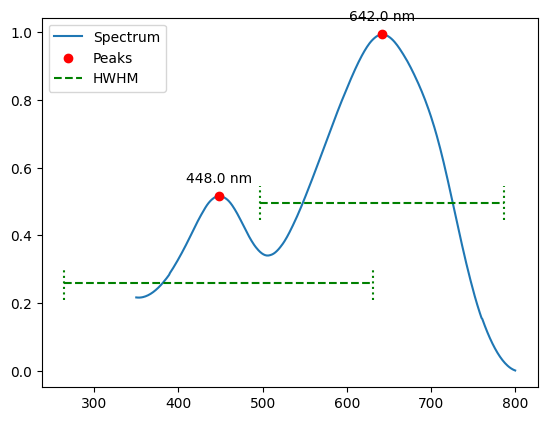

1


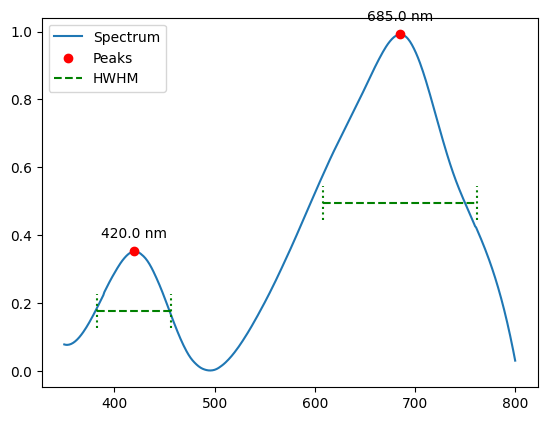

2


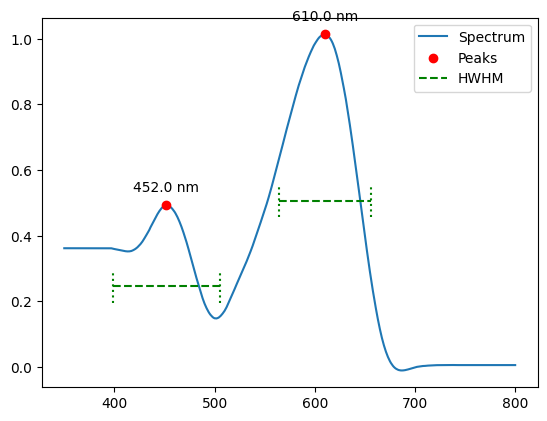

3


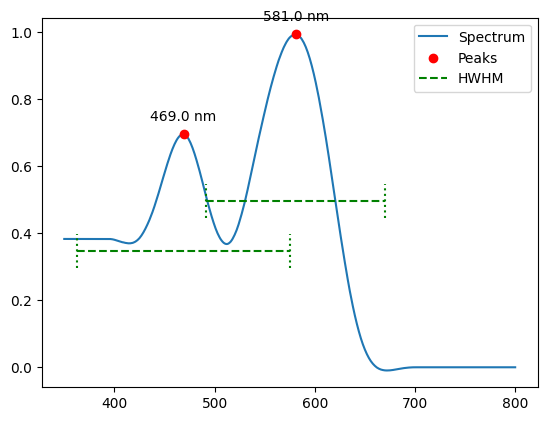

4


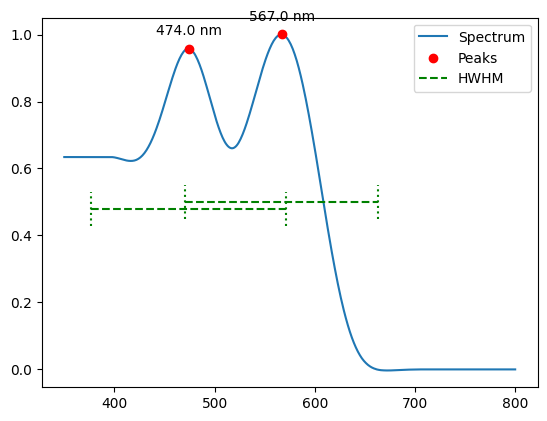

5


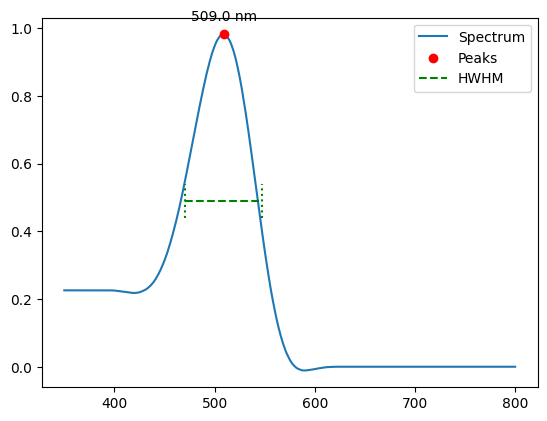

6


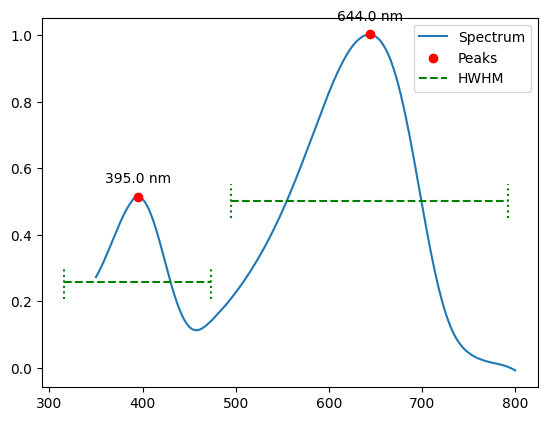

7


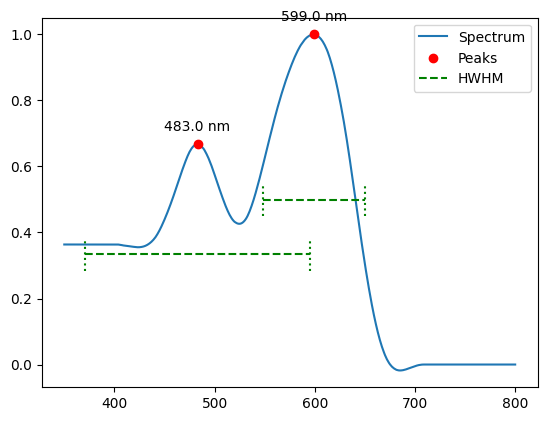

8


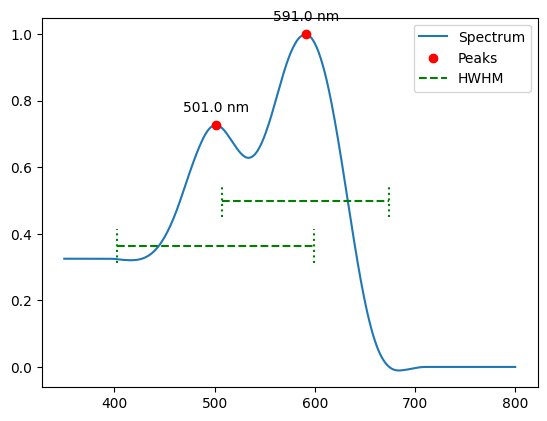

9


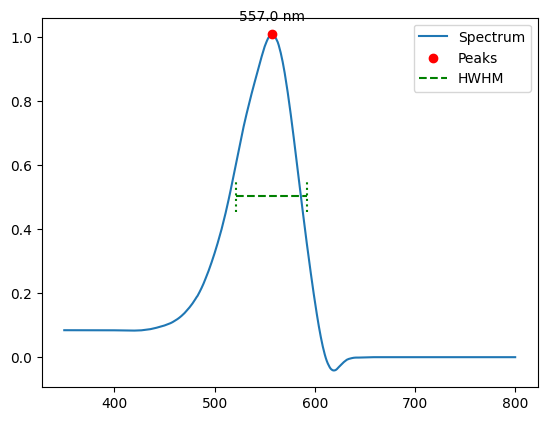

10


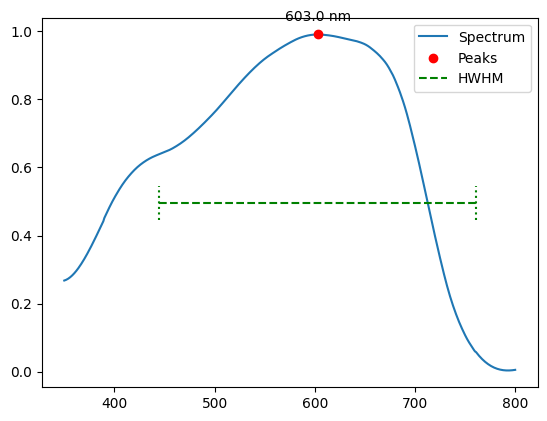

11


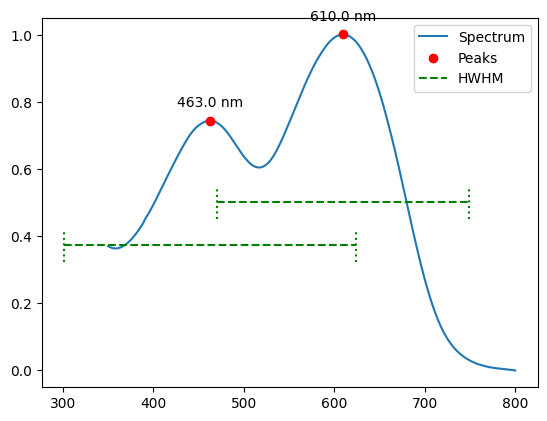

12


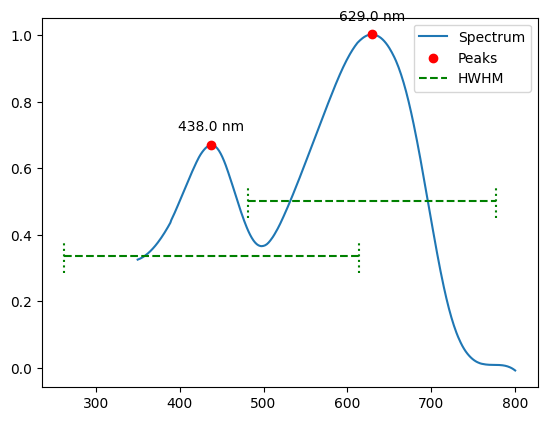

13


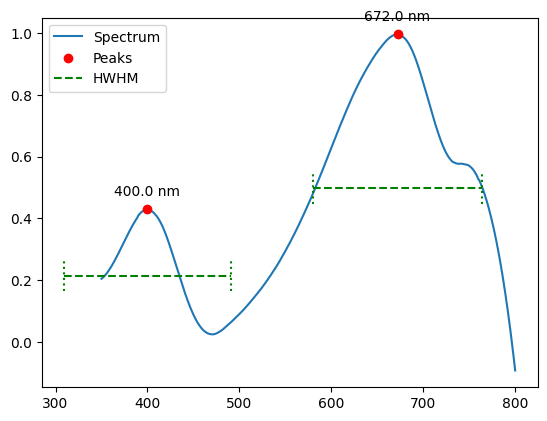

14


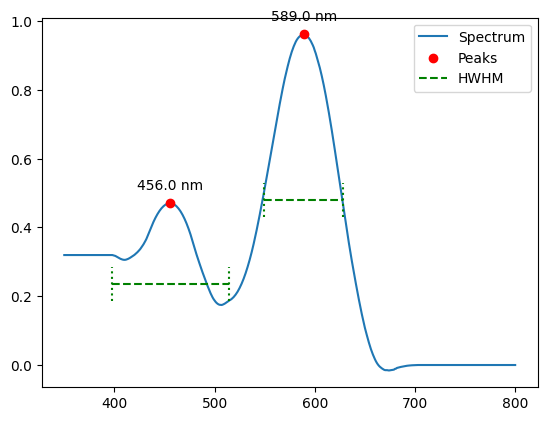

15


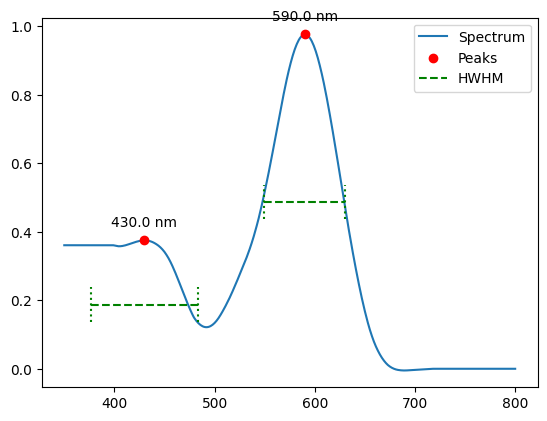

16


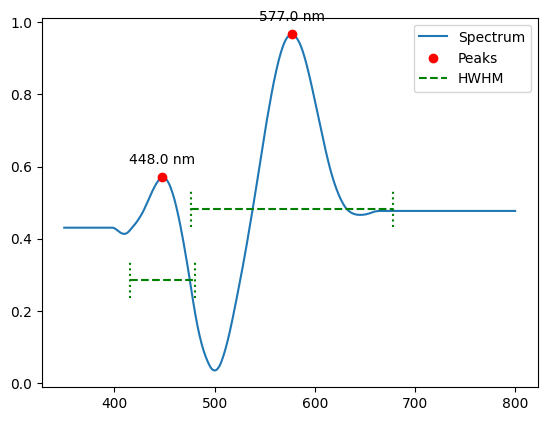

17


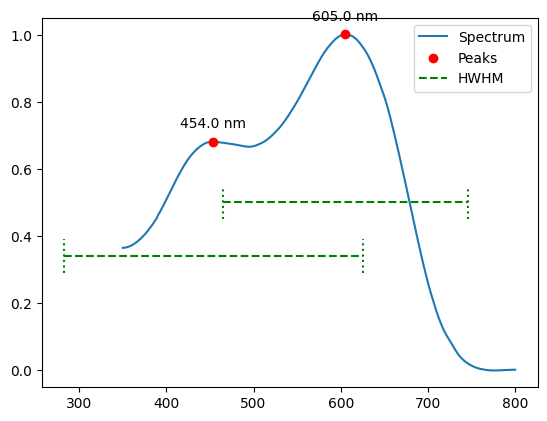

18


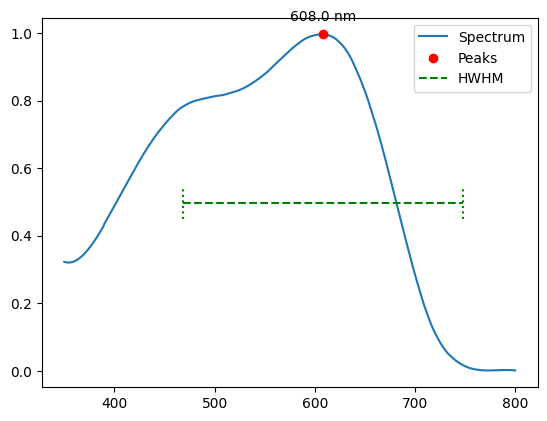

19


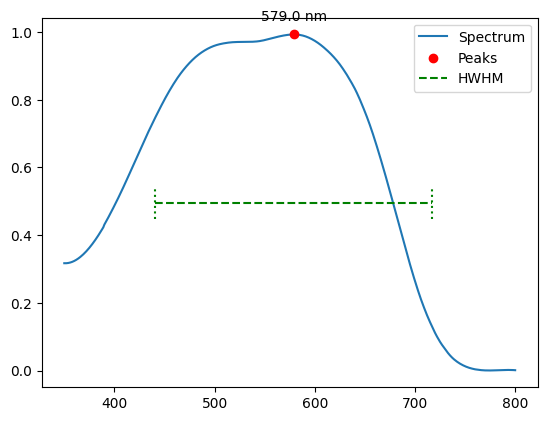

20


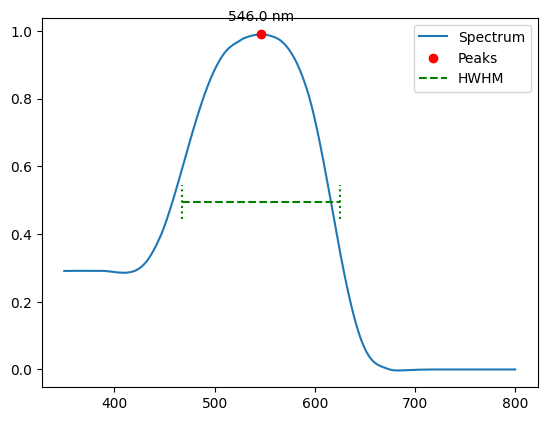

21


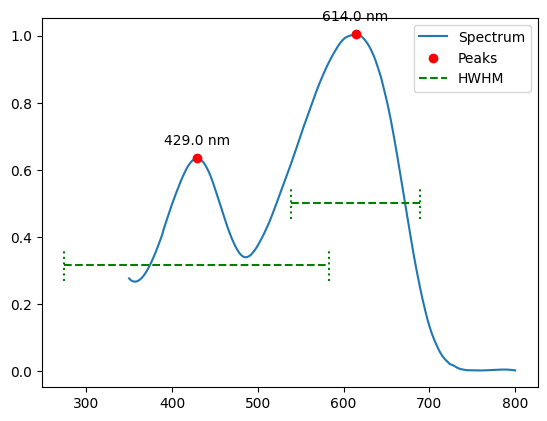

22


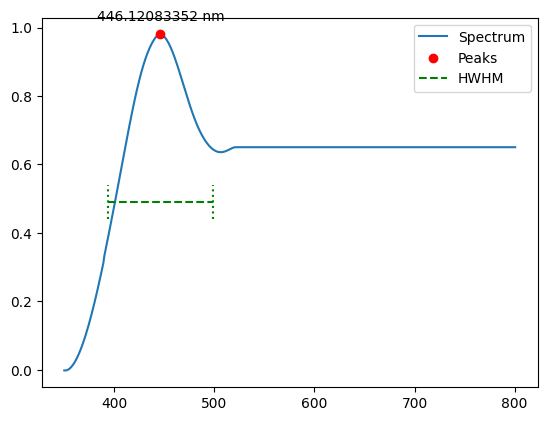

23


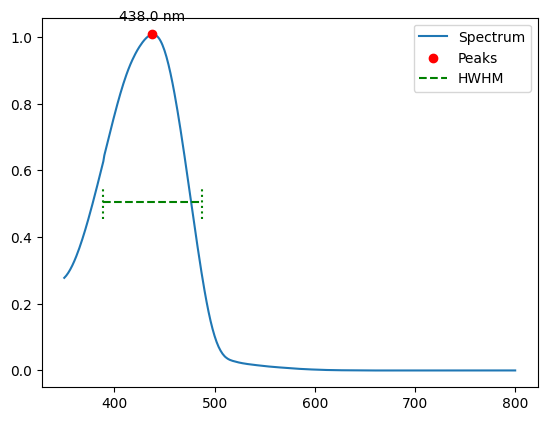

24


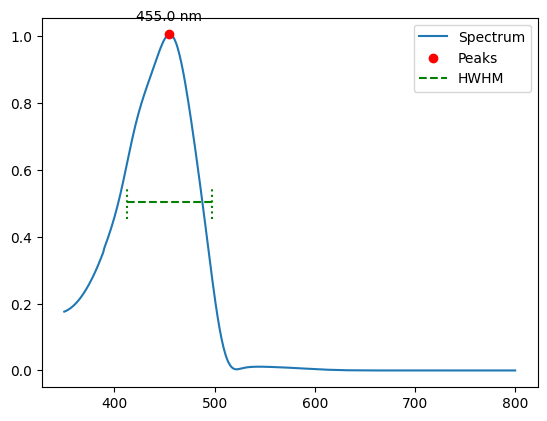

25


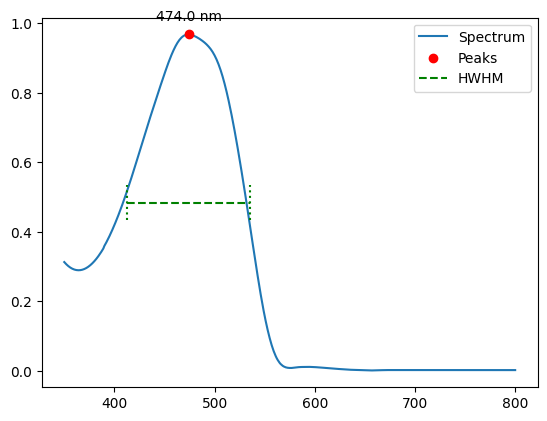

26


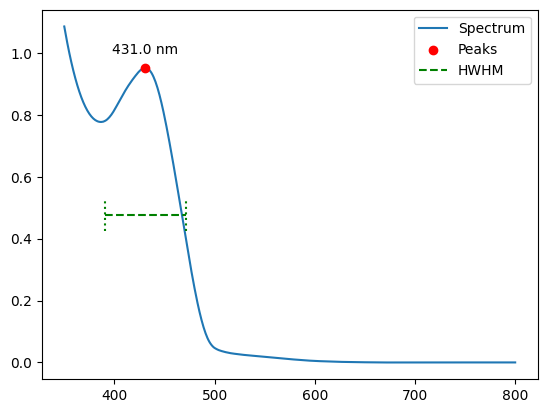

27


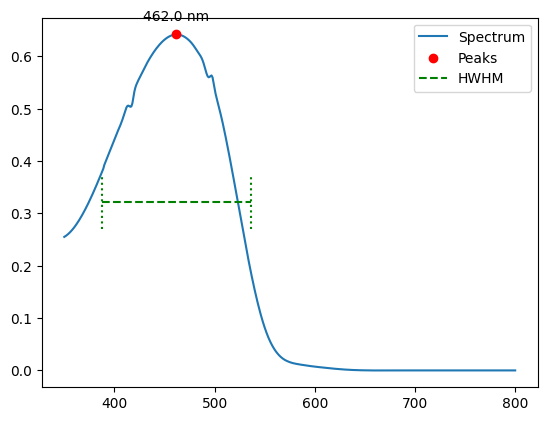

28


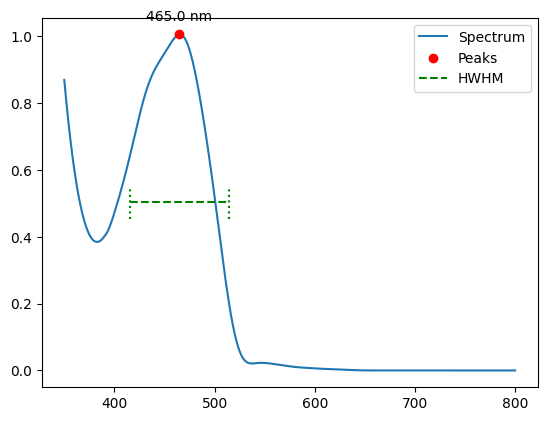

29


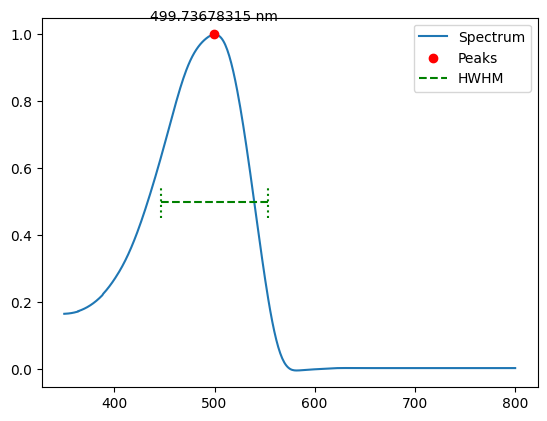

30


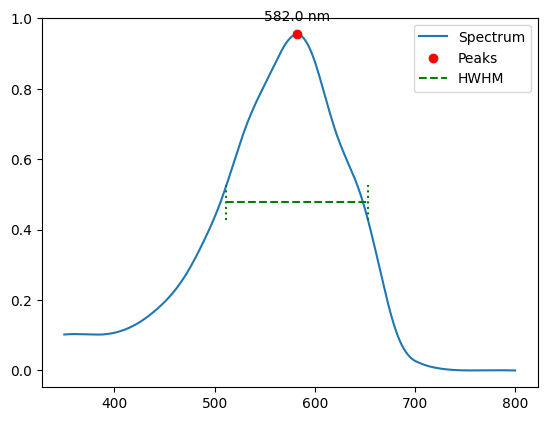

31


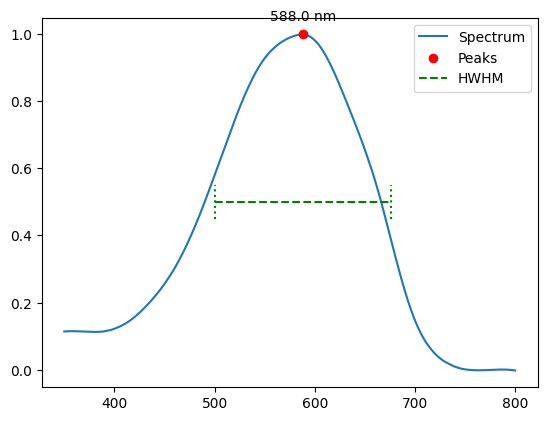

32


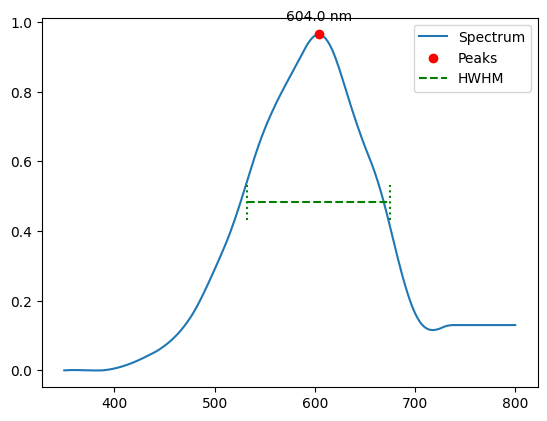

33


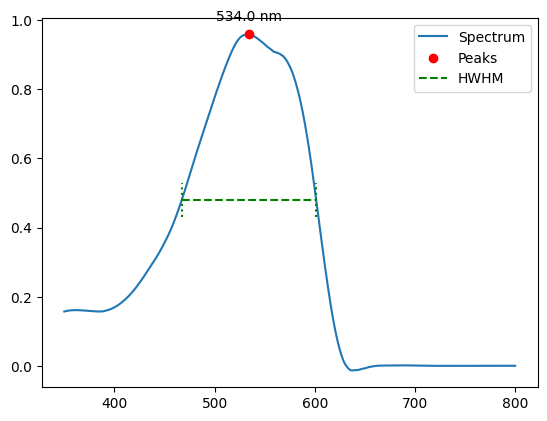

34


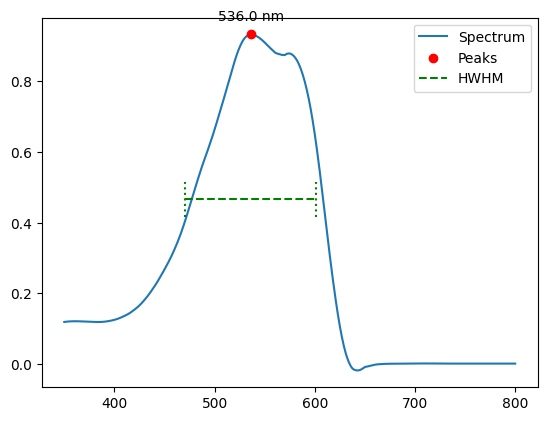

35


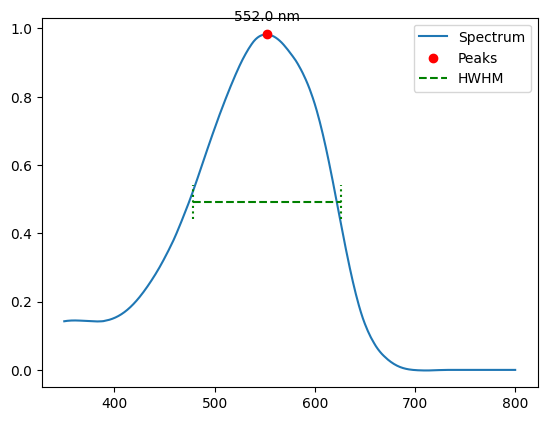

36


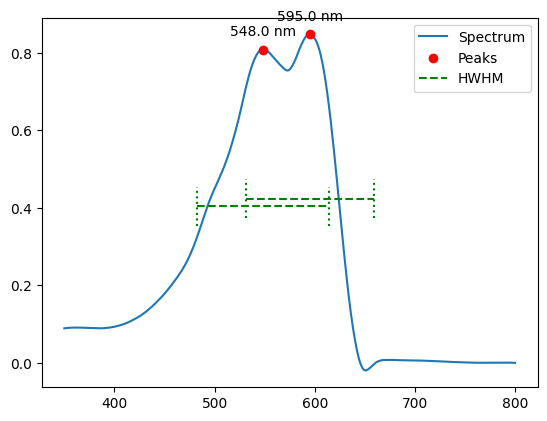

37


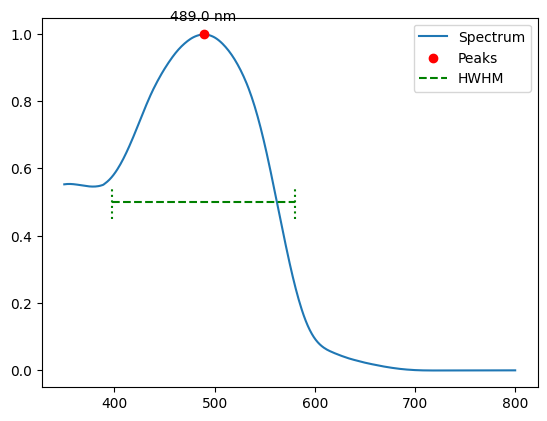

38


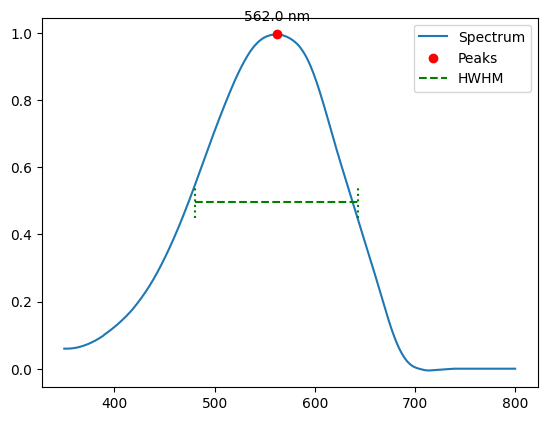

39


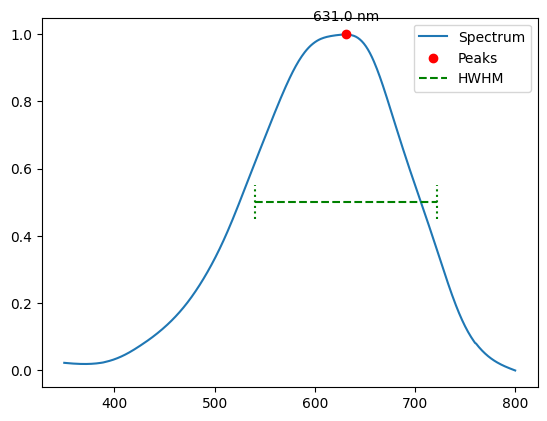

40


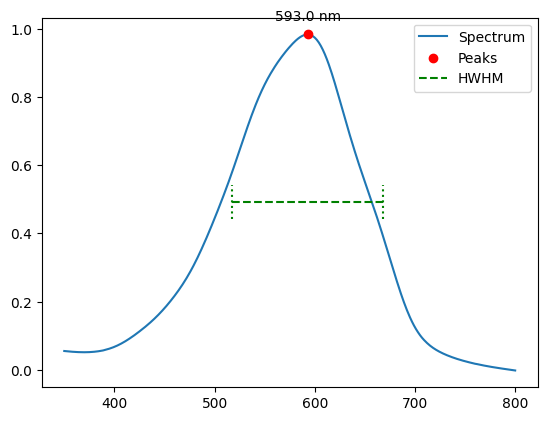

41


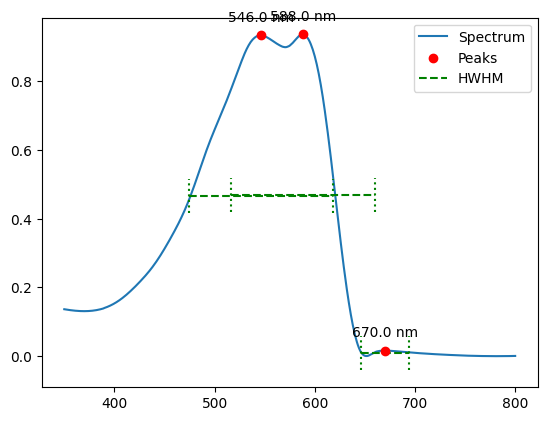

42


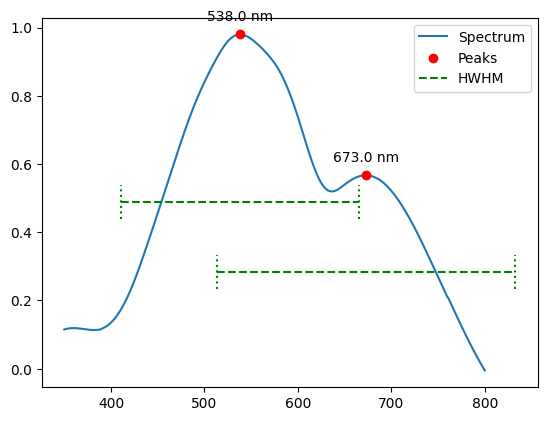

43


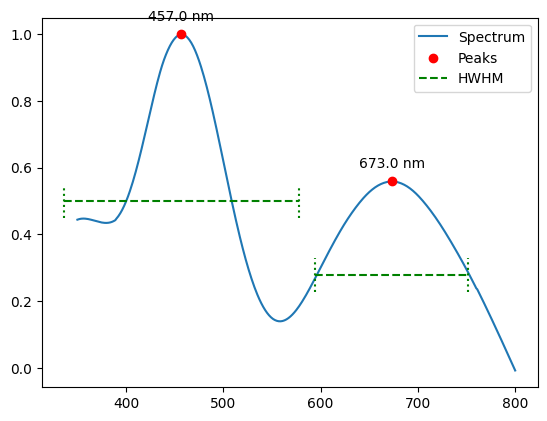

44


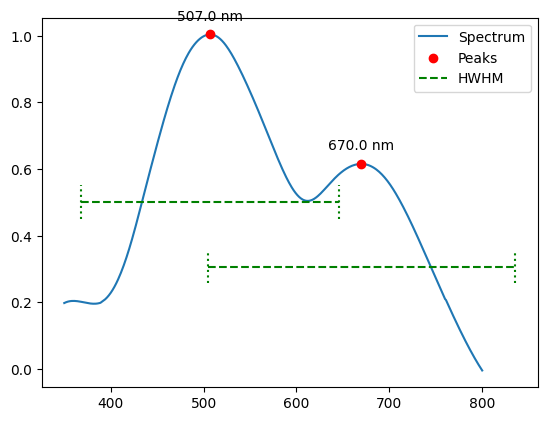

45


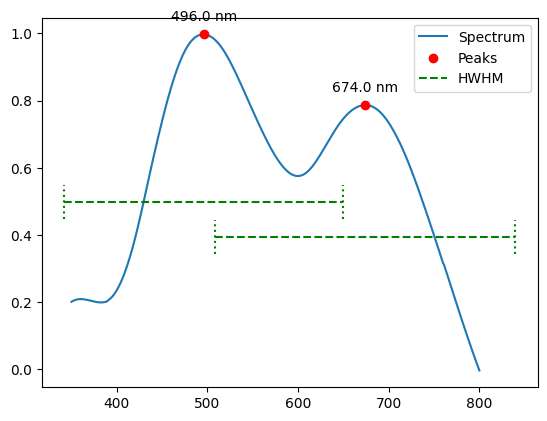

46


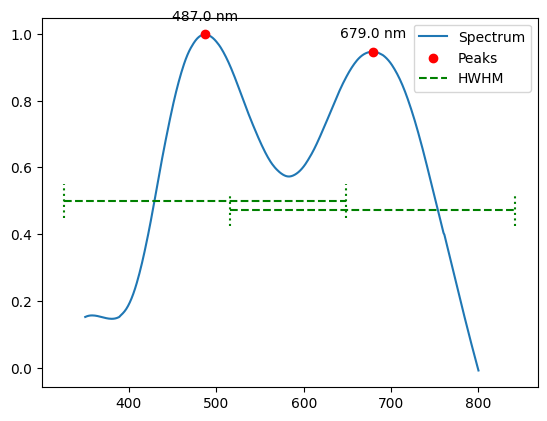

47


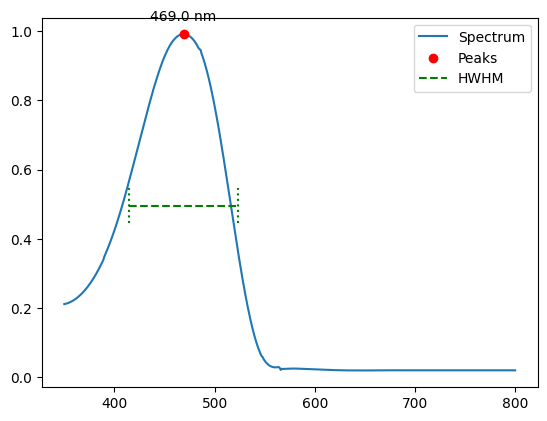

48


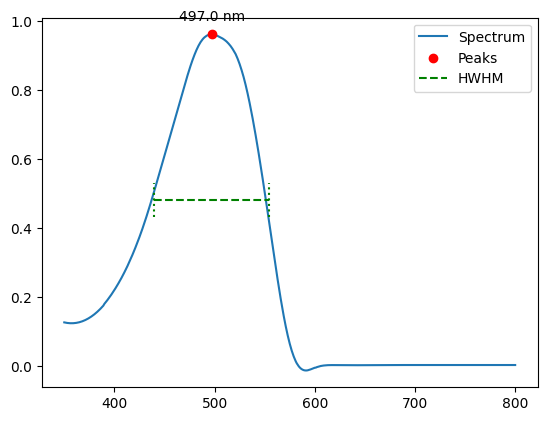

49


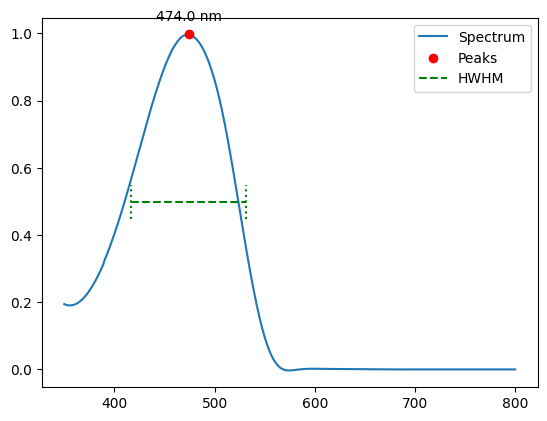

50


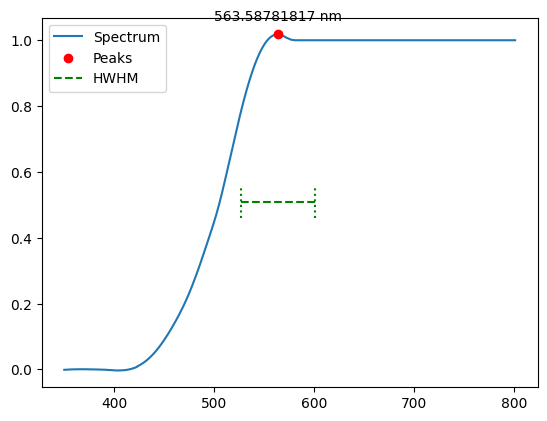

51


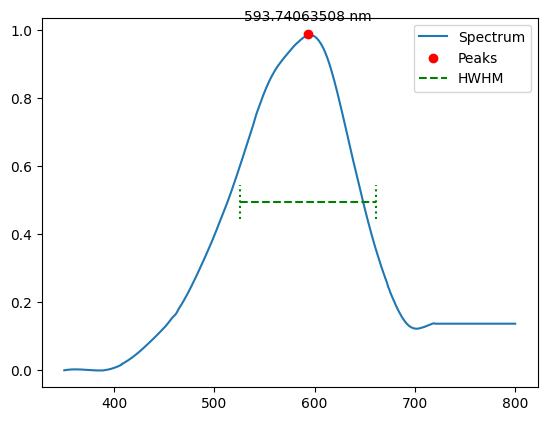

52


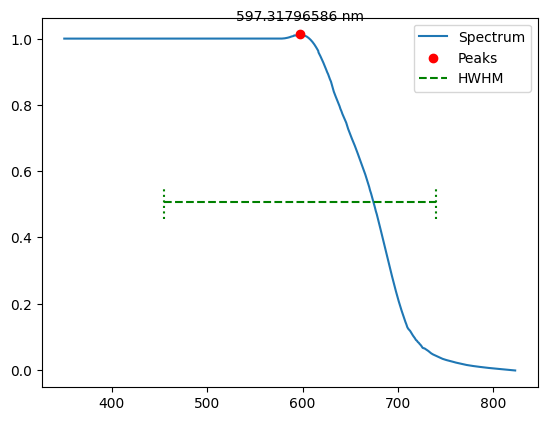

53


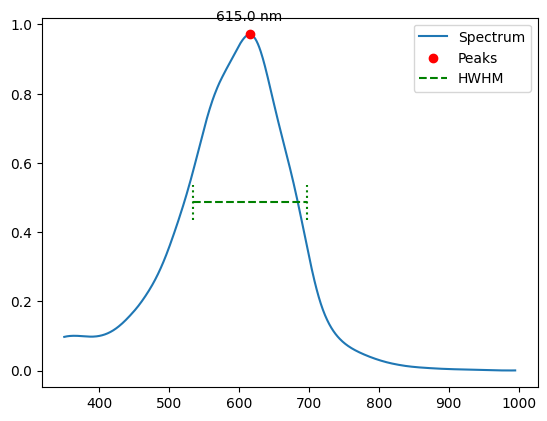

54


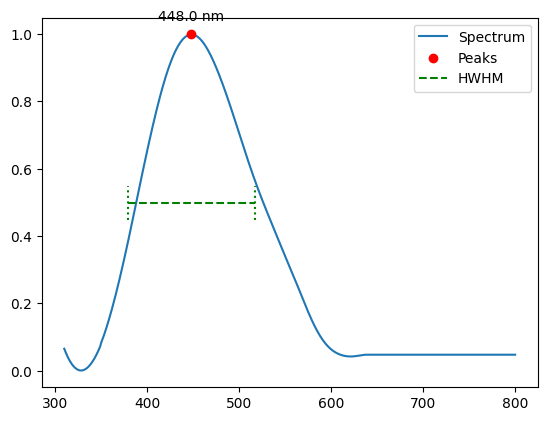

55


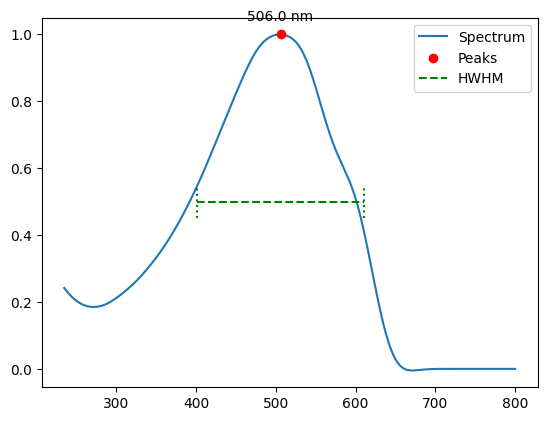

56


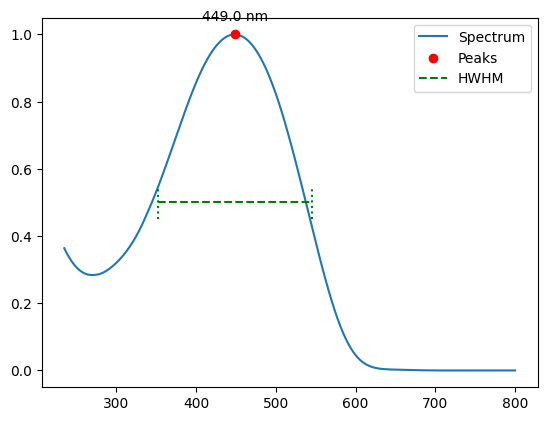

57


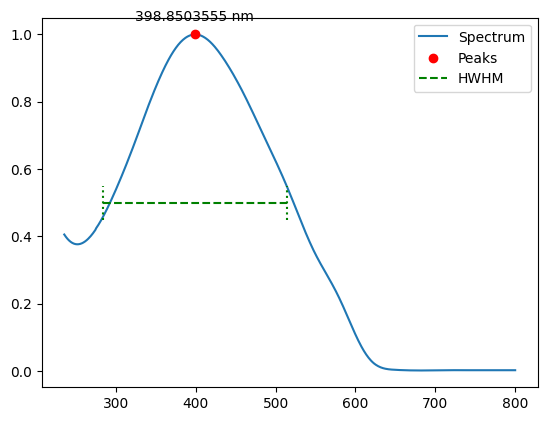

58


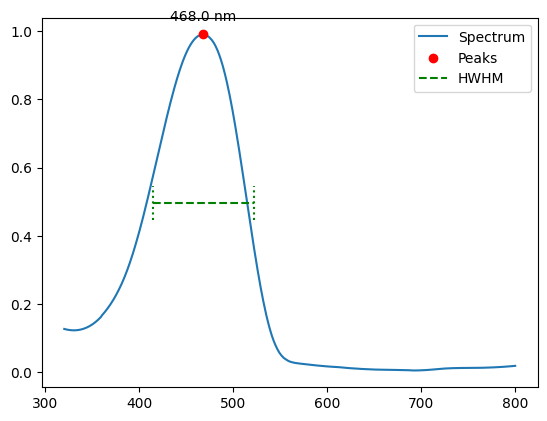

59


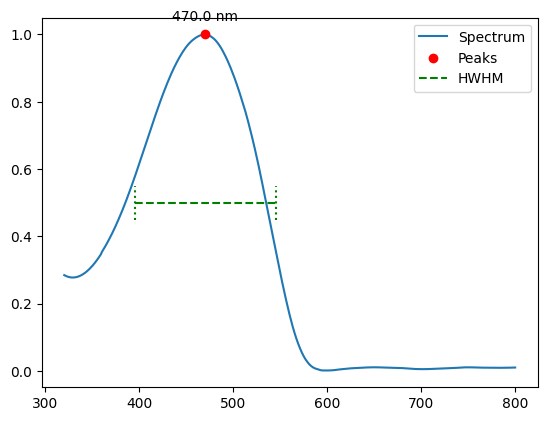

60


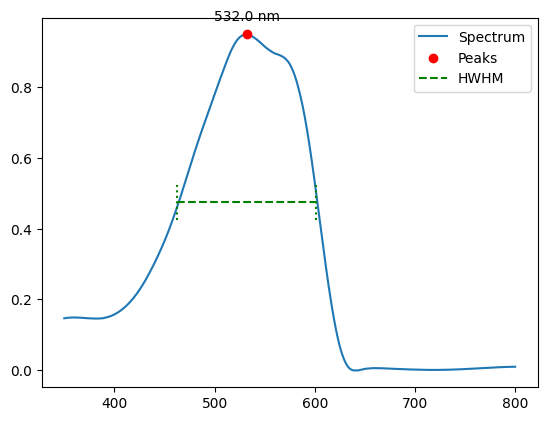

61


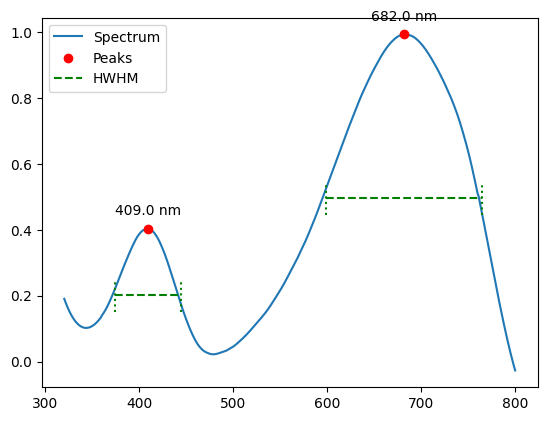

62


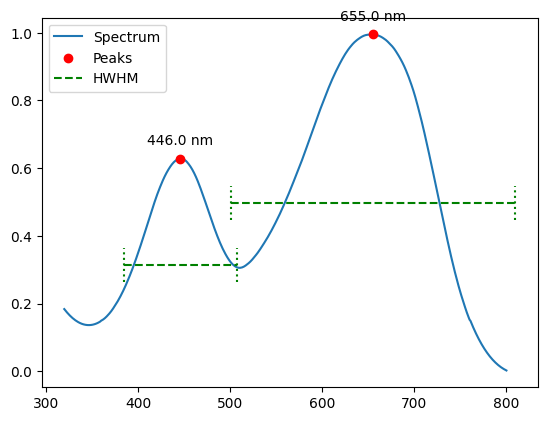

63


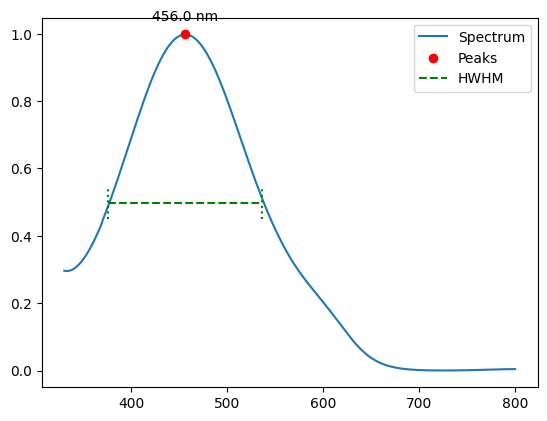

64


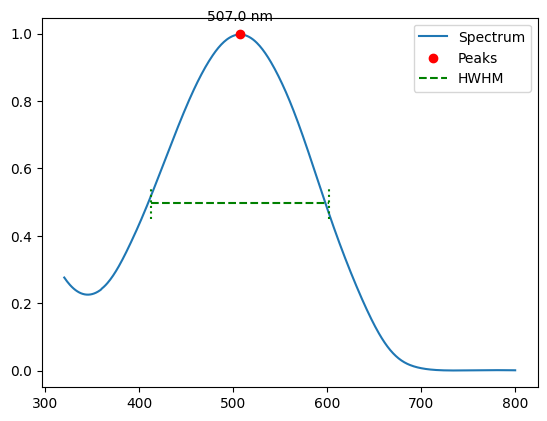

65


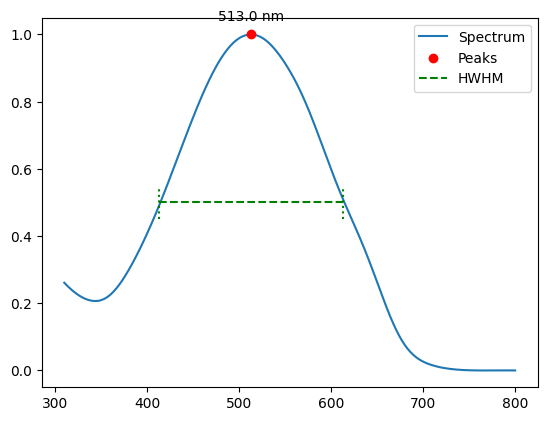

66


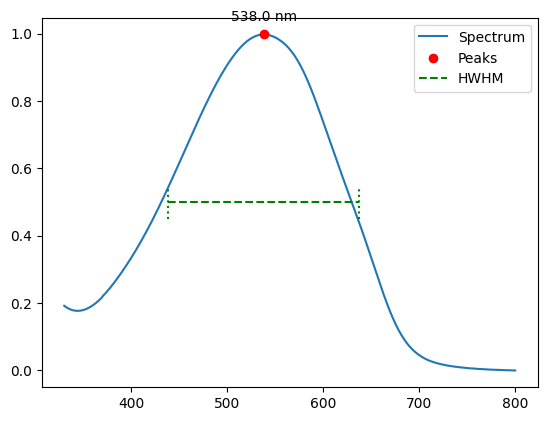

67


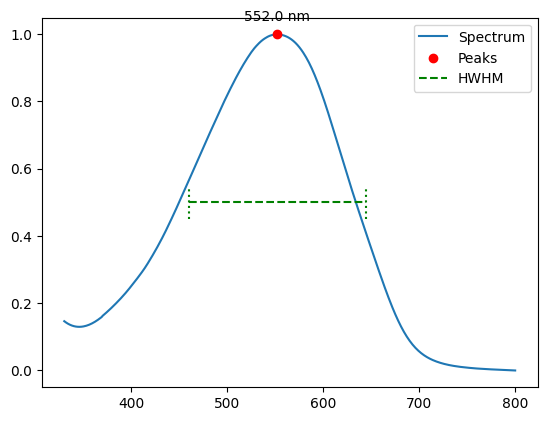

68


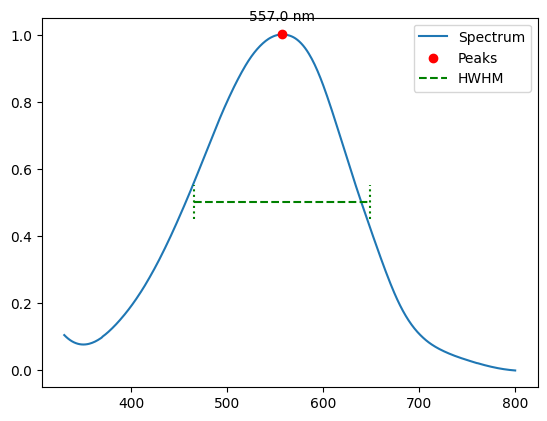

69


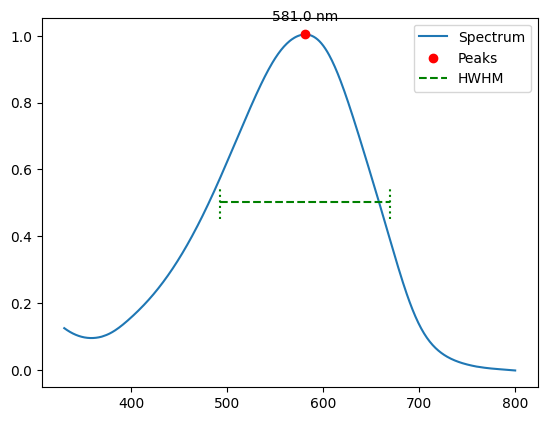

70


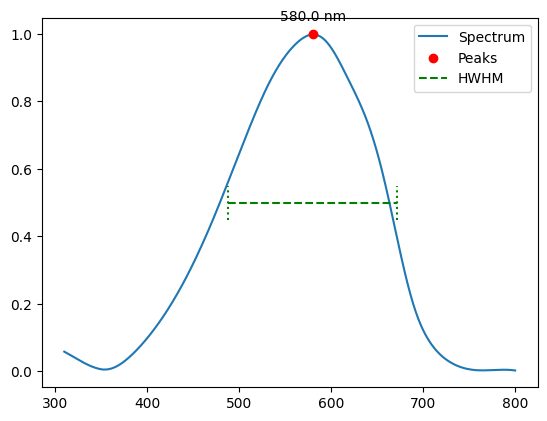

71


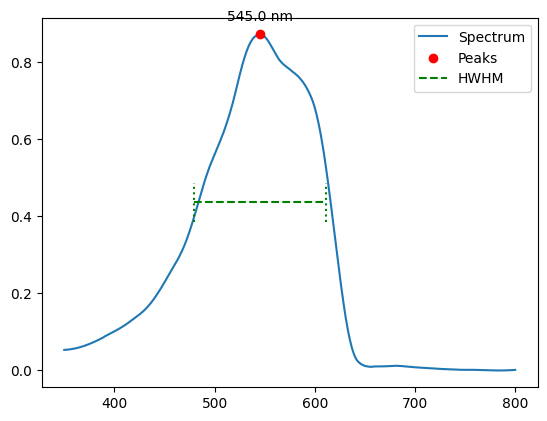

72


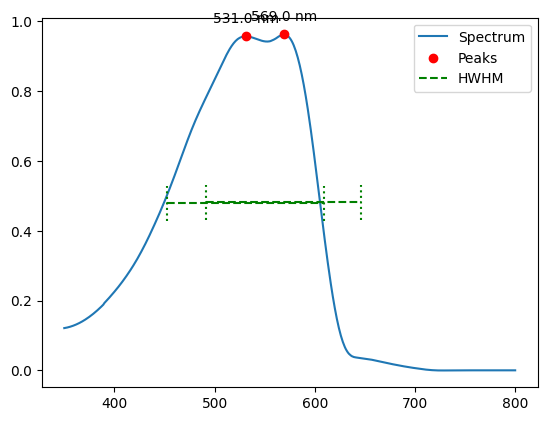

73


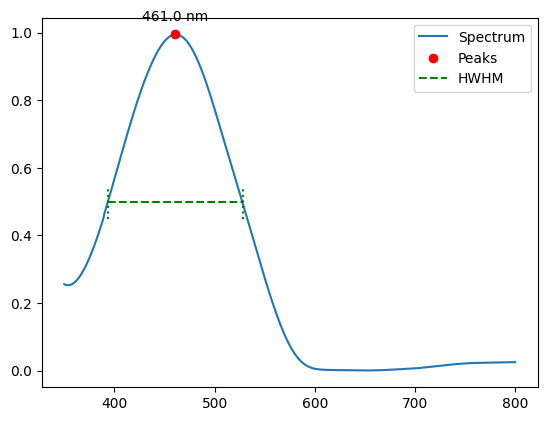

74


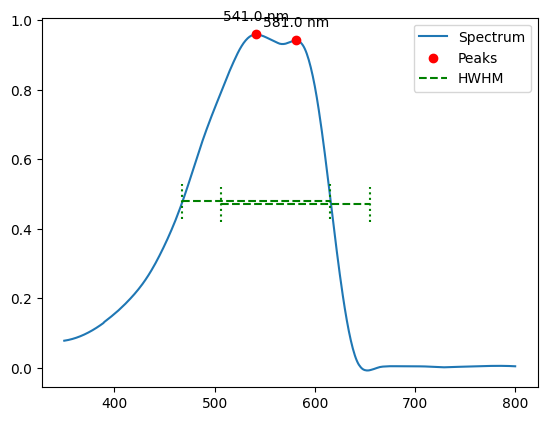

75


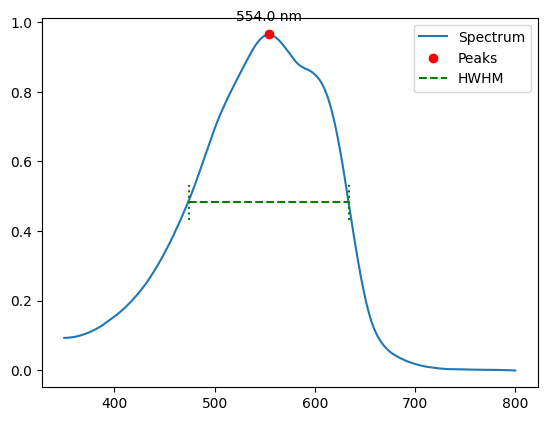

76


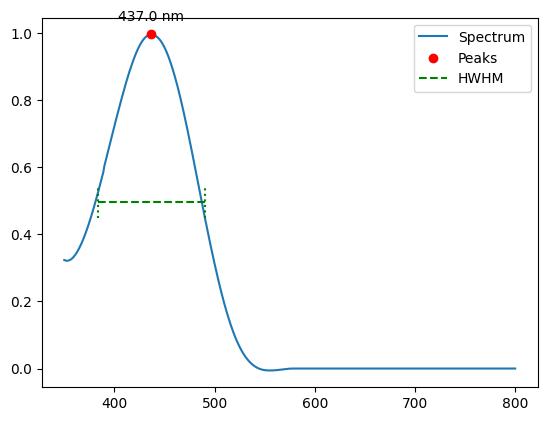

77


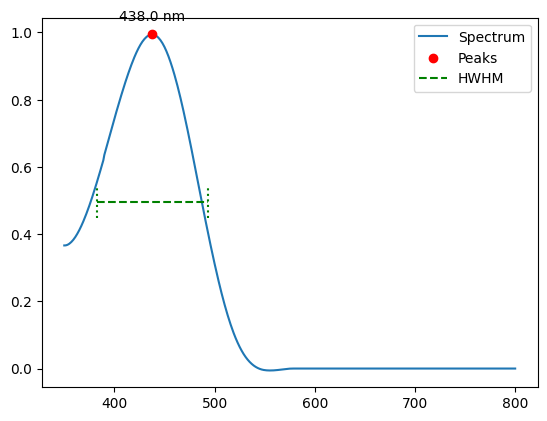

78


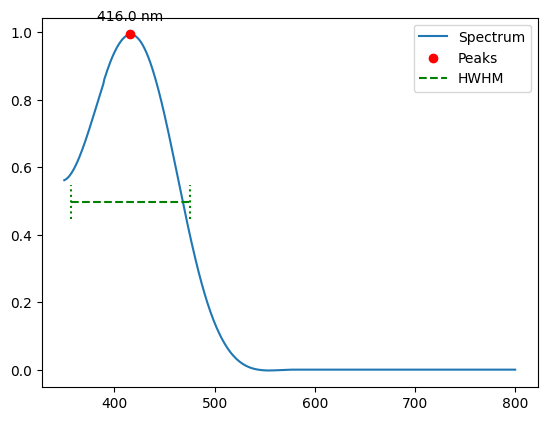

79


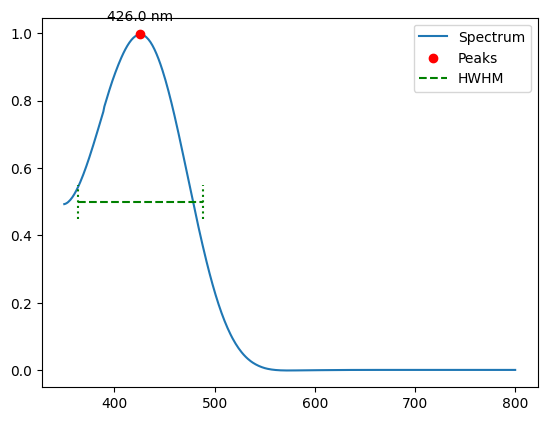

80


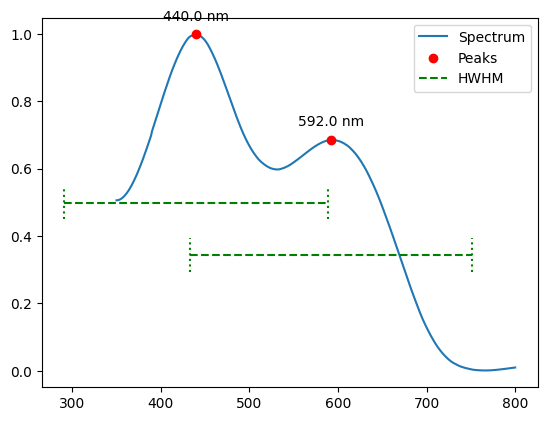

81


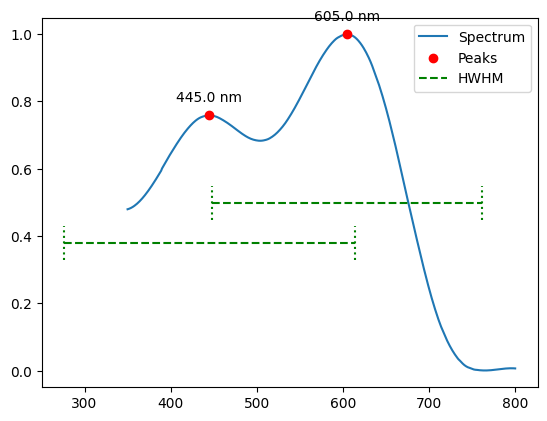

82


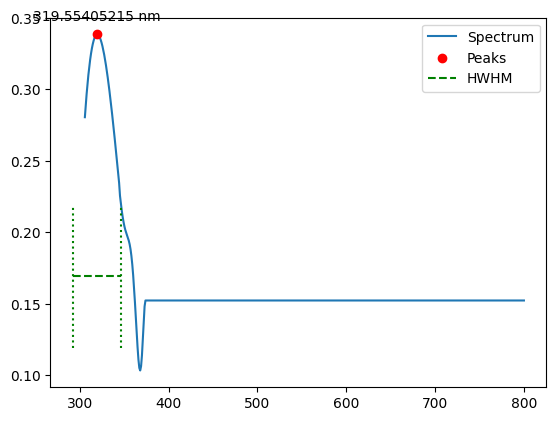

83


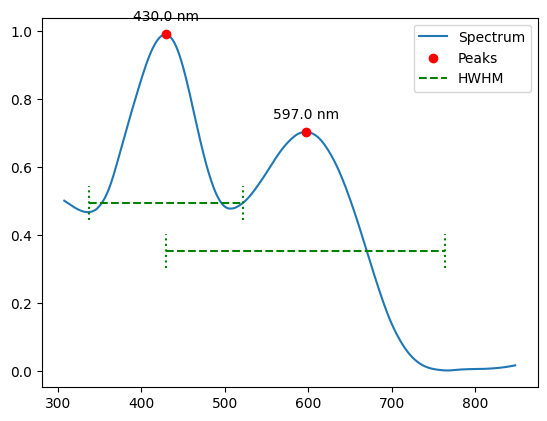

84


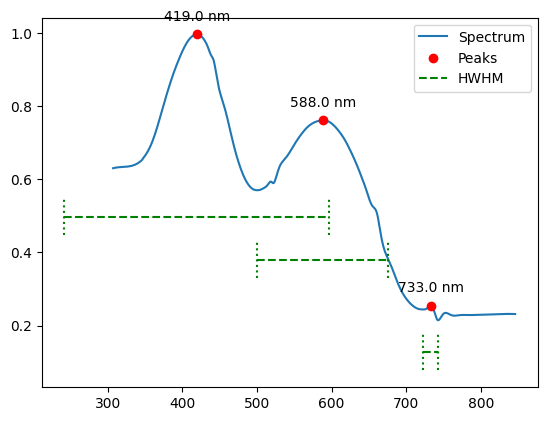

85


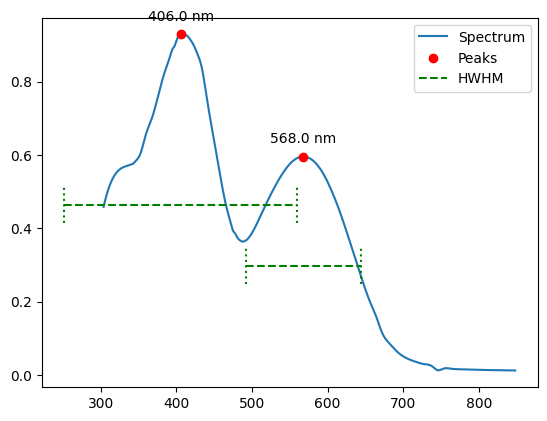

In [ ]:
peak_loc, peak_HWHM, intensities_list = [], [], []

for i in range(len(xaxis)):
    print(i)
    wavelength = ast.literal_eval(xaxis[i])
    energy = ast.literal_eval(intensity[i])
    peak_locs, peak_HWHMs, intensities = find_peaks_HWHM(wavelength, energy)
    peak_loc.append(peak_locs)
    peak_HWHM.append(peak_HWHMs)
    intensities_list.append(intensities)

0


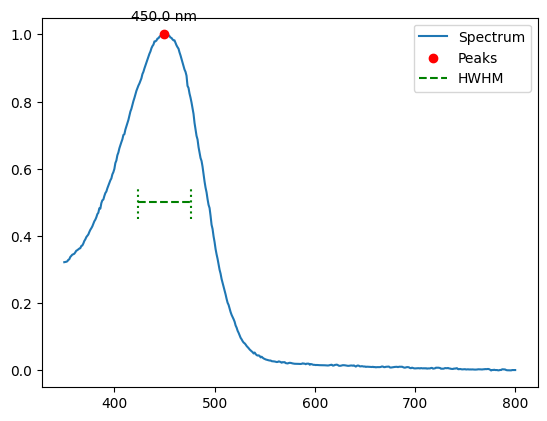

1


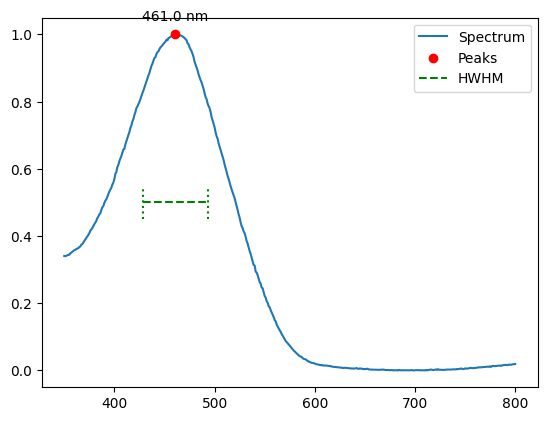

2


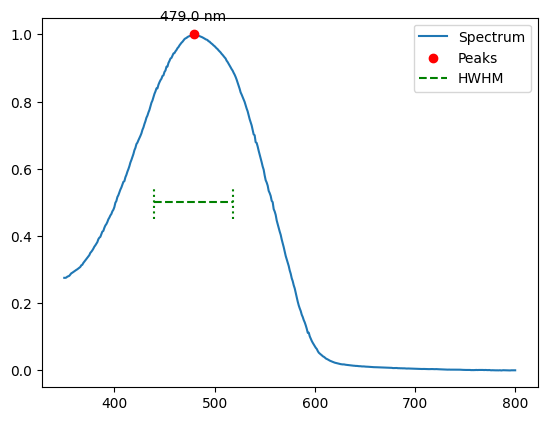

3


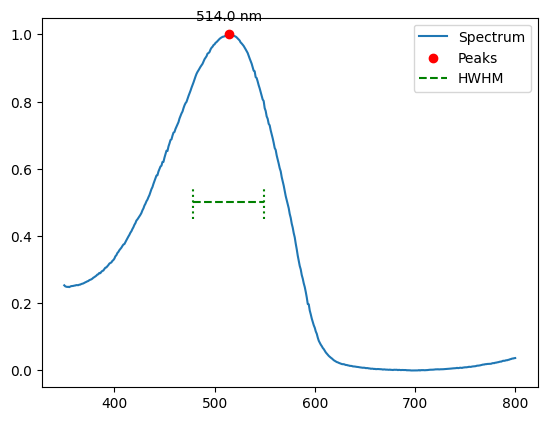

4


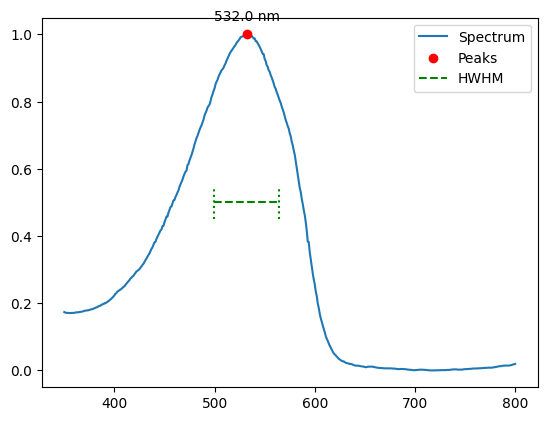

5


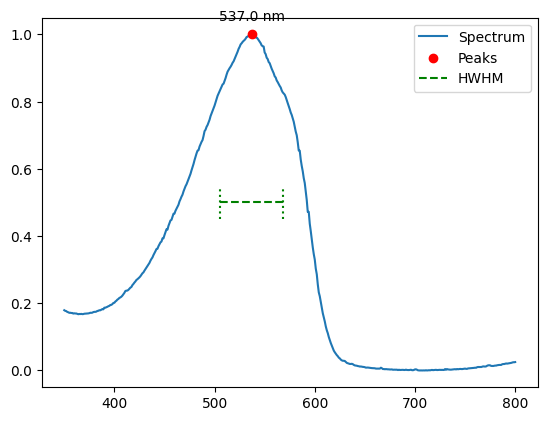

6


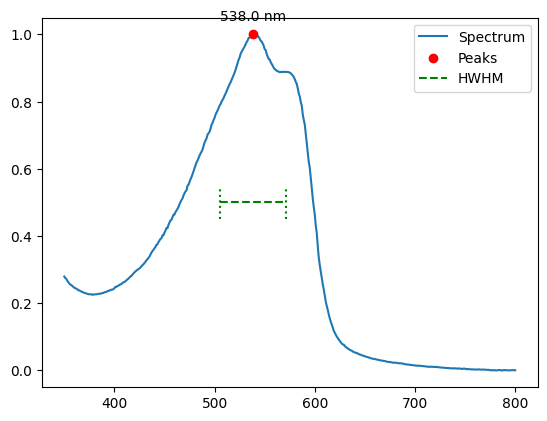

7


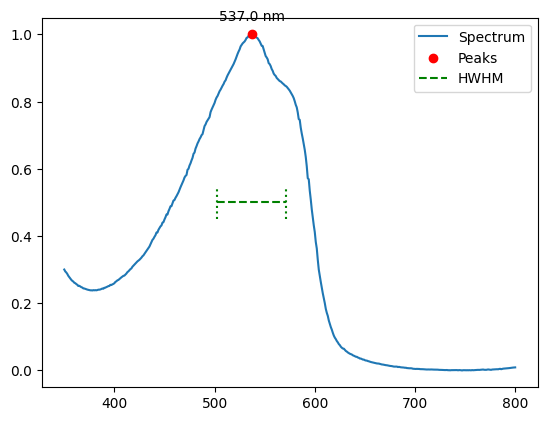

8


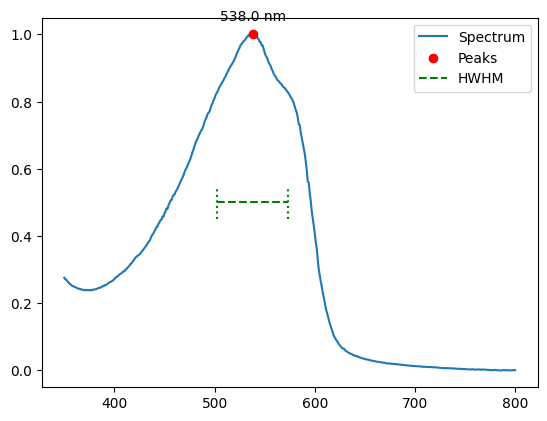

9


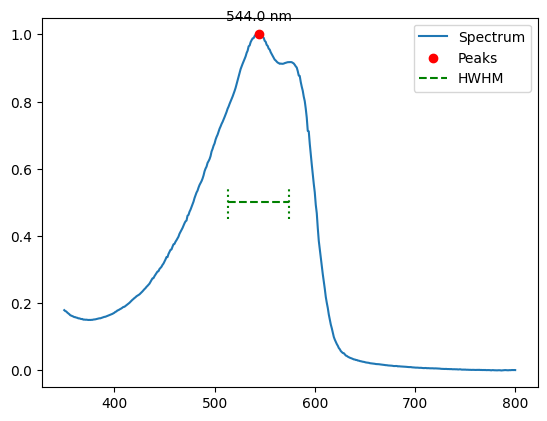

10


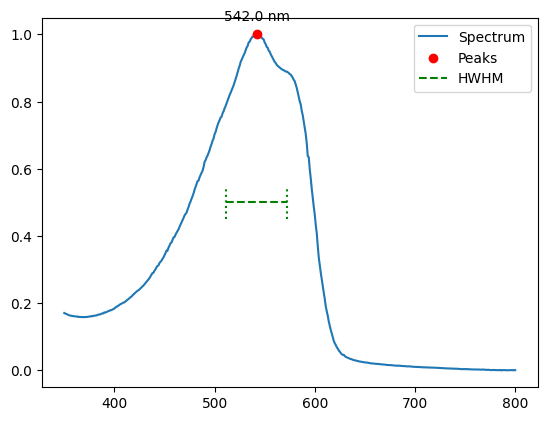

11


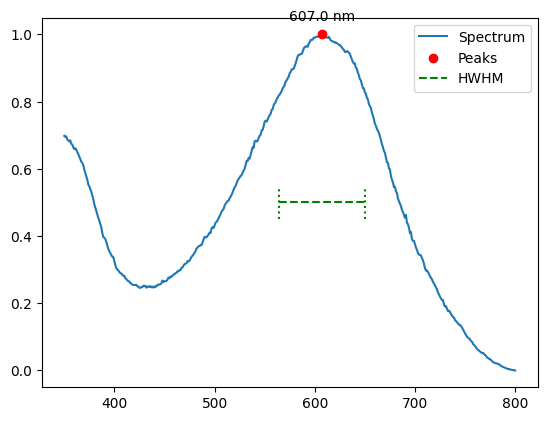

12


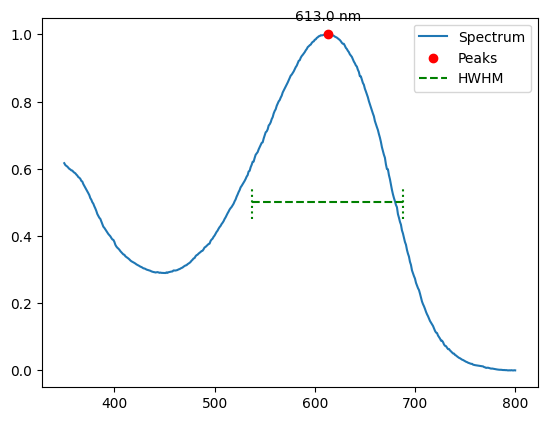

13


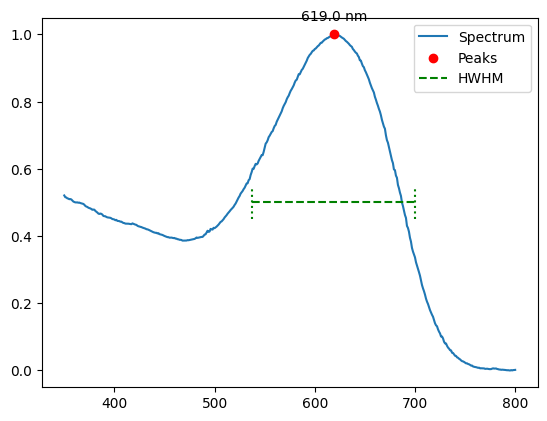

14


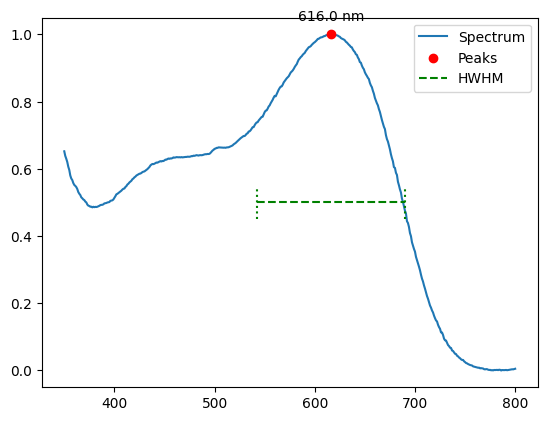

15


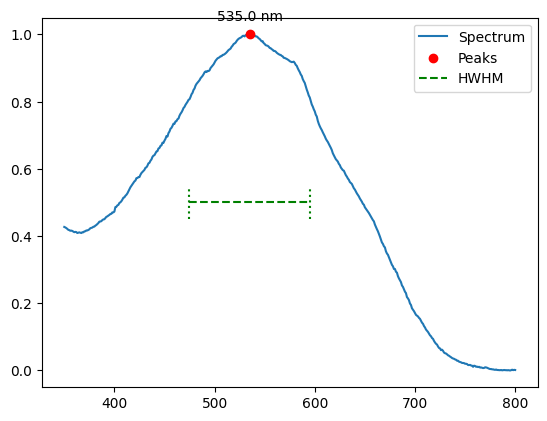

16


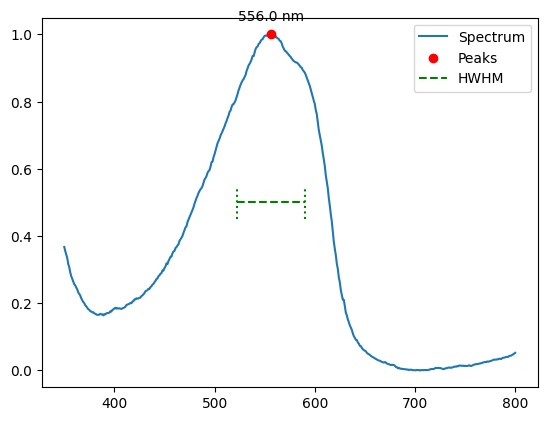

17


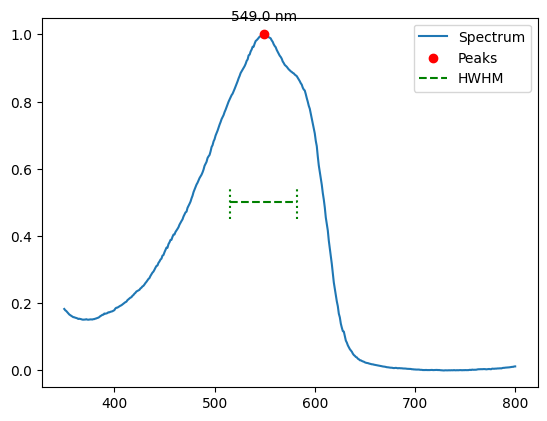

18


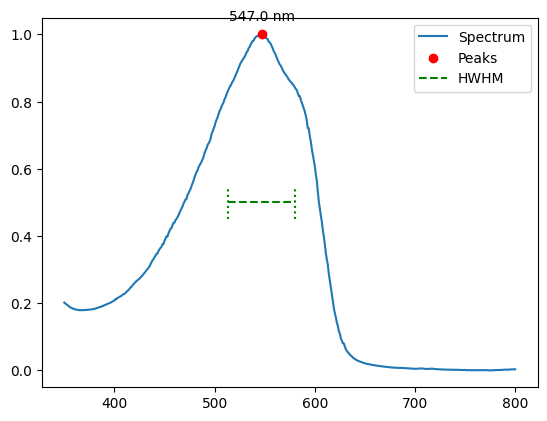

19


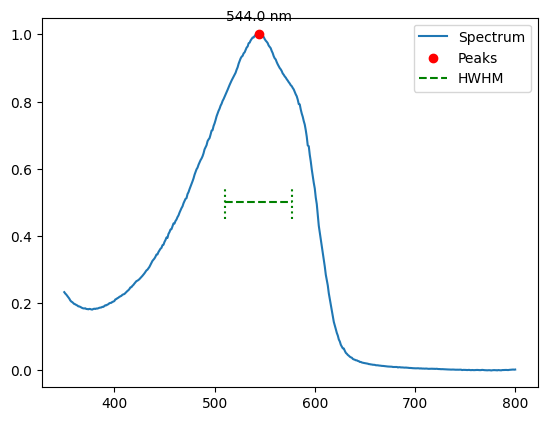

20


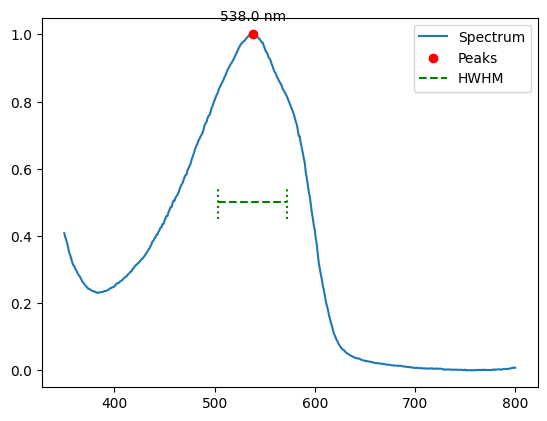

21


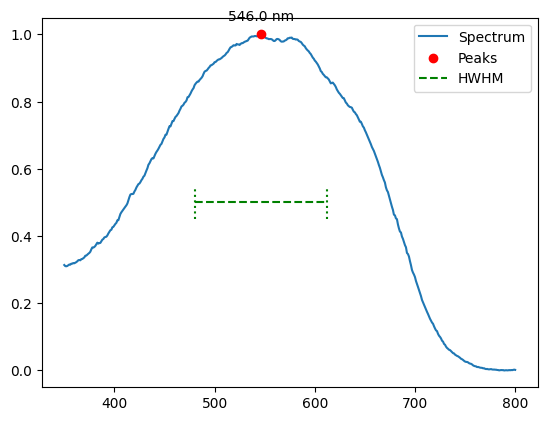

22


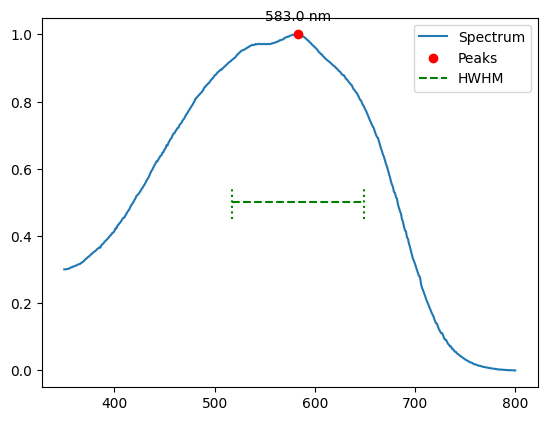

23


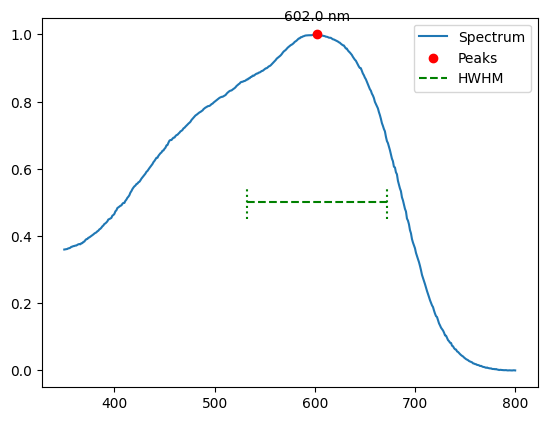

24


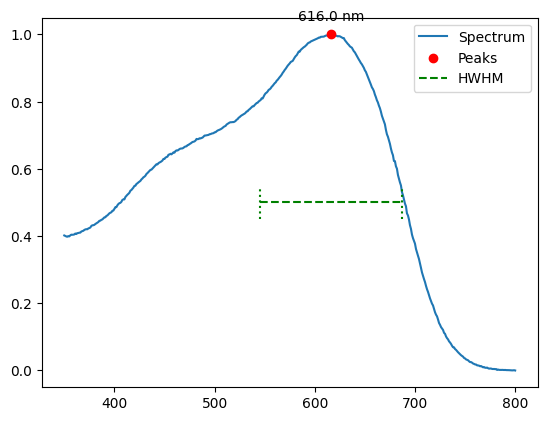

25


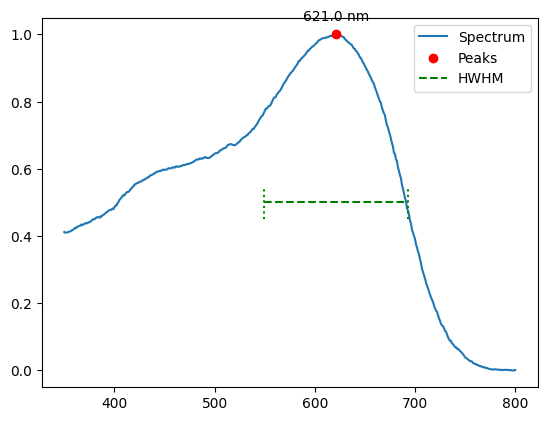

26


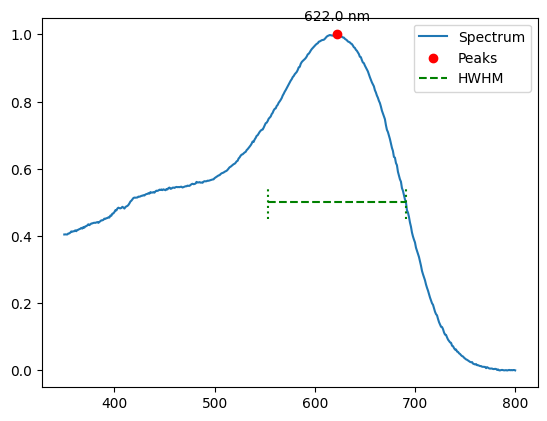

27


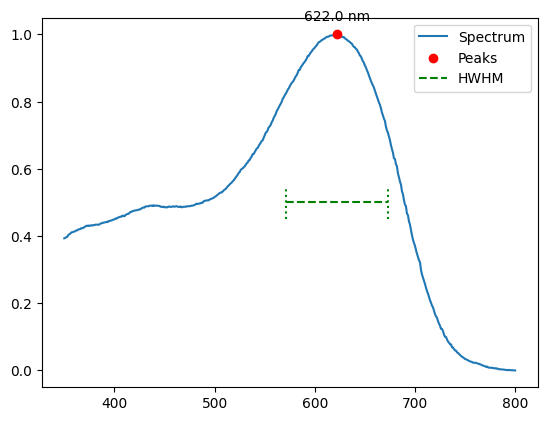

28


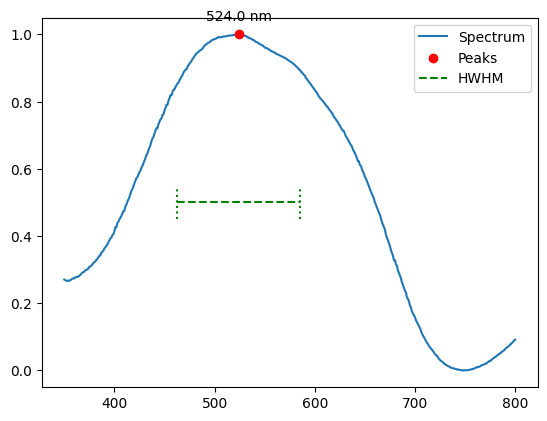

29


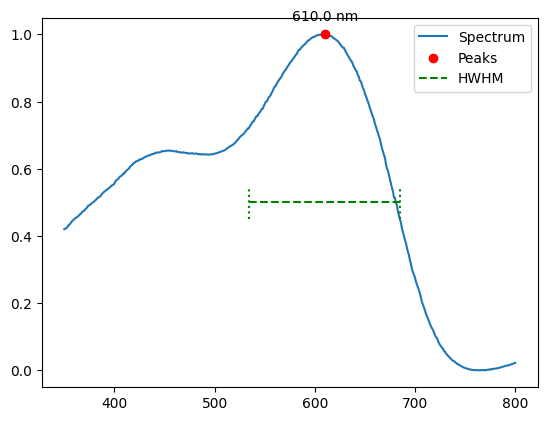

30


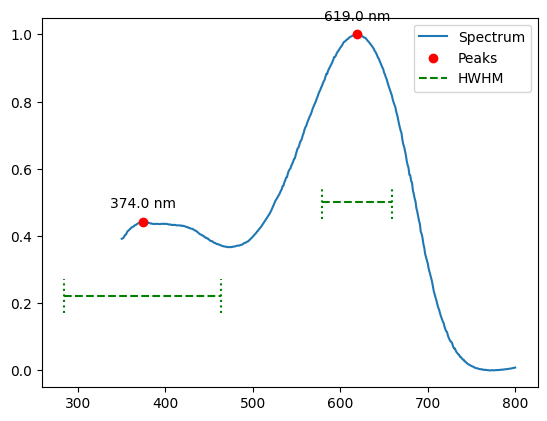

31


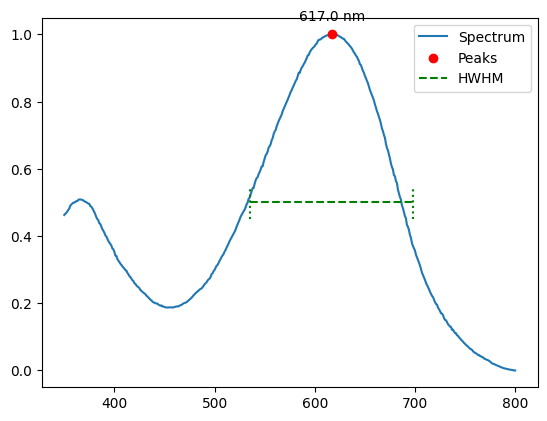

32


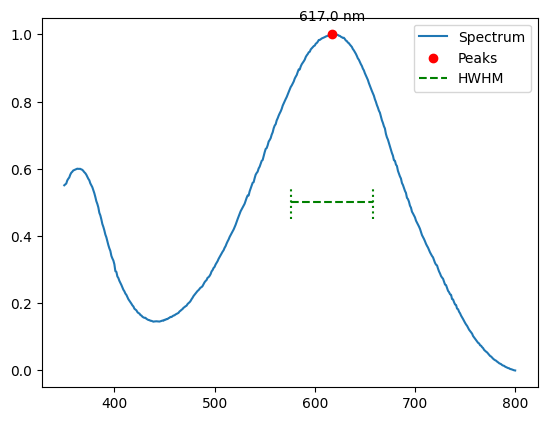

33


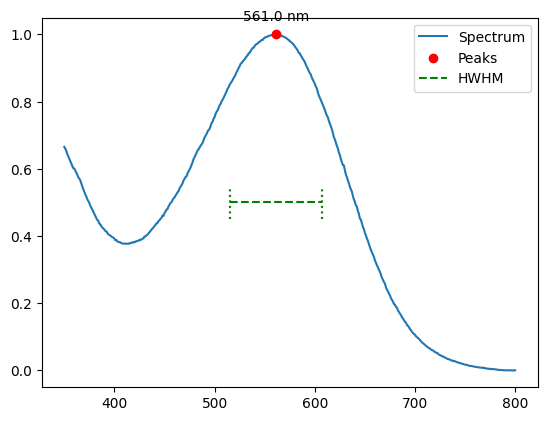

34


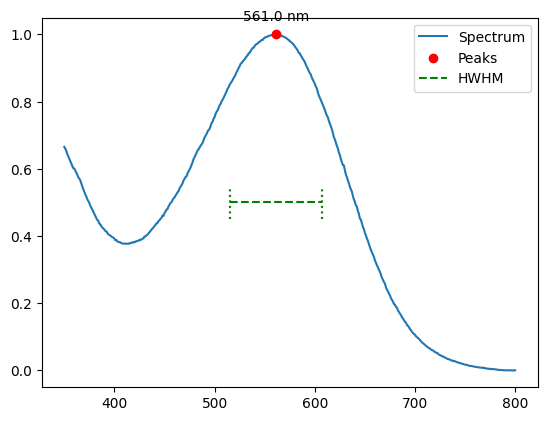

35


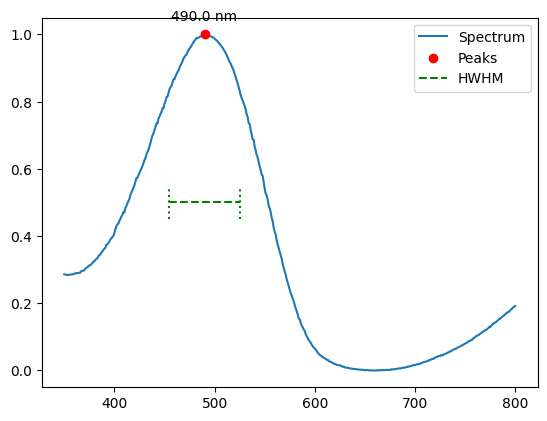

36


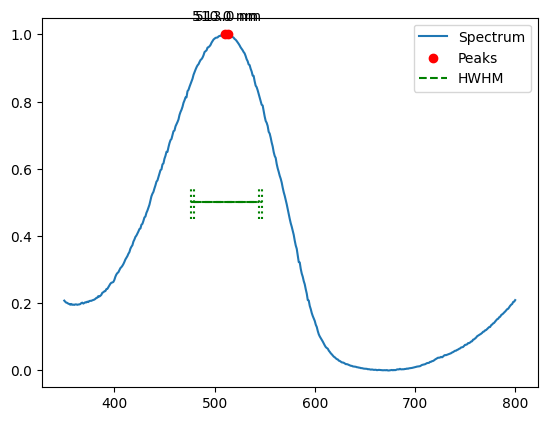

37


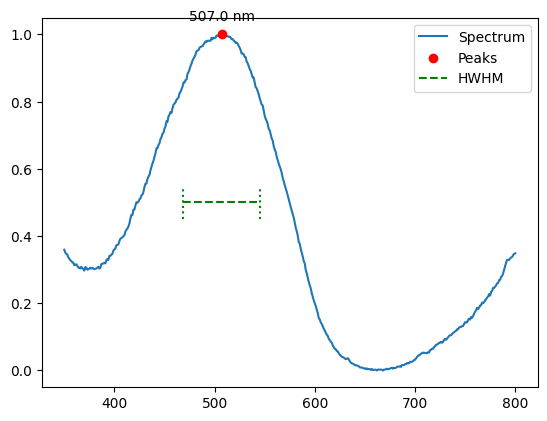

38


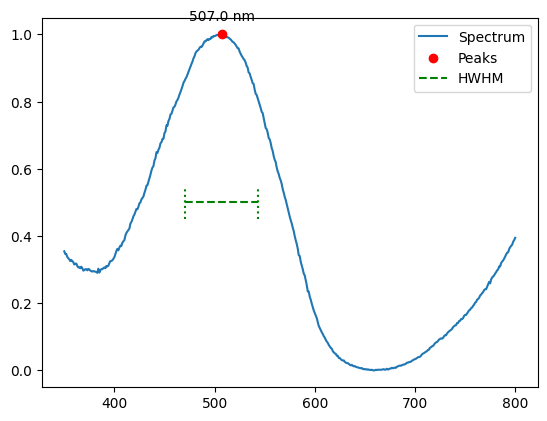

39


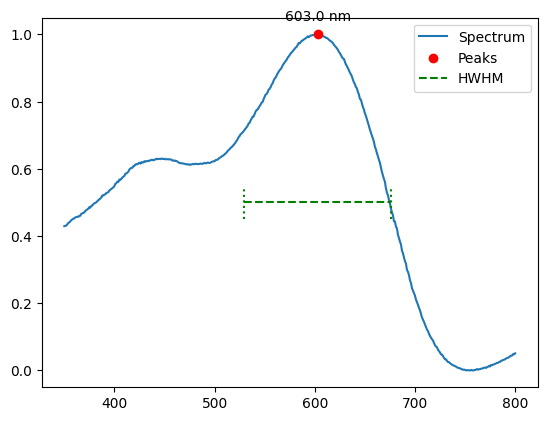

40


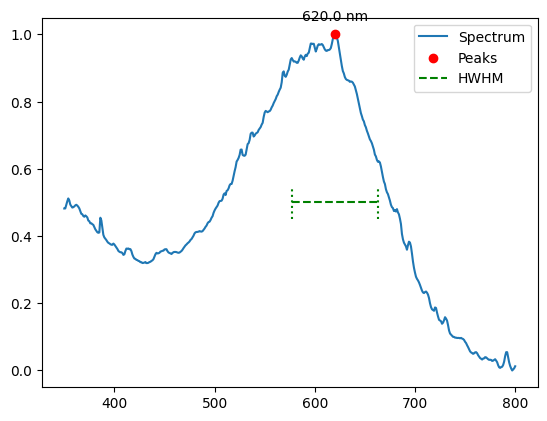

41


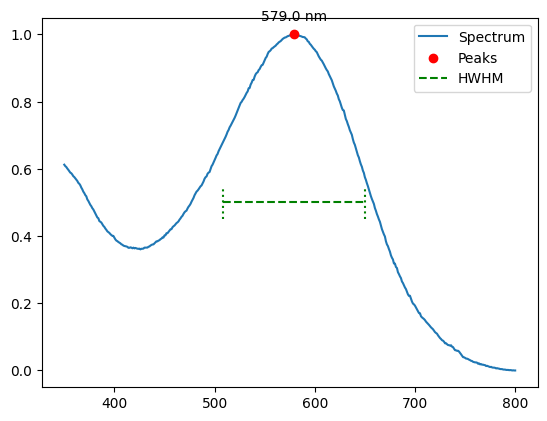

42


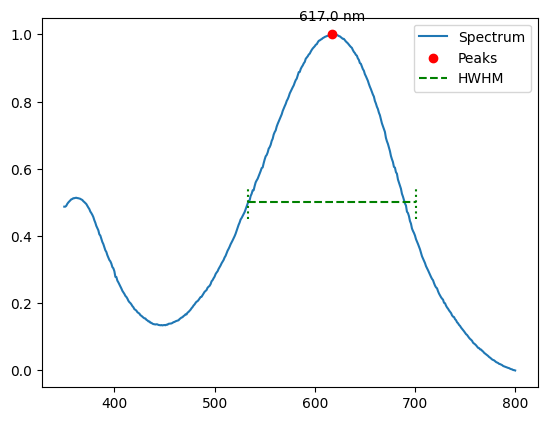

43


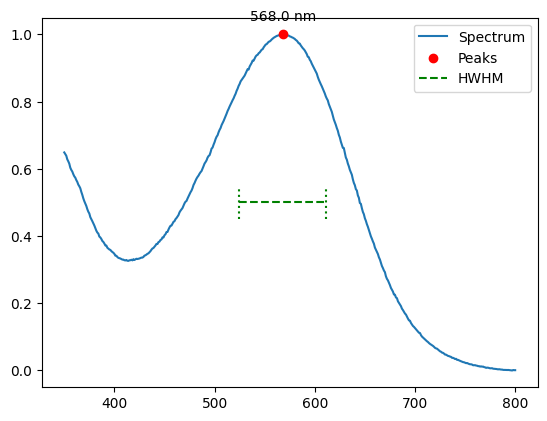

44


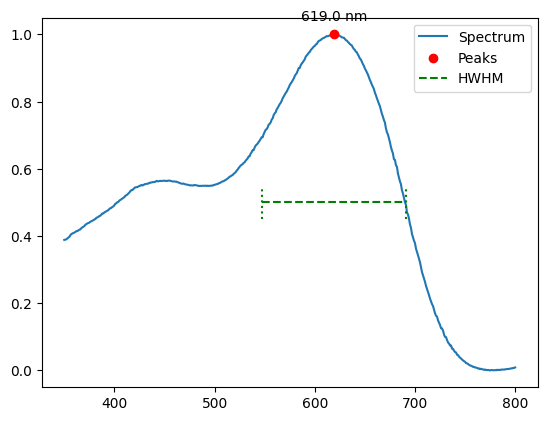

45


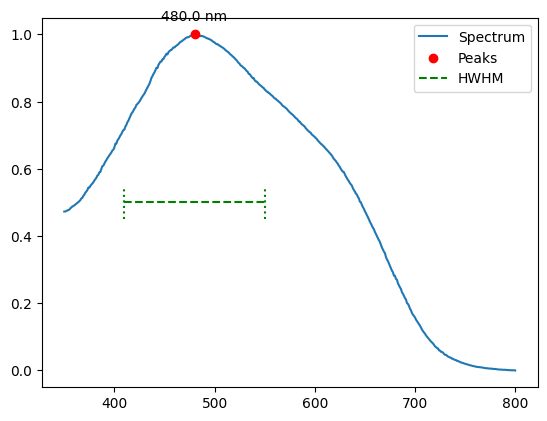

46


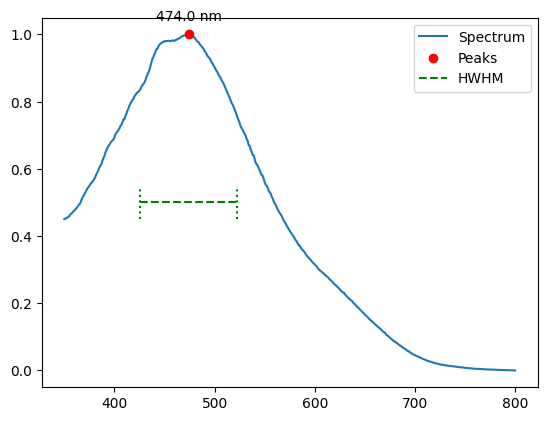

47


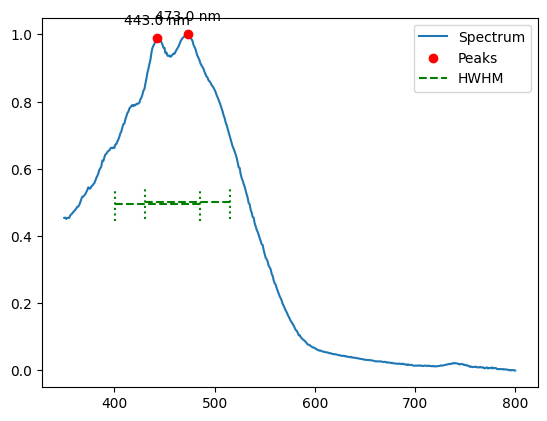

48


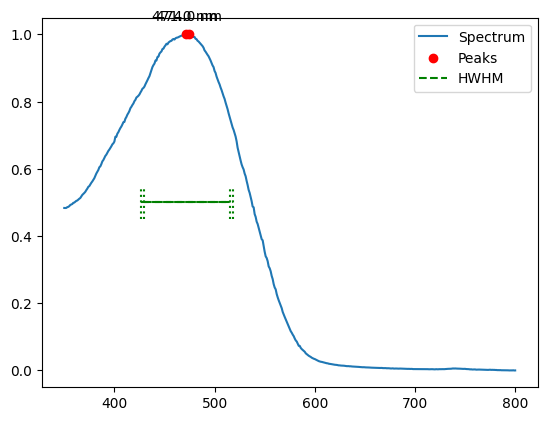

49


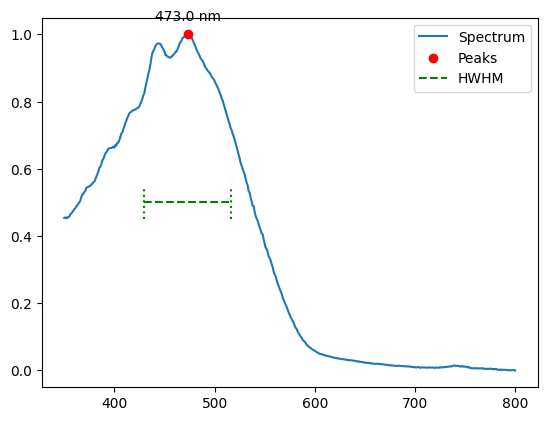

50


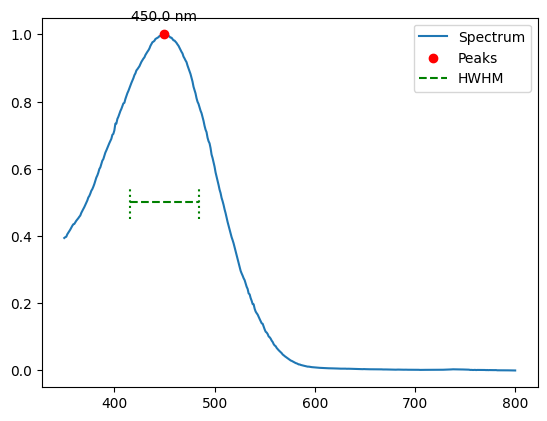

51


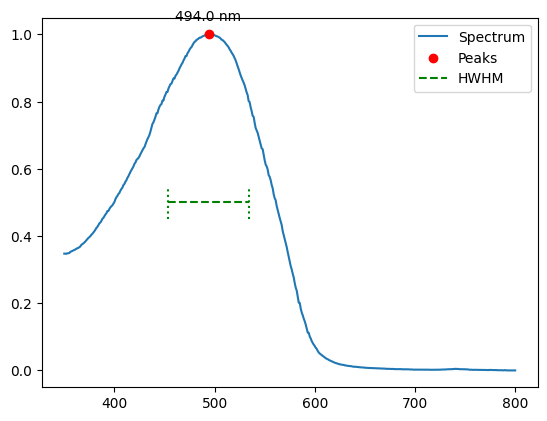

52


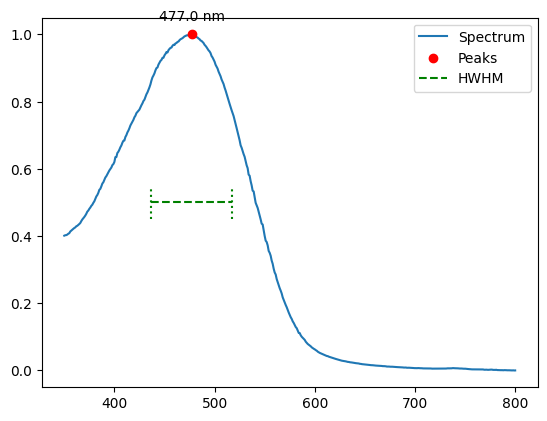

53


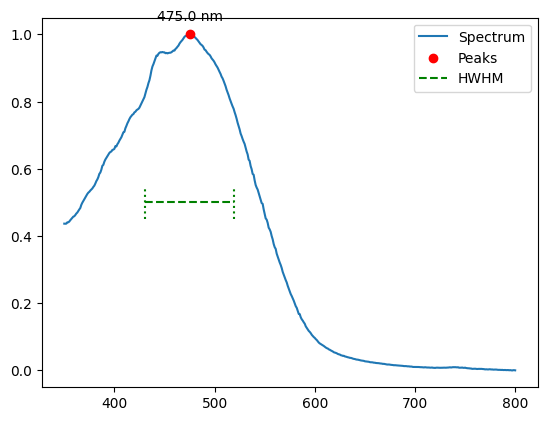

54


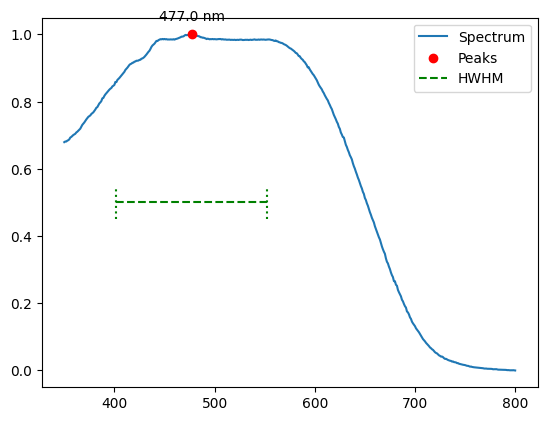

55


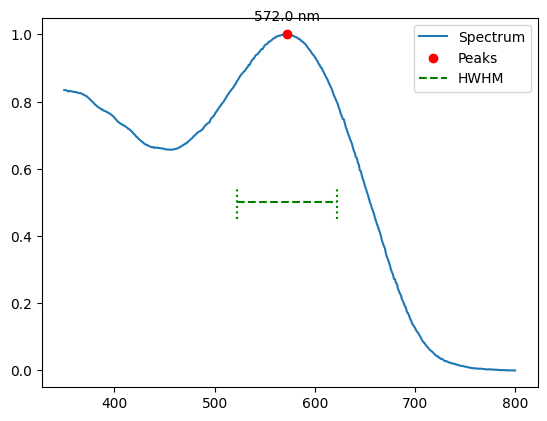

56


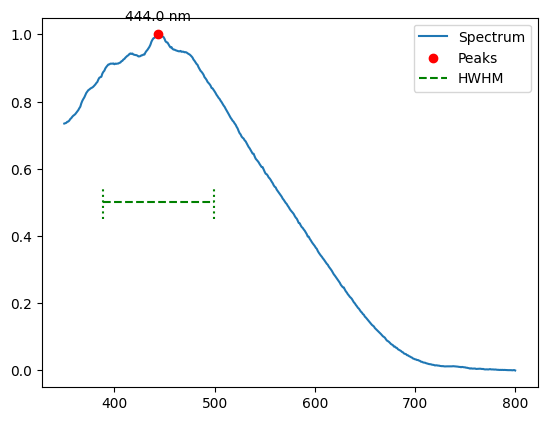

57


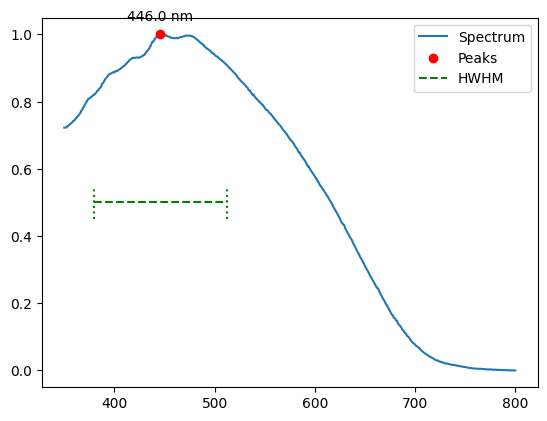

58


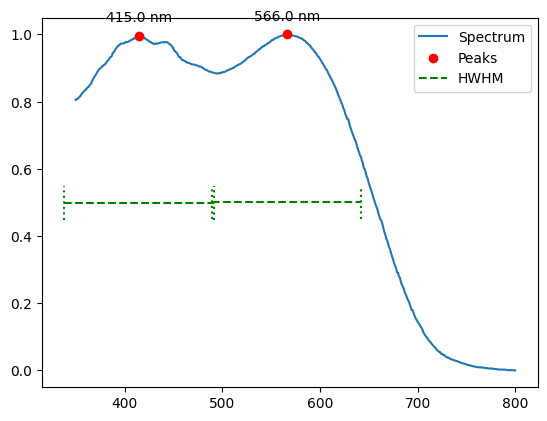

59


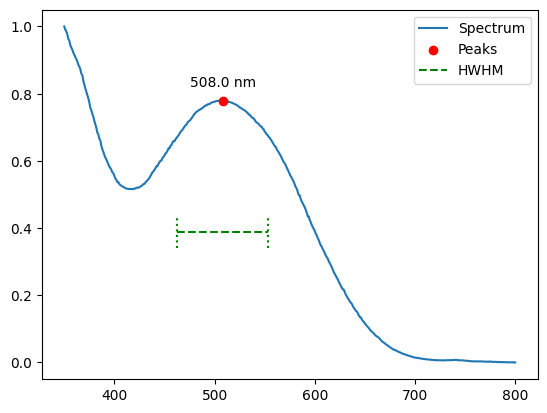

60


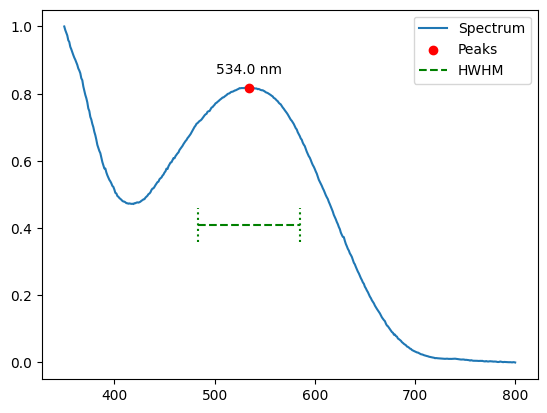

61


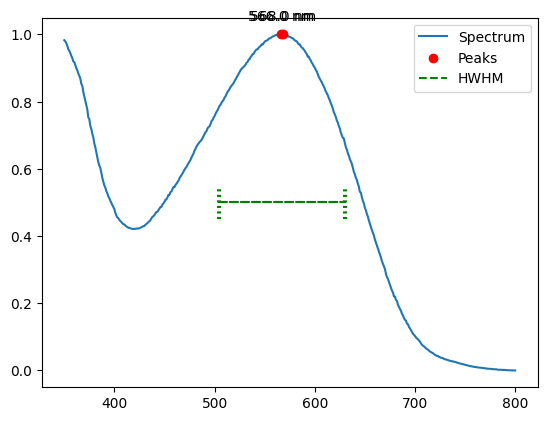

62


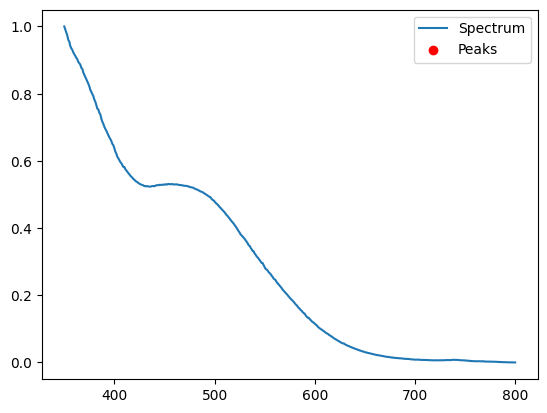

63


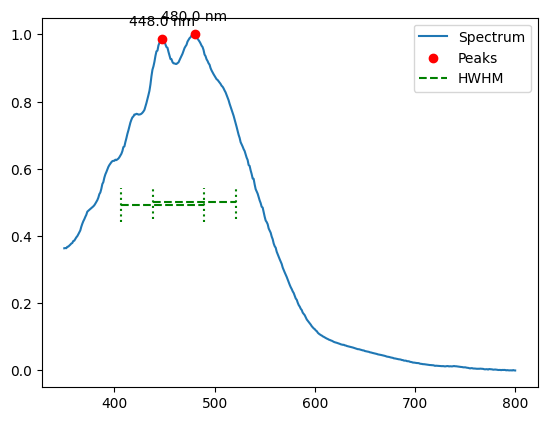

64


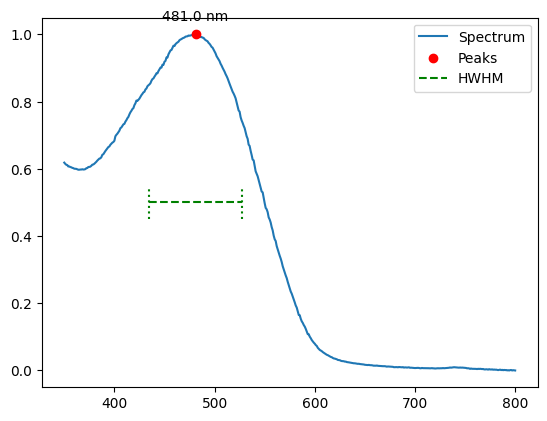

65


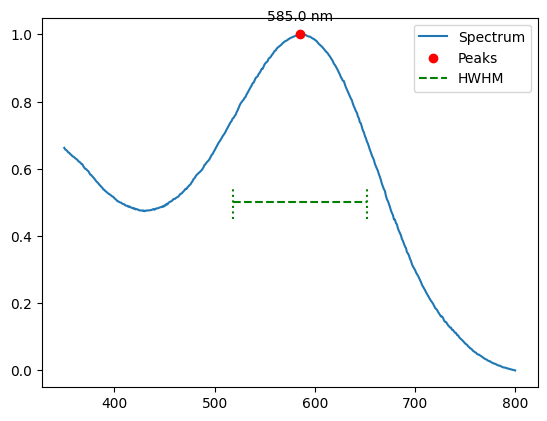

66


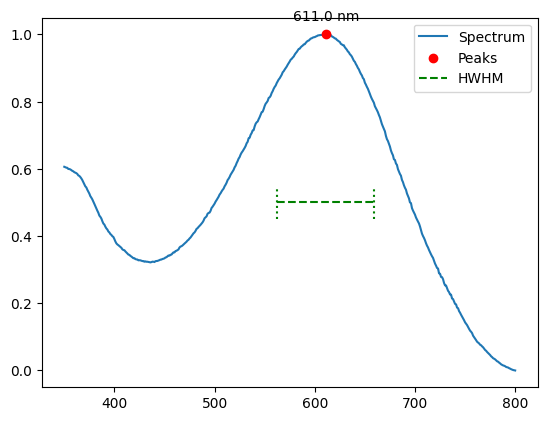

67


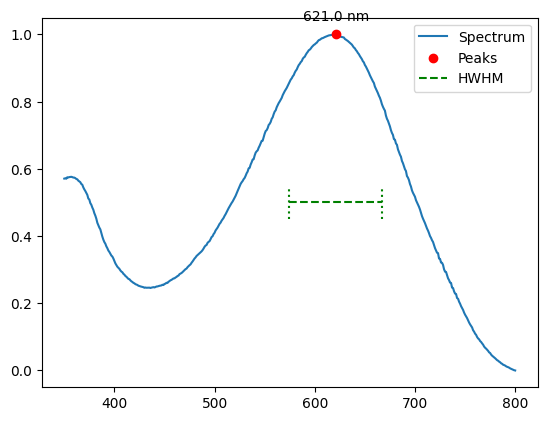

In [ ]:
peak_loc, peak_HWHM, intensities_list = [], [], []

for i in range(len(xaxis)):
    print(i)
    wavelength = ast.literal_eval(xaxis[i])
    energy = ast.literal_eval(intensity[i])
    peak_locs, peak_HWHMs, intensities = get_abs_data(wavelength, energy)
    peak_loc.append(peak_locs)
    peak_HWHM.append(peak_HWHMs)
    intensities_list.append(intensities)

In [ ]:
import numpy as np
from scipy.signal import find_peaks


def find_peaks_HWHM(x, y, prominence=0.05):
    """Find major peaks in the spectrum and calculate their HWHM based on prominence.

    Parameters:
    x (array_like): The x values of the spectrum.
    y (array_like): The y values of the spectrum.
    prominence (float): The minimum prominence of peaks to consider.

    Returns:
    A tuple of three arrays:
    - peak_locs: The x locations of the peaks.
    - peak_HWHMs: The half width half maximum of the peaks.
    - intensities: The y values at the peaks.
    """

    peaks, properties = find_peaks(y, prominence=prominence)
    peak_locs = np.array(x)[peaks]
    intensities = np.array(y)[peaks]

    peak_HWHMs = np.zeros_like(peak_locs)
    for i, peak in enumerate(peaks):
        half_max = intensities[i] / 2

        # Find the index on the left side of the peak
        left_side = y[:peak]
        left_distances = np.abs(left_side - half_max)
        left_idx = (
            np.argwhere(left_distances == np.min(left_distances)).flatten()[-1]
            if left_distances.size > 0
            else 0
        )

        # Find the index on the right side of the peak
        right_side = y[peak:]
        right_distances = np.abs(right_side - half_max)
        right_idx = (
            peak
            + np.argwhere(
                right_distances == np.min(right_distances)
            ).flatten()[0]
            if right_distances.size > 0
            else len(y) - 1
        )

        # Calculate HWHM based on actual x values
        peak_HWHMs[i] = (x[right_idx] - x[left_idx]) / 2

    return peak_locs, peak_HWHMs, intensities

In [ ]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import splrep, sproot


def fwhm_and_peaks(x, y, prominence=0.1, k=3):
    """
    Determine the full-width-half-maximum (FWHM) for multiple peaks in a dataset,
    as well as their peak wavelengths and intensities.

    Parameters:
    x (array_like): The x values of the data points.
    y (array_like): The y values of the data points, corresponding to x.
    prominence (float): The minimum prominence of peaks to consider.
    k (int): The order of the spline interpolation.

    Returns:
    list of tuples: Each tuple contains (FWHM, peak wavelength, peak intensity) for a peak.
    """
    peak_indices, _ = find_peaks(y, prominence=prominence)
    results = []

    for peak_idx in peak_indices:
        peak_x = x[peak_idx]
        peak_y = y[peak_idx]

        # Use a window around the peak to focus the FWHM calculation
        window_size = 10  # Adjust based on your dataset characteristics
        left_idx = max(peak_idx - window_size, 0)
        right_idx = min(peak_idx + window_size, len(x) - 1)

        window_x = x[left_idx : right_idx + 1]
        window_y = y[left_idx : right_idx + 1]
        half_max = peak_y / 2.0

        try:
            s = splrep(window_x, window_y - half_max, k=k)
            roots = sproot(s)

            if len(roots) >= 2:
                # Calculate FWHM as the distance between the first and last root in this window
                fwhm_value = abs(roots[-1] - roots[0])
                results.append((fwhm_value, peak_x, peak_y))
        except Exception as e:
            # Handle cases where spline interpolation fails (e.g., not enough points)
            print(f"Error calculating FWHM for peak at x={peak_x}: {e}")

    return results

In [ ]:
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, find_peaks_cwt
import os


def abs_max_intensity(wavelength, intensities):
    """
    For a given Absorption spectra detect the maximum peak in a given range

    Args:
        dataset : The saved absorption spectra
        range: The range in nm, in which we expect the absorption peak for our material
    """
    # intensities =dataset.intensities
    peaks = find_peaks_cwt(intensities)  # , [2])
    return peaks  # .properties['peak_heights']#.max()


def find_peaks_HWHM(x, y, prominence=0.05):
    """Find major peaks in the spectrum and calculate their HWHM based on prominence.

    Parameters:
    x (array_like): The x values of the spectrum.
    y (array_like): The y values of the spectrum.
    prominence (float): The minimum prominence of peaks to consider.

    Returns:
    A tuple of three arrays:
    - peak_locs: The x locations of the peaks.
    - peak_HWHMs: The half width half maximum of the peaks.
    - intensities: The y values at the peaks.
    """

    # Find peaks with a prominence criteria
    peaks, properties = find_peaks(y, prominence=prominence)
    peak_locs = np.array(x)[peaks]
    intensities = np.array(y)[peaks]

    # Calculate HWHM for each peak
    peak_HWHMs = np.zeros_like(peak_locs)
    for i, peak in enumerate(peaks):
        half_max = intensities[i] / 2
        left_idx = np.argmin(np.abs(y[:peak] - half_max))
        right_idx = peak + np.argmin(np.abs(y[peak:] - half_max))
        peak_HWHMs[i] = x[right_idx] - x[left_idx]

    return peak_locs, peak_HWHMs, intensities


def get_abs_data(wavelength, energy):
    # filename = os.path.join(folder_name, file_name)
    # data = pd.read_csv(filename)
    # name = data.iloc[0, 1]
    x, y = (
        wavelength,
        energy,
    )  # list(data.iloc[1:, 0].values)[::-1], [float(i) for i in data.iloc[1:, 1].values][::-1]

    peak_locs, peak_HWHMs, intensities = find_peaks_HWHM(x, y)

    # Plot the data
    plt.plot(x, y, label='Spectrum')

    # Mark the peaks
    plt.scatter(peak_locs, intensities, color='red', zorder=5, label='Peaks')

    # Annotate the peaks with their wavelength and visualize HWHM
    for i, peak_loc in enumerate(peak_locs):
        # Annotate peak wavelength
        plt.annotate(
            f'{peak_loc} nm',
            (peak_loc, intensities[i]),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center',
        )

        # Visualize HWHM by drawing horizontal and vertical lines
        half_max = intensities[i] / 2
        hwhm_start = peak_loc - peak_HWHMs[i] / 2
        hwhm_end = peak_loc + peak_HWHMs[i] / 2

        # Draw HWHM lines
        plt.hlines(
            half_max,
            hwhm_start,
            hwhm_end,
            color='green',
            linestyles='dashed',
            label='HWHM' if i == 0 else "",
        )
        plt.vlines(
            [hwhm_start, hwhm_end],
            half_max - 0.05,
            half_max + 0.05,
            color='green',
            linestyles='dotted',
        )

    plt.legend()
    # plt.savefig('test_plot.svg')
    plt.show()

    return peak_locs, intensities, peak_HWHMs  # , name

In [ ]:
# Interpolate the spectrum onto uniform energy grid to ensure data consistency
# xaxis = np.linspace(8330,8370,100)
# f = interp1d(xas.x, xas.y)
# intensity = f(xaxis)
import ast

xaxis = inhouse_abs['wavelength'].values
xaxis = ast.literal_eval(xaxis[0])

intensity = inhouse_abs['intensity'].values
intensity = ast.literal_eval(intensity[0])

In [ ]:
# abs_spectra =[]
# for i in range(len(xaxis[:])):
#   cleaned_string = xaxis[i].strip('[ ]').replace('\n', ' ')
#   float_list = [float(num) for num in cleaned_string.split() if num not in ('', '.')]
#   abs_spectra.append(float_list)
#   # print(float_list)

# intensity_spectra =[]
# for i in range(len(intensity[:])):
#   cleaned_string = intensity[i].strip('[ ]').replace('\n', ' ')
#   float_list = [float(num) for num in cleaned_string.split() if num not in ('', '.')]
#   intensity_spectra.append(float_list)

In [ ]:
min(xaxis)

350.0

In [ ]:
# define functions to perform peak fitting
def func_unfix_width_reg(eng, *params):
    y = np.zeros_like(eng)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i + 1]
        wid = params[i + 2]
        y = y + amp * np.exp(-((eng - ctr) ** 2 / (2 * (wid / 2) ** 2)))
    return y


def get_peak_fitting(eng, mu, num_peaks=20):
    idxes = [int(i) for i in np.linspace(0, len(eng) - 1, num_peaks + 1)]
    idxes_2 = [
        int((idxes[i] + idxes[i + 1]) / 2) for i in range(len(idxes) - 1)
    ]
    guess = np.ravel([[eng[i], mu[i], 2] for i in idxes_2])
    lower = 0  # np.ravel([[eng[i], min(mu), 0] for i in idxes[:-1]])
    upper = 800  # np.ravel([[eng[i], max(mu), 6] for i in idxes[1:]])
    popt, pcov = curve_fit(
        func_unfix_width_reg, eng, mu, p0=guess, bounds=(lower, upper)
    )
    return popt

    peak_feature = get_peak_fitting(xaxis, intensity)

In [ ]:
# Generate cumulative distribution function (CDF), peak_feature, continuous wavelet transform (CWT) features
# from intensity
# widths=np.arange(1,5)
# cdf = [i/max(np.cumsum(intensity)) for i in np.cumsum(intensity) ]
peak_feature = get_peak_fitting(xaxis, intensity)
len(peak_feature)
# cwt = np.ravel(signal.cwt(intensity, signal.ricker, widths))

60

Text(0.5, 1.0, 'Cumulative distribution function')

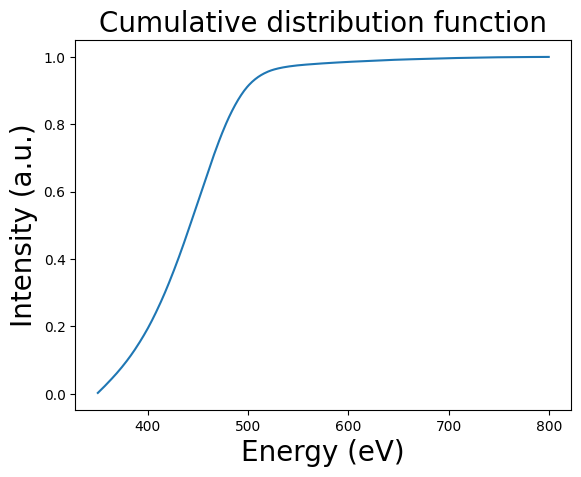

In [ ]:
# # plt = pretty_plot(8,6)
# plt.plot(xaxis, cdf)
# # plt.xticks(xaxis, [int(i) for i in xaxis])
# plt.xlabel("Energy (eV)", fontsize=20)
# plt.ylabel("Intensity (a.u.)", fontsize=20)
# plt.title("Cumulative distribution function", fontsize=20)

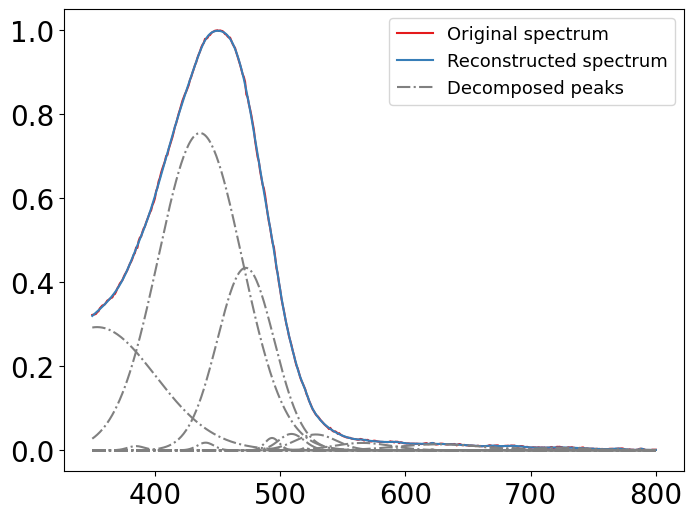

In [ ]:
# Visualization for peak fitting
plt = pretty_plot(8, 6)
plt.plot(xaxis, intensity, label="Original spectrum")
plt.plot(
    xaxis,
    func_unfix_width_reg(xaxis, *peak_feature),
    label="Reconstructed spectrum",
)
for i in range(0, len(peak_feature), 3):
    ctr = peak_feature[i]
    amp = peak_feature[i + 1]
    wid = peak_feature[i + 2]
    y = amp * np.exp(-((xaxis - ctr) ** 2 / (2 * (wid / 2) ** 2)))
    plt.plot(xaxis, y, linestyle='-.', color='grey')
plt.plot(xaxis, y, linestyle='-.', color='grey', label='Decomposed peaks')
# plt.xticks(xaxis, [int(i) for i in xaxis])
plt.legend(loc="best", fontsize=13)
# plt.xlabel("Energy (eV)", fontsize=20)
# plt.ylabel("Intensity (a.u.)", fontsize=20)
# plt.title("Peak feature", fontsize=20)

# Calculation of rdkit 3d descriptors

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors3D


def get_rdkit_3D_descr(smiles):
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    pmi1, pmi2, pmi3 = (
        Descriptors3D.PMI1(mol),
        Descriptors3D.PMI2(mol),
        Descriptors3D.PMI3(mol),
    )
    radius_of_gyration = Descriptors3D.RadiusOfGyration(mol)
    spherocity_index = Descriptors3D.SpherocityIndex(mol)
    asphericity = Descriptors3D.Asphericity(mol)
    eccentricity = Descriptors3D.Eccentricity(mol)
    intertia_shape_factor = Descriptors3D.InertialShapeFactor(mol)
    # pbf = Descriptors3D.PBF(mol)
    return (
        pmi1,
        pmi2,
        pmi3,
        radius_of_gyration,
        spherocity_index,
        asphericity,
        eccentricity,
        intertia_shape_factor,
    )  # , pbf

In [ ]:
def update_dataframe(new_data, dataframe):
    return dataframe.append(new_data, ignore_index=True)

In [ ]:
# three_dim_descr.to_csv('rdkit_3d_descr.csv', index=None) #['smiles'] = dft_descr.smiles.values

In [ ]:
import pandas as pd

# Initialize an empty DataFrame
three_dim_descr = pd.DataFrame(
    columns=[
        "pmi1",
        "pmi2",
        "pmi3",
        "radius_of_gyration",
        "spherocity_index",
        "asphericity",
        "eccentricity",
        "intertia_shape_factor",
    ]
)

# Loop through each SMILES string and append the results to the DataFrame
for smile in dft_descr.smiles.values:
    descr_values = get_rdkit_3D_descr(smile)
    row_to_append = pd.Series(descr_values, index=three_dim_descr.columns)
    three_dim_descr = three_dim_descr.append(row_to_append, ignore_index=True)

# Show the updated DataFrame
three_dim_descr

In [ ]:
three_dim_descr = pd.DataFrame(
    {
        "pmi1": [],
        "pmi2": [],
        "pmi3": [],
        "radius_of_gyration": [],
        "spherocity_index": [],
        "asphericity": [],
        "eccentricit": [],
        "intertia_shape_factor": [],
    }
)
three_dim_descr
for smile in dft_descr.smiles.values:
    (
        pmi1,
        pmi2,
        pmi3,
        radius_of_gyration,
        spherocity_index,
        asphericity,
        eccentricity,
        intertia_shape_factor,
    ) = get_rdkit_3D_descr(smile)
    update_dataframe(
        [
            pmi1,
            pmi2,
            pmi3,
            radius_of_gyration,
            spherocity_index,
            asphericity,
            eccentricity,
            intertia_shape_factor,
        ],
        three_dim_descr,
    )
three_dim_descr

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors3D

# Example SMILES string for demonstration; replace with your molecule's SMILES
smiles = "CCO"

# Convert the SMILES string to an RDKit molecule object and add hydrogens
mol = Chem.AddHs(Chem.MolFromSmiles(smiles))

# Generate 3D coordinates for the molecule
AllChem.EmbedMolecule(mol, AllChem.ETKDG())

# Calculate specific 3D descriptors
pmi1, pmi2, pmi3 = (
    Descriptors3D.PMI1(mol),
    Descriptors3D.PMI2(mol),
    Descriptors3D.PMI3(mol),
)
radius_of_gyration = Descriptors3D.RadiusOfGyration(mol)
spherocity_index = Descriptors3D.SpherocityIndex(mol)

# Print the calculated 3D descriptors
print(f"PMI1: {pmi1}, PMI2: {pmi2}, PMI3: {pmi3}")
print(f"Radius of Gyration: {radius_of_gyration}")
print(f"Spherocity Index: {spherocity_index}")

PMI1: 14.311188643100525, PMI2: 52.63368731909339, PMI3: 60.36991087628147
Radius of Gyration: 1.1754929617502576
Spherocity Index: 0.44902054323419993


In [ ]:
# function to calculate rdkit_3D _descriptors

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors3D

# from rdkit.Chem.Descriptors3D import CalcMolDescriptors3D

# Example SMILES string for demonstration; replace with your molecule's SMILES
smiles = "CCO"

# Convert the SMILES string to an RDKit molecule object
mol = Chem.MolFromSmiles(smiles)

# Add hydrogens to the molecule
mol = Chem.AddHs(mol)

# Generate 3D coordinates for the molecule
AllChem.EmbedMolecule(mol, AllChem.ETKDG())

# Calculate 3D descriptors
descriptors = Descriptors3D.CalcMolDescriptors3D(mol)

# Print the calculated 3D descriptors
print(descriptors)

AttributeError: module 'rdkit.Chem.Descriptors3D' has no attribute 'CalcMolDescriptors3D'

# Data analysis

In [ ]:
feature_columns = [
    'smiles_A',
    'Percentage of A %',
    'smiles_B',
    'Percentage of B %',
    'smiles_C',
    'Percentage of C %',
    'num_monomers',
    'L* (Colored State)',
    'a* (Colored State)',
    'b*(Colored State)',
    'peak_loc1',
    'peak_loc2',
    'peak_loc3',
    'HWHM1',
    'HWHM2',
    'HWHM3',
    'intensities1',
    'intensities2',
    'intensities3',
    'wavelength',
    'intensity',
    'peak_location',
    'HWHM',
    'intensities',
]


ratio_properties = [
    'Percentage of A %',
    'Percentage of B %',
    'Percentage of C %',
]

molecule_feature_columns = [
    'smiles_A',
    'Percentage of A %',
    'smiles_B',
    'Percentage of B %',
    'smiles_C',
    'Percentage of C %',
    'num_monomers',
    'L* (Colored State)',
    'a* (Colored State)',
    'b*(Colored State)',
]

colour_feature_columns = [
    'L* (Colored State)',
    'a* (Colored State)',
    'b*(Colored State)',
]

abs_feature_columns = [
    'peak_loc1',
    'peak_loc2',
    'peak_loc3',
    'HWHM1',
    'HWHM2',
    'HWHM3',
    'intensities1',
    'intensities2',
    'intensities3',
    'r',
    'theta',
    'L* (Colored State)',
    'a* (Colored State)',
    'b*(Colored State)',
]

In [ ]:
data_all = pd.concat(
    [data_lit[feature_columns], data_inhouse[feature_columns]], axis=0
).reset_index()

In [ ]:
# Import the descriptors dictionaries

rdkit_threeD_descr = pd.read_csv('rdkit_3d_descr.csv')
threeD_descr = pd.read_csv('/content/mordred_3d_descriptors.csv')
dft_descr = pd.read_csv('/content/dft_descriptors_ECPs.csv')

In [ ]:
import math


def cartesian_to_polar(x, y):
    """Convert a single Cartesian coordinate (x, y) to polar (r, theta)."""
    r = math.sqrt(x**2 + y**2)
    theta = math.atan2(y, x)
    return r  # theta #


# Lists of x and y coordinates
x_list = data_all['a* (Colored State)'].values
y_list = data_all['b*(Colored State)'].values

# Convert each pair of x, y coordinates to polar coordinates
polar_coordinates = [cartesian_to_polar(x, y) for x, y in zip(x_list, y_list)]

In [ ]:
data_all['r'] = polar_coordinates
data_all

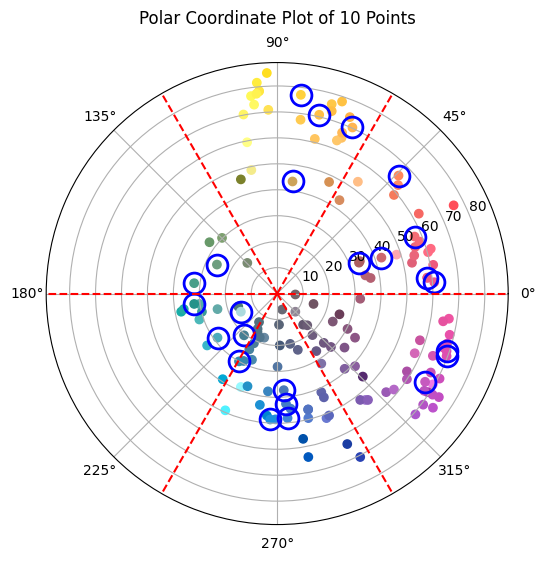

In [ ]:
# Create a polar plot
plt.figure(figsize=(8, 6))
ax = plt.subplot(111, polar=True)  # Create a polar subplot

# Plot the points
ax.scatter(data_all.theta.values, data_all.r.values, c=color_list)

# Add empty circles around the chosen points
for t, rad in zip(
    represetnative_points.theta.values, represetnative_points.r.values
):
    ax.plot(t, rad, 'o', mfc='none', mec='blue', markersize=15, mew=2)

# ax.scatter(selected_points_df.theta.values, selected_points_df.r.values, c=None, marker='o')


# angles_degrees = [22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5]
angles_degrees = [0, 60, 120, 180, 240, 300]
angles_radians = np.deg2rad(angles_degrees)

# Add lines at the specified angles
for angle in angles_radians:
    ax.axvline(x=angle, color='red', linestyle='--')
# Set labels
# ax.set_rlabel_position(-22.5)  # Position of radial labels
plt.title('Polar Coordinate Plot of 10 Points', va='bottom')

# Display the plot
plt.show()

In [ ]:
def get_dft_descriptors_dictionary(dft_calculations_file):
    # create a dictionary to assign the molecular features to each of the smiles stings
    data_dft = pd.read_csv(dft_calculations_file)
    data_dft = data_dft.drop(
        [
            'stoichiometry',
            'number_of_atoms',
            'charge',
            'multiplicity',
            'E_scf',
            'zero_point_correction',
            'E_thermal_correction',
            'H_thermal_correction',
            'G_thermal_correction',
            'E_zpe',
            'E',
            'H',
            'converged',  #'ES_<S**2>',
            'G',
        ],
        axis=1,
    )
    scaler = MinMaxScaler()

    cols_to_scale = data_dft.columns[1:]

    data_dft[cols_to_scale] = scaler.fit_transform(data_dft[cols_to_scale])

    dictionary = data_dft.set_index('smiles').agg(list, axis=1).to_dict()
    return dictionary, data_dft.columns.values[1:]

In [ ]:
# create a dictionary to assign the molecular features to each of the smiles stings
dictionary, descriptor_names = get_dft_descriptors_dictionary(
    '/content/dft_descriptors_ECPs.csv'
)
# dictionary

In [ ]:
def smile_to_dft(smile):
    return dictionary[smile]


def dft_descr(smiles):
    bits = []
    for smile in smiles:
        try:
            bits.append(np.asarray(smile_to_dft(smile)))
        except:
            bits.append(np.zeros(len(descriptor_names)))
    return bits


def dft_descr_from_df(smiles, prefix):
    df = pd.DataFrame(dft_descr(smiles))

    df.columns = [
        f'{prefix}_{i}' for i in descriptor_names
    ]  # descriptor_names
    return df

In [ ]:
def get_3d_rdkit_descriptors_dictionary(descriptors_calculations_file):
    # create a dictionary to assign the molecular features to each of the smiles stings
    data_dft = pd.read_csv(descriptors_calculations_file)
    # data_dft = data_dft.drop(['stoichiometry','number_of_atoms','charge','multiplicity', 'E_scf', 'zero_point_correction', 'E_thermal_correction',
    #     'H_thermal_correction', 'G_thermal_correction', 'E_zpe', 'E', 'H','converged',#'ES_<S**2>',
    #     'G', ], axis=1)
    scaler = MinMaxScaler()

    cols_to_scale = data_dft.columns[1:]

    data_dft[cols_to_scale] = scaler.fit_transform(data_dft[cols_to_scale])

    dictionary = data_dft.set_index('smiles').agg(list, axis=1).to_dict()
    return dictionary, data_dft.columns.values[:-1]

In [ ]:
explainable_descr = [
    'nAcid',
    'nBase',
    'nAromAtom',
    'nAromBond',
    'nAtom',
    'nHeavyAtom',
    'nHetero',
    'nH',
    'nB',
    'nC',
    'nN',
    'nO',
    'nS',
    'nP',
    'nF',
    'nCl',
    'nBr',
    'VMcGowan',
    'Lipinsk',
    'apol',
    'bpol',
    'nRing',
    'n5Ring',
    'n6Ring',
    'nHRing',
    'nRot',
    'RotRatio',
    'SLogP',
    'TopoPSA(NO)',
    'TopoPSA',
    'Vabc',
    'Diameter',
    'Radius',
    'Vabc',
    'MW',
]

In [ ]:
df8 = pd.read_csv('/content/mordred_3d_clenaned_descriptors.csv')
# df8[df8.columns.isin(explainable_descr)]

pd.concat(
    [df8['smiles'], df8[[c for c in df8.columns if c in explainable_descr]]],
    axis=1,
).to_csv('mordred_all_important.csv', index=None)

In [ ]:
dictionary_3d_rdkit, descriptor_names_3d = get_3d_rdkit_descriptors_dictionary(
    '/content/mordred_all_important.csv'
)  # ('/content/rdkit_3d_descr.csv')
# dictionary_3d_rdkit

In [ ]:
def smile_to_dft(smile):
    return dictionary_3d_rdkit[smile]


def dft_descr(smiles):
    bits = []
    for smile in smiles:
        try:
            bits.append(np.asarray(smile_to_dft(smile)))
        except:
            bits.append(np.zeros(len(descriptor_names_3d)))
    return bits


def dft_descr_from_df(smiles, prefix):
    df = pd.DataFrame(dft_descr(smiles))

    df.columns = [
        f'{prefix}_{i}' for i in descriptor_names_3d
    ]  # descriptor_names
    return df

In [ ]:
data_all['smiles_A'] = data_all['smiles_A'].str.replace('*', 'C')
data_all['smiles_B'] = data_all['smiles_B'].str.replace('*', 'C')
data_all['smiles_C'] = data_all['smiles_C'].str.replace('*', 'C')

<ipython-input-180-d7f4426904a8>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_all['smiles_A'] = data_all['smiles_A'].str.replace('*', 'C')
<ipython-input-180-d7f4426904a8>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_all['smiles_B'] = data_all['smiles_B'].str.replace('*', 'C')
<ipython-input-180-d7f4426904a8>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_all['smiles_C'] = data_all['smiles_C'].str.replace('*', 'C')


In [ ]:
df1_dft = dft_descr_from_df(data_all.smiles_A, 'A')
df2_dft = dft_descr_from_df(data_all.smiles_B, 'B')
df3_dft = dft_descr_from_df(data_all.smiles_C, 'C')

In [ ]:
dataset = pd.concat([df1_dft, df2_dft, df3_dft], axis=1)  #
dataset  # .dropna(axis=0)#.shape #.head()
dataset = dataset.loc[:, (dataset != 0).any(axis=0)]
dataset = dataset.loc[:, dataset.nunique() != 1]
dataset

A_nAromBond   A_nAtom  A_nHeavyAtom  A_nHetero      A_nB      A_nN  \
0       0.575221  0.609756      0.555556   0.555556  0.567568  0.666667   
1       0.575221  0.609756      0.555556   0.555556  0.567568  0.666667   
2       0.442478  0.439024      0.333333   0.444444  0.432432  0.333333   
3       0.442478  0.439024      0.333333   0.444444  0.432432  0.333333   
4       0.442478  0.439024      0.333333   0.444444  0.432432  0.333333   
..           ...       ...           ...        ...       ...       ...   
149     0.575221  0.609756      0.555556   0.555556  0.567568  0.666667   
150     0.575221  0.609756      0.555556   0.555556  0.567568  0.666667   
151     0.575221  0.609756      0.555556   0.555556  0.567568  0.666667   
152     0.575221  0.609756      0.555556   0.555556  0.567568  0.666667   
153     0.575221  0.609756      0.555556   0.555556  0.567568  0.666667   

        A_nBr  A_VMcGowan    A_apol  A_bpol  ...  C_n6Ring  C_nHRing  C_nRot  \
0    0.577788    0.574740  0.596845     0.2  ...       0.0       0.0     0.0   
1    0.577788    0.574740  0.596845     0.2  ...       0.0       0.0     0.0   
2    0.444199    0.439454  0.452454     0.0  ...       0.0       0.0     0.0   
3    0.444199    0.439454  0.452454     0.0  ...       0.0       0.0     0.0   
4    0.444199    0.439454  0.452454     0.0  ...       0.0       0.0     0.0   
..        ...         ...       ...     ...  ...       ...       ...     ...   
149  0.577788    0.574740  0.596845     0.2  ...       0.4       0.0     0.0   
150  0.577788    0.574740  0.596845     0.2  ...       0.4       0.0     0.0   
151  0.577788    0.574740  0.596845     0.2  ...       0.4       0.0     0.0   
152  0.577788    0.574740  0.596845     0.2  ...       0.4       0.0     0.0   
153  0.577788    0.574740  0.596845     0.2  ...       0.4       0.0     0.0   

     C_RotRatio  C_SLogP  C_TopoPSA(NO)  C_TopoPSA  C_Diameter  C_Radius  \
0      0.000000  0.00000       0.000000   0.000000    0.000000  0.000000   
1      0.000000  0.00000       0.000000   0.000000    0.000000  0.000000   
2      0.000000  0.00000       0.000000   0.000000    0.000000  0.000000   
3      0.000000  0.00000       0.000000   0.000000    0.000000  0.000000   
4      0.000000  0.00000       0.000000   0.000000    0.000000  0.000000   
..          ...      ...            ...        ...         ...       ...   
149    0.079104  0.25978       0.316782   0.045455    0.090909  0.060076   
150    0.079104  0.25978       0.316782   0.045455    0.090909  0.060076   
151    0.079104  0.25978       0.316782   0.045455    0.090909  0.060076   
152    0.079104  0.25978       0.316782   0.045455    0.090909  0.060076   
153    0.079104  0.25978       0.316782   0.045455    0.090909  0.060076   

       C_Vabc  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.000000  
4    0.000000  
..        ...  
149  0.109057  
150  0.109057  
151  0.109057  
152  0.109057  
153  0.109057  

[154 rows x 72 columns]

In [ ]:
dataset.columns.values[:20]

array(['A_nAromBond', 'A_nAtom', 'A_nHeavyAtom', 'A_nHetero', 'A_nB',
       'A_nN', 'A_nBr', 'A_VMcGowan', 'A_apol', 'A_bpol', 'A_n6Ring',
       'A_nHRing', 'A_nRot', 'A_RotRatio', 'A_SLogP', 'A_TopoPSA(NO)',
       'A_TopoPSA', 'A_Diameter', 'A_Radius', 'A_Vabc'], dtype=object)

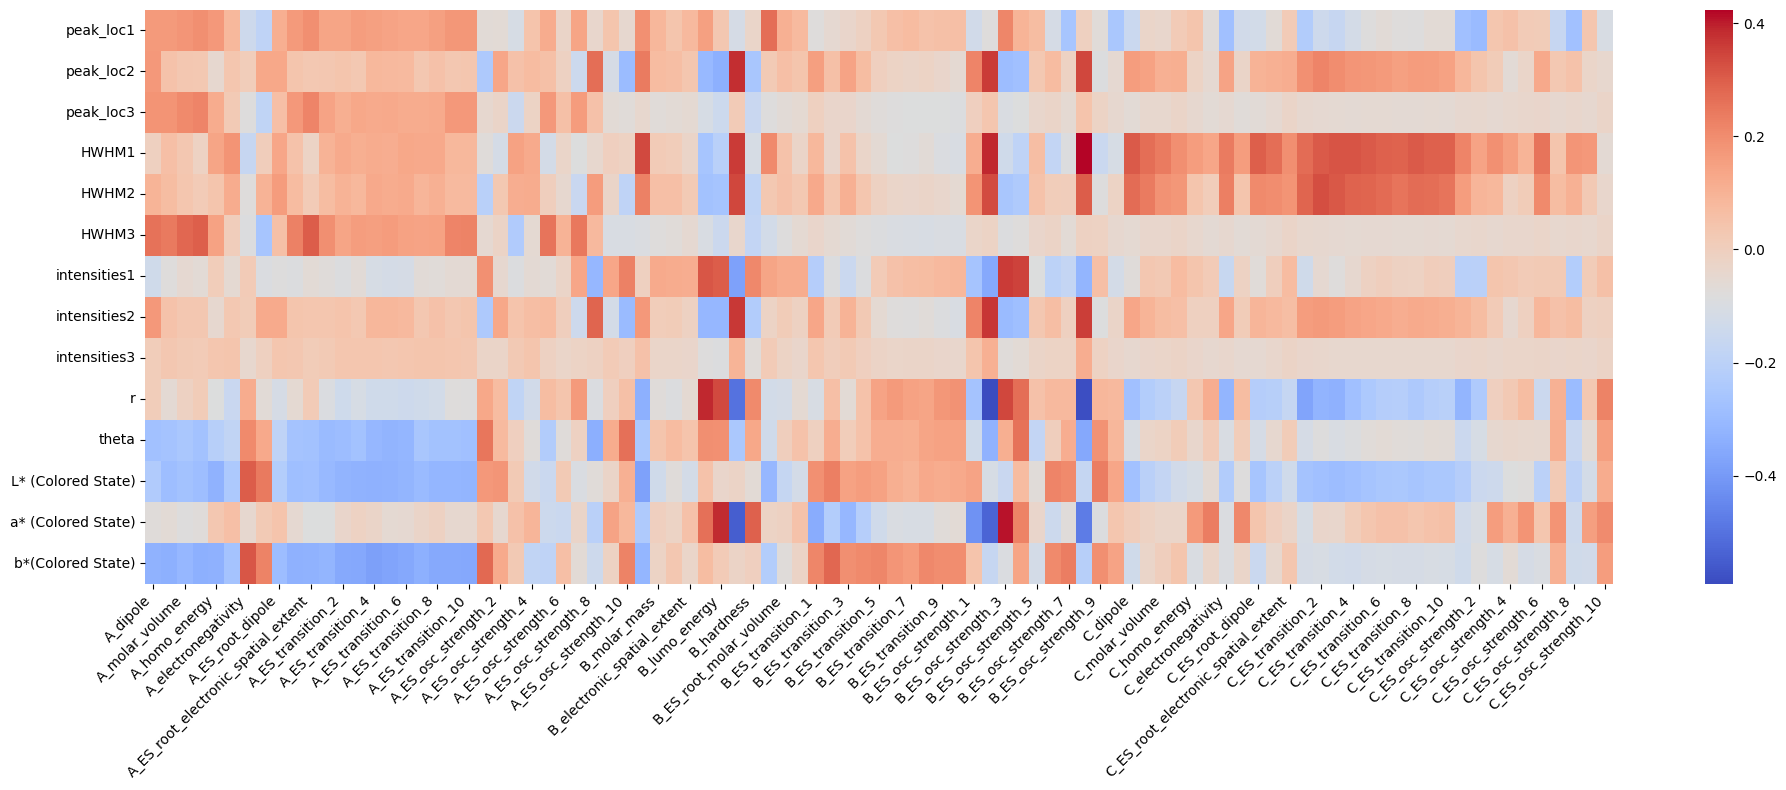

In [ ]:
# Generating synthetic data for 24 features and 3 properties

features_data = dataset
properties_data = data_all[abs_feature_columns]

# Combining the features and properties into a single DataFrame
combined_data = pd.concat([features_data, properties_data], axis=1)

# Calculating correlation between features and properties
correlations = combined_data.corr().iloc[-14:, :-14]

# Plotting
plt.figure(figsize=(20, 8))
sns.heatmap(correlations, annot=False, cmap='coolwarm', cbar=True, fmt=".2f")
# plt.title("Correlation of Features with Properties")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
correlation_df = pd.concat([dataset, data_all[abs_feature_columns]], axis=1)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Plotting the reduced correlation matrix
plt.figure(figsize=(10, 8))
# sns.heatmap(reduced_corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
# plt.title('Reduced Correlation Matrix (Correlation > 0.1 with Target)')
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True)  # ,
#  cbar_kws={'shrink': .82}, linewidths=.1, linecolor='gray')
# plt.savefig('cor_matrix.svg')
plt.show()

NameError: name 'correlation_df' is not defined

In [ ]:
data_lit[abs_feature_columns]

peak_loc1  peak_loc2  peak_loc3       HWHM1  HWHM2  HWHM3  intensities1  \
0   448.000000      642.0        0.0  367.000000  290.0    0.0      0.516553   
1   420.000000      685.0        0.0   74.000000  154.0    0.0      0.352916   
2   452.000000      610.0        0.0  107.000000   92.0    0.0      0.492339   
3   469.000000      581.0        0.0  213.000000  179.0    0.0      0.694872   
4   474.000000      567.0        0.0  194.000000  193.0    0.0      0.958105   
..         ...        ...        ...         ...    ...    ...           ...   
81  445.000000      605.0        0.0  337.000000  314.0    0.0      0.758134   
82  319.554052        0.0        0.0   54.392616    0.0    0.0      0.338346   
83  430.000000      597.0        0.0  185.000000  334.0    0.0      0.989574   
84  419.000000      588.0      733.0  355.000000  176.0   20.0      0.996297   
85  406.000000      568.0        0.0  308.000000  152.0    0.0      0.928381   

    intensities2  intensities3  
0       0.994036      0.000000  
1       0.991306      0.000000  
2       1.012859      0.000000  
3       0.992548      0.000000  
4       1.000176      0.000000  
..           ...           ...  
81      0.998519      0.000000  
82      0.000000      0.000000  
83      0.702272      0.000000  
84      0.761044      0.253895  
85      0.595566      0.000000  

[86 rows x 9 columns]

In [ ]:
dictionary_mordred = pd.read_csv(
    '/content/mordred_3d_clenaned_descriptors.csv'
)
# dictionary_mordred

In [ ]:
def smile_to_dft(smile):
    return dictionary[smile]


def dft_descr(smiles):
    bits = []
    for smile in smiles:
        try:
            bits.append(np.asarray(smile_to_dft(smile)))
        except:
            bits.append(np.zeros(len(descriptor_names)))
    return bits


def dft_descr_from_df(smiles, prefix):
    df = pd.DataFrame(dft_descr(smiles))

    df.columns = [
        f'{prefix}_{i}' for i in descriptor_names
    ]  # descriptor_names
    return df

In [ ]:
def get_train_data_representation_dft(dataframe):
    """Given the dataframe with the experimental results, i.e., smiles + ratios + extracted Lab values
    return the finger print representation"""
    df1 = bits_to_df(dataframe.smiles2, 'bit_1')
    df2 = bits_to_df(dataframe.smiles2, 'bit_2')
    df3 = bits_to_df(dataframe.smiles3, 'bit_3')
    df1_dft = dft_descr_from_df(dataframe.smiles1, 'bit_1')
    df2_dft = dft_descr_from_df(dataframe.smiles2, 'bit_2')
    df3_dft = dft_descr_from_df(dataframe.smiles3, 'bit_3')
    percentage_1 = dataframe.percentage_1
    percentage_2 = dataframe.percentage_2
    percentage_3 = dataframe.percentage_3
    dataset = pd.concat(
        [
            df1,
            df1_dft,
            pd.DataFrame(
                dataframe[['percentage_1']].values, columns=['percentage_1']
            ),
            df2,
            df2_dft,
            pd.DataFrame(
                dataframe[['percentage_2']].values, columns=['percentage_2']
            ),
            df3,
            df3_dft,
            pd.DataFrame(
                dataframe[['percentage_3']].values, columns=['percentage_3']
            ),
        ],
        axis=1,
    )
    return dataset

# Get colour partitions

In [ ]:
data_all

index                                        smiles_A  Percentage of A %  \
0        0      *c1sc(*)c2OCC(COCCCCCCCC)(COCCCCCCCC)COc12               67.0   
1        1      *c1sc(*)c2OCC(COCCCCCCCC)(COCCCCCCCC)COc12               67.0   
2        2             *c1sc(*)c(OCC(CC)CCCC)c1OCC(CC)CCCC               67.0   
3        3             *c1sc(*)c(OCC(CC)CCCC)c1OCC(CC)CCCC               80.0   
4        4             *c1sc(*)c(OCC(CC)CCCC)c1OCC(CC)CCCC               86.0   
..     ...                                             ...                ...   
149     63  *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12               50.0   
150     64  *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12               60.0   
151     65  *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12               50.0   
152     66  *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12               50.0   
153     67  *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12               50.0   

                                            smiles_B  Percentage of B %  \
0                *c4ccc(c2ccc(c1ccc(*)s1)c3nsnc23)s4               33.0   
1    *c5sc(c3ccc(c2sc(*)c1OCCOc12)c4nsnc34)c6OCCOc56               33.0   
2                                  *c1ccc(*)c2nsnc12               33.0   
3                                  *c1ccc(*)c2nsnc12               20.0   
4                                  *c1ccc(*)c2nsnc12               14.0   
..                                               ...                ...   
149                                  C1=CC(=CC=C1*)*               10.0   
150                                  C1=CC(=CC=C1*)*               20.0   
151                                *c1sc(*)c(OC)c1OC               20.0   
152                                *c1sc(*)c(OC)c1OC               30.0   
153                                *c1sc(*)c(OC)c1OC               40.0   

              smiles_C  Percentage of C %  num_monomers  L* (Colored State)  \
0                    0                0.0             2           59.000000   
1                    0                0.0             2           66.000000   
2                    0                0.0             2           64.000000   
3                    0                0.0             2           57.000000   
4                    0                0.0             2           52.000000   
..                 ...                ...           ...                 ...   
149  *c1sc(*)c2OCCOc12               40.0             3           51.604901   
150  *c1sc(*)c2OCCOc12               20.0             3           59.610230   
151  *c1sc(*)c2OCCOc12               30.0             3           51.672199   
152  *c1sc(*)c2OCCOc12               20.0             3           52.648164   
153  *c1sc(*)c2OCCOc12               10.0             3           53.559747   

     a* (Colored State)  b*(Colored State)  peak_loc1  peak_loc2  peak_loc3  \
0            -29.000000          -7.000000      448.0      642.0        0.0   
1            -30.000000          -4.000000      420.0      685.0        0.0   
2            -37.000000          -7.000000      452.0      610.0        0.0   
3              7.000000          -7.000000      469.0      581.0        0.0   
4             34.000000           7.000000      474.0      567.0        0.0   
..                  ...                ...        ...        ...        ...   
149           56.266195         -42.822702      447.0      479.0        0.0   
150           60.543728           4.374281      478.0        0.0        0.0   
151           53.271125         -46.562860      586.0        0.0        0.0   
152           56.676883         -37.478203      608.0        0.0        0.0   
153           59.192054         -30.431437      618.0        0.0        0.0   

     HWHM1  HWHM2  HWHM3  intensities1  intensities2  intensities3  
0    367.0  290.0    0.0      0.516553      0.994036           0.0  
1     74.0  154.0    0.0      0.352916      0.991306           0.0  
2    107.0   92.0    0.0  

In [ ]:
electrochromics = pd.read_csv(
    '/content/electrochromics_in_house_experiments.csv'
)  # ('/content/electrochromics_literature_only.csv')
# electrochromics = electrochromics.rename(columns={ 'smiles_A': 'smiles1', 'smiles_B': 'smiles2',
#                               'smiles_C': 'smiles3',  'Percentage of A %': 'percentage_1',
#                               'Percentage of B %': 'percentage_2',  'Percentage of C %': 'percentage_3',
#                               }) #'L': 'L* (Colored State)', 'a': 'a* (Colored State)', 'b': 'b*(Colored State)'

electrochromics = electrochromics.rename(
    columns={
        'L': 'L* (Colored State)',
        'a': 'a* (Colored State)',
        'b': 'b*(Colored State)',
    }
)  #


electrochromics['smiles1'] = electrochromics['smiles1'].str.replace('*', 'C')
electrochromics['smiles2'] = electrochromics['smiles2'].str.replace('*', 'C')
electrochromics['smiles3'] = electrochromics['smiles3'].str.replace('*', 'C')

df = electrochromics[electrochromics.num_monomers != 1]
df = df[
    [
        'smiles1',
        'percentage_1',
        'smiles2',
        'percentage_2',
        'smiles3',
        'percentage_3',
        'L* (Colored State)',
        'a* (Colored State)',
        'b*(Colored State)',
    ]
]
df['percentage_1'] = df['percentage_1'] / 100
df['percentage_2'] = df['percentage_2'] / 100
df['percentage_3'] = df['percentage_3'] / 100
df = df.dropna(axis=0)

<ipython-input-52-9da32ca771b6>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  electrochromics['smiles1'] = electrochromics['smiles1'].str.replace('*', 'C')
<ipython-input-52-9da32ca771b6>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  electrochromics['smiles2'] = electrochromics['smiles2'].str.replace('*', 'C')
<ipython-input-52-9da32ca771b6>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  electrochromics['smiles3'] = electrochromics['smiles3'].str.replace('*', 'C')


In [ ]:
# Scale the Lab values of the literature dataset
data_all = electrochromics.dropna()
df_y = data_all[
    ['L* (Colored State)', 'a* (Colored State)', 'b*(Colored State)']
]
# scalery = MinMaxScaler().fit(df_y.values)
# literature_lab_scaled = scalery.transform(df_y)

In [ ]:
L = data_all['L* (Colored State)'].dropna().values
a_ = data_all['a* (Colored State)'].dropna().values
b_ = data_all['b*(Colored State)'].dropna().values

In [ ]:
from colormath.color_objects import LabColor, XYZColor, sRGBColor
from colormath.color_conversions import convert_color

y_pred = list(zip(L, a_, b_))
color_list = []

for i in range(len(y_pred)):
    lab_list = list(y_pred[i])
    a = ', '.join(str(item) for item in list(y_pred[i]))
    lab = LabColor(
        lab_l=lab_list[0],
        lab_a=lab_list[1],
        lab_b=lab_list[2],
        observer='2',
        illuminant='d65',
    )
    xyz = convert_color(lab, sRGBColor)
    try:
        c = Color(
            rgb=(xyz.clamped_rgb_r, xyz.clamped_rgb_g, xyz.clamped_rgb_b)
        )
        color_list.append(str(c))
    except:
        color_list.append(0)

In [ ]:
len(color_list)
len(a_)

69

In [ ]:
# theta = 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5.
df_y.shape

(69, 3)

In [ ]:
import numpy as np


def dominant_hue(color):
    """
    Calculate the dominant hue of a Lab color.
    """
    a, b = color[1], color[2]
    hue = np.arctan2(b, a) * 180 / np.pi
    if hue < 0:
        hue += 360
    return hue


def divide_color_palette(palette):
    """
    Divide the color palette into basic color regions.
    """
    color_regions = {
        'red': [],
        'green': [],
        'blue': [],
        'cyan': [],
        'magenta': [],
        'orange': [],
        'yellow': [],
    }
    for idx, color in enumerate(palette):
        hue = dominant_hue(color)
        if hue >= 0 and hue < 60:
            color_regions['red'].append(idx)
        elif hue >= 60 and hue < 90:
            color_regions['orange'].append(idx)
        elif hue >= 90 and hue < 120:
            color_regions['yellow'].append(idx)
        elif hue >= 120 and hue < 180:
            color_regions['green'].append(idx)
        elif hue >= 180 and hue < 240:
            color_regions['cyan'].append(idx)
        elif hue >= 240 and hue < 300:
            color_regions['blue'].append(idx)
        elif hue >= 300 and hue < 360:
            color_regions['magenta'].append(idx)
        else:
            color_regions['red'].append(idx)  # Handle edge case near red
    return color_regions


# Example usage
color_palette = df_y.values
divided_colors = divide_color_palette(color_palette)

# Print the colors in each region
for region, colors in divided_colors.items():
    print(f"{region}: {colors}")

red: [2, 3, 6, 7, 8, 9, 10, 24, 34, 35, 36, 45, 46, 47, 52, 56, 64]
green: []
blue: [11, 12, 13, 14, 23, 25, 26, 27, 29, 30, 31, 32, 33, 39, 40, 41, 42, 43, 55, 59, 60, 61]
cyan: [44]
magenta: [4, 5, 15, 16, 17, 18, 19, 20, 21, 22, 28, 37, 38, 48, 51, 53, 54, 57, 58, 63, 65, 66, 67, 68]
orange: [1, 49, 50, 62]
yellow: [0]


In [ ]:
import numpy as np


# Function to calculate the angle in degrees from the origin
def angle_from_origin(x, y):
    radians = np.arctan2(y, x)
    degrees = np.degrees(radians)
    return degrees % 360


# Angles defining partitions
partition_angles = [60, 90, 120, 180, 240, 300, 360]

# Calculate angles for each point and determine partitions
points_partition = []
for x, y in zip(a_, b_):
    point_angle = angle_from_origin(x, y)
    partition = None
    for i, angle in enumerate(partition_angles):
        if point_angle <= angle:
            partition = i
            break
    points_partition.append(partition)

print(points_partition)

[2, 1, 0, 0, 6, 6, 0, 0, 0, 0, 0, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 0, 5, 5, 5, 6, 5, 5, 5, 5, 5, 0, 0, 0, 6, 6, 5, 5, 5, 5, 5, 4, 0, 0, 0, 6, 1, 1, 6, 0, 6, 6, 5, 0, 6, 6, 5, 5, 5, 1, 6, 0, 6, 6, 6, 6]


In [ ]:
data_all['color_partition'] = points_partition

In [ ]:
# Replacement mapping
replacement_mapping = {
    0: 'red',
    1: 'orange',
    2: 'yellow',
    3: 'green',
    4: 'cyan',
    5: 'blue',
    6: 'magenta',
}

# Apply the replacement
data_all['color_partition'] = data_all['color_partition'].replace(
    replacement_mapping
)

In [ ]:
from collections import Counter

Counter(data_all.color_partition.values)

Counter({'yellow': 1,
         'orange': 4,
         'red': 17,
         'magenta': 24,
         'blue': 22,
         'cyan': 1})

In [ ]:
len(set(data_all.color_partition.values))

6

In [ ]:
sdl_exp = pd.read_csv('/content/closeloop_all_past_experiments.csv')
# sdl_exp

In [ ]:
from colormath.color_objects import LabColor, XYZColor, sRGBColor
from colormath.color_conversions import convert_color

sdl_L, sdl_a, sdl_b = sdl_exp['L_exp'], sdl_exp['a_exp'], sdl_exp['b_exp']

y_pred = list(zip(sdl_L, sdl_a, sdl_b))
color_list_sdl = []

for i in range(len(y_pred)):
    lab_list = list(y_pred[i])
    a = ', '.join(str(item) for item in list(y_pred[i]))
    lab = LabColor(
        lab_l=lab_list[0],
        lab_a=lab_list[1],
        lab_b=lab_list[2],
        observer='2',
        illuminant='d65',
    )
    xyz = convert_color(lab, sRGBColor)
    try:
        c = Color(
            rgb=(xyz.clamped_rgb_r, xyz.clamped_rgb_g, xyz.clamped_rgb_b)
        )
        color_list_sdl.append(str(c))
    except:
        pass

In [ ]:
expected_green = []
y_pred = [80, -20, 40]
lab = LabColor(lab_l=80, lab_a=-20, lab_b=40, observer='2', illuminant='d65')
xyz = convert_color(lab, sRGBColor)
expected_green = Color(
    rgb=(xyz.clamped_rgb_r, xyz.clamped_rgb_g, xyz.clamped_rgb_b)
)

In [ ]:
expected_green

<Color #bbcf7a>

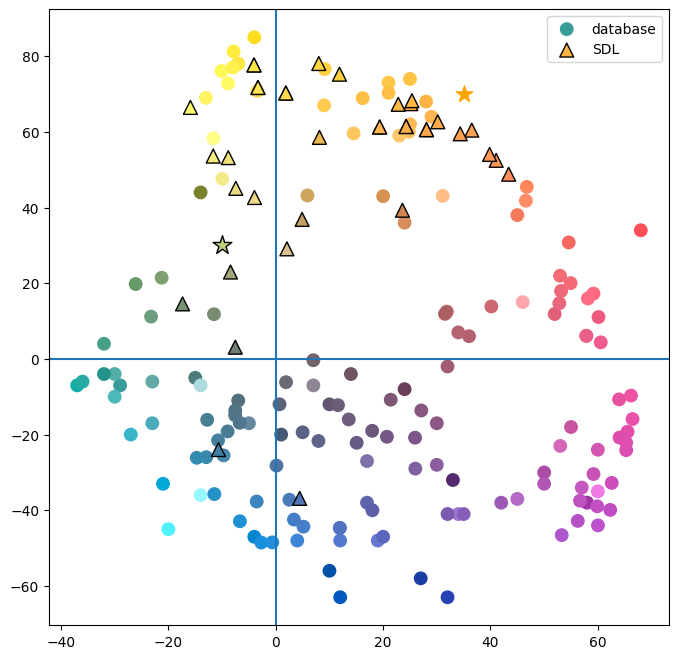

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.axvline(x=0)
ax.axhline(y=0)
ax.scatter(-10, 30, marker='*', s=200, color='#bbcf7a', edgecolor='black')
ax.scatter(35, 70, marker='*', s=150, color='orange')

ax.scatter(a_, b_, c=color_list, s=80, label='database')
ax.scatter(
    sdl_a,
    sdl_b,
    c=color_list_sdl,
    marker='^',
    s=100,
    edgecolor='black',
    label='SDL',
)

# ax.scatter(exp_batches_a, exp_batches_b, c=color_list_exp, marker='^', edgecolors='black', s=80, label='experimental batches')
plt.legend()

In [ ]:
import pandas as pd
import numpy as np


# Function to select two points with different 'num_monomers' within a partition
def select_diverse_points(df):
    if df['num_monomers'].nunique() > 1:
        # Select one point with 'num_monomers' = 2 and another with 'num_monomers' = 3
        point_2 = df[df['num_monomers'] == 2].sample(
            3, random_state=1, replace=True
        )
        point_3 = df[df['num_monomers'] == 3].sample(
            3, random_state=1, replace=True
        )
        return pd.concat([point_2, point_3])
    else:
        return pd.DataFrame()  # Return empty DataFrame if condition is not met


# List to store selected points from all partitions
selected_points_list = []

for i in set(data_all.color_partition.values):
    # Filter the DataFrame for the current partition
    df_partition = data_all[data_all.color_partition == i]

    # Select diverse points from the current partition
    selected_points = select_diverse_points(df_partition)
    if not selected_points.empty:
        selected_points_list.append(selected_points)

# Concatenate all selected points into a single DataFrame
selected_points_df = pd.concat(selected_points_list)

In [ ]:
represetnative_points = pd.read_csv('/content/representative samples.csv')

In [ ]:
selected_points_df  # .drop_duplicates().to_csv('representative samples.csv', index=None)

index                                           smiles_A  \
88       2     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
96      10     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
110     24     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
132     46     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
142     56     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
150     64     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
28      28     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
58      58                *c1sc(*)c(OCC(CC)CCCC)c1OCC(CC)CCCC   
59      59                      *c1sc(*)c(CCCCCCCC)c1CCCCCCCC   
148     62     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
135     49     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
136     50     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
62      62     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
62      62     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
62      62     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
83      83     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
85      85     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
82      82     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
12      12  *c1sc(*)c2OCC(CCOCC(CC)CCCC)(CCOCC(CC)CCCCC)COc12   
61      61     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
15      15       *c1sc(*)c2OCC(CCOCCCCCCCC)(CCOCCCCCCCC)COc12   
130     44     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
130     44     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
80      80     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
32      32     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
53      53  *c1sc(*)c2OCC(COCC(CCCC)CCCCCCCCC)(COCC(CCCCCC...   
97      11     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
116     30     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
127     41     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
128     42     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
34      34     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
60      60                *c1sc(*)c(OCC(CC)CCCC)c1OCC(CC)CCCC   
71      71                    *c1sc(*)c(OCCCCCCCC)c1OCCCCCCCC   
67      67                      *c1sc(*)c(CCCCCCCC)c1CCCCCCCC   
137     51     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   
139     53     *c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12   

     Percentage of A %                                        smiles_B  \
88                70.0                                 C1=CC(=CC=C1*)*   
96                90.0                               *c1sc(*)c(OC)c1OC   
110               80.0                               *c1ccc(*)c2nsnc12   
132               90.0                               *c1ccc(*)c2nsnc12   
142               60.0                               *c1sc(*)c(OC)c1OC   
150               60.0                                 C1=CC(=CC=C1*)*   
28                67.0                  *c1cc2ccc3cc(*)cc4ccc(c1)c2c34   
58                67.0                                 C1=CC(=CC=C1*)*   
59                50.0                        *c1sc(*)c2OC(C)CC(C)Oc12   
148               50.0                                 C1=CC(=CC=C1*)*   
135               50.0                               *c1sc(*)c(OC)c1OC   
136               50.0                               *c1sc(*)c(OC)c1OC   
62                80.0                               *c1ccc(*)c2nsnc12   
62                80.0                               *c1ccc(*)c2nsnc12   
62                80.0                               *c1ccc(*)c2nsnc12   
83                62.5                               *c1ccc(*)c2nsnc12   
85                50.0                               *c1ccc(*)c2nsnc12   
82                67.5                               *c1ccc(*)c2nsnc12   
12                80.0                               *c1ccc(*)c2nsnc12   
61                67.0                               *c1ccc(*)c2nsnc12   
15                50.0                       

# Import set transformer

In [ ]:
!git clone https://github.com/juho-lee/set_transformer.git

Cloning into 'set_transformer'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 46 (delta 12), reused 9 (delta 9), pack-reused 24
Receiving objects: 100% (46/46), 65.05 KiB | 843.00 KiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
%cd set_transformer

/content/set_transformer


In [ ]:
import torch
import torch.nn as nn
from modules import SAB, PMA, ISAB
import numpy as np


def combine(data1, data2):
    return np.array(list(zip(data1, data2)))


class MonomerPair(torch.utils.data.Dataset):
    def __init__(self, dataset1, dataset2, dataset3, y):
        self.x = np.array(list(zip(dataset1, dataset2, dataset3)))
        self.x = np.concatenate([dataset1, dataset2, dataset3], axis=-1)
        self.y = np.reshape(y, (y.shape[0], -1))

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np


class MonomerPair(Dataset):
    def __init__(self, dataset1, dataset2, dataset3, y):
        # Assuming dataset1, dataset2, and dataset3 are already numpy arrays
        self.x = np.concatenate([dataset1, dataset2, dataset3], axis=-1)
        self.y = np.reshape(y, (y.shape[0], -1))

    def __getitem__(self, index):
        # Convert data to tensors
        x_tensor = torch.from_numpy(
            self.x[index]
        ).float()  # Ensure it's a float tensor
        y_tensor = torch.from_numpy(self.y[index]).float()
        return x_tensor, y_tensor

    def __len__(self):
        return len(self.x)

In [ ]:
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from modules import SAB, PMA
import tqdm

In [ ]:
from torch.autograd import Variable


def weighted_mse_loss(input, target):
    weights = Variable(torch.Tensor([0.1, 1, 1]))  # .cuda()
    pct_var = (input - target) ** 2
    out = pct_var * weights.expand_as(target)
    loss = out.mean()
    return loss


def enable_dropout(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Dropout'):
            each_module.train()


class SmallSetTransformer_v2(nn.Module):
    def __init__(
        self, dropout_ratio, device, epochs, learning_rate, batch_size
    ):
        super().__init__()
        self.dropout_ratio = dropout_ratio
        self.device = device
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.enc = nn.Sequential(
            SAB(dim_in=1056, dim_out=800, num_heads=5),
            nn.Dropout(p=self.dropout_ratio),
            nn.LayerNorm(800),
            SAB(dim_in=800, dim_out=500, num_heads=5),
            nn.LayerNorm(500),
            nn.Dropout(p=self.dropout_ratio),
            SAB(dim_in=500, dim_out=200, num_heads=5),
            nn.Dropout(p=self.dropout_ratio),
            nn.LayerNorm(200),
        )
        self.dec = nn.Sequential(
            PMA(dim=200, num_heads=4, num_seeds=1),
            SAB(dim_in=200, dim_out=100, num_heads=5),
            nn.LayerNorm(100),
            nn.Dropout(p=self.dropout_ratio),
            nn.LeakyReLU(),
            nn.Linear(in_features=100, out_features=3),
        )

    def forward(self, x):
        x = x.reshape((x.shape[0], 3, -1))
        x = self.enc(x)
        x = self.dec(x)
        return x.squeeze(-1).squeeze(1)

    def predict(self, data):
        # self = self.to(self.device)
        torch.manual_seed(0)
        x = torch.FloatTensor(data)
        x = x.float().to(self.device)
        y = self(x)
        return y.detach().squeeze(1).numpy()  #

    def train_model(self, data1, data2, data3, y_new):
        # self = self.to(self.device)
        torch.manual_seed(0)
        enable_dropout(self)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        criterion = weighted_mse_loss
        losses = []
        for _ in tqdm.tqdm(range(self.epochs)):
            for x, y in DataLoader(
                MonomerPair(data1, data2, data3, y_new),
                batch_size=self.batch_size,
            ):
                x, y = x.float(), y.float()  # .to(self.device)
                loss = criterion(self(x), y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
        return losses, optimizer

    def test_model(self, data1, data2, data3, target):
        y_list = []
        y_list_std = []
        torch.manual_seed(0)
        enable_dropout(self)

        for i in range(10):
            self = self.to(self.device)
            for x, y in DataLoader(
                MonomerPair(data1, data2, data3, target), batch_size=len(data1)
            ):
                x, y = x.float(), y.float()  # .to(self.device)
                y = self(x)
                y_list.append(y.detach().numpy())
                y_list_std.append(y[:, :].detach().numpy())

        return np.mean(y_list, axis=0), np.std(
            np.std(y_list_std, axis=0), axis=1
        )

#Train and fit the model

In [ ]:
def get_dft_descriptors_dictionary(dft_calculations_file):
    # create a dictionary to assign the molecular features to each of the smiles stings
    data_dft = pd.read_csv(dft_calculations_file)
    data_dft = data_dft.drop(
        [
            'stoichiometry',
            'number_of_atoms',
            'charge',
            'multiplicity',
            'E_scf',
            'zero_point_correction',
            'E_thermal_correction',
            'H_thermal_correction',
            'G_thermal_correction',
            'E_zpe',
            'E',
            'H',
            'converged',  #'ES_<S**2>',
            'G',
        ],
        axis=1,
    )
    scaler = MinMaxScaler()

    cols_to_scale = data_dft.columns[1:]

    data_dft[cols_to_scale] = scaler.fit_transform(data_dft[cols_to_scale])

    dictionary = data_dft.set_index('smiles').agg(list, axis=1).to_dict()
    return dictionary, data_dft.columns.values[1:]

In [ ]:
# create a dictionary to assign the molecular features to each of the smiles stings
dictionary, descriptor_names = get_dft_descriptors_dictionary(
    '/content/dft_descriptors_ECPs.csv'
)

In [ ]:
def smile_to_dft(smile):
    return dictionary[smile]


def dft_descr(smiles):
    bits = []
    for smile in smiles:
        try:
            bits.append(np.asarray(smile_to_dft(smile)))
        except:
            bits.append(np.zeros(len(descriptor_names)))
    return bits


def dft_descr_from_df(smiles, prefix):
    df = pd.DataFrame(dft_descr(smiles))

    df.columns = [
        f'{prefix}_{i}' for i in descriptor_names
    ]  # descriptor_names
    return df

In [ ]:
def smile_to_bits(smile):
    mol = Chem.MolFromSmiles(smile)
    fpgen1 = rdFingerprintGenerator.GetMorganGenerator(
        radius=3, fpSize=1024, countSimulation=True
    )
    return fpgen1.GetCountFingerprintAsNumPy(mol)

In [ ]:
from rdkit.Chem import rdFingerprintGenerator


def smile_to_bits(smile):
    mol = Chem.MolFromSmiles(smile)
    fpgen1 = rdFingerprintGenerator.GetMorganGenerator(
        radius=3, fpSize=1024, countSimulation=True
    )
    return fpgen1.GetCountFingerprintAsNumPy(mol)


def get_vectors(smiles):
    paws = []
    for smile in smiles:
        try:
            paws.append(np.asarray(smile_to_bits(smile)))
        except:
            paws.append(np.zeros(1024))
    return paws


def bits_to_df(smiles, prefix):
    df = pd.DataFrame(get_vectors(smiles))
    columns = [f'{prefix}_{i}' for i in df.columns]
    df.columns = columns
    return df

In [ ]:
def get_train_data_representation_dft(dataframe):
    """Given the dataframe with the experimental results, i.e., smiles + ratios + extracted Lab values
    return the finger print representation"""
    df1 = bits_to_df(dataframe.smiles2, 'bit_1')
    df2 = bits_to_df(dataframe.smiles2, 'bit_2')
    df3 = bits_to_df(dataframe.smiles3, 'bit_3')
    df1_dft = dft_descr_from_df(dataframe.smiles1, 'bit_1')
    df2_dft = dft_descr_from_df(dataframe.smiles2, 'bit_2')
    df3_dft = dft_descr_from_df(dataframe.smiles3, 'bit_3')
    percentage_1 = dataframe.percentage_1
    percentage_2 = dataframe.percentage_2
    percentage_3 = dataframe.percentage_3
    dataset = pd.concat(
        [
            df1,
            df1_dft,
            pd.DataFrame(
                dataframe[['percentage_1']].values, columns=['percentage_1']
            ),
            df2,
            df2_dft,
            pd.DataFrame(
                dataframe[['percentage_2']].values, columns=['percentage_2']
            ),
            df3,
            df3_dft,
            pd.DataFrame(
                dataframe[['percentage_3']].values, columns=['percentage_3']
            ),
        ],
        axis=1,
    )
    return dataset

In [ ]:
literature_dataset = get_train_data_representation_dft(df)

In [ ]:
experimental = pd.read_csv('/content/electrochromics_in_house_experiments.csv')
experimental['smiles1'] = experimental['smiles1'].str.replace('*', 'C')
experimental['smiles2'] = experimental['smiles2'].str.replace('*', 'C')
experimental['smiles3'] = experimental['smiles3'].str.replace('*', 'C')

experimental = experimental[
    [
        'smiles1',
        'percentage_1',
        'smiles2',
        'percentage_2',
        'smiles3',
        'percentage_3',
        'L',
        'a',
        'b',
        'batch_number',
    ]
]
experimental['percentage_1'] = experimental['percentage_1'] / 100
experimental['percentage_2'] = experimental['percentage_2'] / 100
experimental['percentage_3'] = experimental['percentage_3'] / 100
experimental

In [ ]:
dataset_test = get_train_data_representation_dft(experimental)

In [ ]:
experimental_validation_batch = experimental[['L', 'a', 'b']]
experimental_lab__batch_scaled = scalery.transform(
    experimental_validation_batch.values
)
experimental_lab__batch_scaled

In [ ]:
full_dataset = pd.concat(
    [
        pd.DataFrame(
            literature_dataset.values,
            columns=literature_dataset.columns.values,
        ),
        pd.DataFrame(literature_lab_scaled, columns=['L', 'a', 'b']),
    ],
    axis=1,
)
full_dataset

In [ ]:
X_shap, y_shap = pd.concat(
    [literature_dataset, dataset_test], axis=0
), np.concatenate([experimental_lab__batch_scaled, literature_lab_scaled])

In [ ]:
X_shap = X_shap.reset_index(drop=True)

# Shapley analysis

In [ ]:
!pip install shap
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
X_train, y_train = X_shap, y_shap

In [ ]:
# Train the ML model with train data extracted from literature
Ndims = int(literature_dataset.shape[1] / 3)

device = 'cpu'
epochs, learning_rate, batch_size = (
    50,
    1e-3,
    64,
)  # 550, 1e-3, 64 #  450, 1e-3, 64
dropout_ratio = 0

model = SmallSetTransformer_v2(
    dropout_ratio, device, epochs, learning_rate, batch_size
)

# Prepare your data
train_data_1, train_data_2, train_data_3, y_new = (
    np.array(X_train.iloc[:, :Ndims].values, dtype=float),
    np.array(X_train.iloc[:, Ndims : 2 * Ndims].values, dtype=float),
    np.array(X_train.iloc[:, 2 * Ndims :].values, dtype=float),
    np.array(y_train, dtype=np.float16),
)
# Initialize dataset
# monomer_dataset = MonomerPair(train_data_1, train_data_2,train_data_3, y_new )

# Create DataLoader
# data_loader = DataLoader(monomer_dataset, batch_size=batch_size)#, shuffle=True)

# Train the model
losses, optimizer = model.train_model(
    train_data_1, train_data_2, train_data_3, y_new
)

100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


In [ ]:
explainer = shap.GradientExplainer(
    model=model, data=[torch.FloatTensor(dataset.values)]
)  # ,
# link = "identity")

In [ ]:
data = [torch.FloatTensor(X_shap.values)]
shap_values = explainer.shap_values(data)

In [ ]:
X_shap.shape

(157, 3168)

In [ ]:
shap_values[1][divided_colors['blue']] + shap_values[2][divided_colors['blue']]

In [ ]:
len(shap_values[0])  # [, :]

3168

In [ ]:
len(shap_values[:][:, 0])

157

In [ ]:
shap_values  # [:][0]

In [ ]:
shap_values_new = [i for i in shap_values]  # [:][:, :]
shap_values_new = [i for i in shap_values_new]
shap_values_new = [i for i in shap_values_new]
shap_values_new = [i for i in shap_values_new]

In [ ]:
selected_shap_values =

In [ ]:
# Create a new Explanation object with the selected features
shap_values_selected = shap.Explanation(
    values=selected_shap_values,
    data=selected_data,
    feature_names=selected_features,
)

# Plot the heatmap with the selected features
shap.plots.heatmap(
    shap_values_selected,
    max_display=32,
    plot_width=12,
    instance_order=shap_values_selected.sum(1),
    show=False,
)  #
plt.savefig("shap_heatmap.svg", dpi=700)

In [ ]:
# Define a list of feature names that you want to include in the plot
# selected_features = df2_dft.columns.tolist()  # replace these with your actual feature names

# # Find the indices of these features
# selected_indices =  [list(dataset.columns).index(feature) for feature in selected_features]

# Slice shap_values and data to include only selected features
selected_shap_values = (
    shap_values[1][df_a4[df_a4.smiles_C == '0'].index][:, selected_indices]
    + shap_values[2][df_a4[df_a4.smiles_C == '0'].index][:, selected_indices]
)
selected_data = dataset.iloc[
    df_a4[df_a4.smiles_C == '0'].index, selected_indices
]

# Create a new Explanation object with the selected features
shap_values_selected = shap.Explanation(
    values=selected_shap_values,
    data=selected_data,
    feature_names=selected_features,
)

# Plot the heatmap with the selected features
shap.plots.heatmap(
    shap_values_selected,
    max_display=32,
    plot_width=12,
    instance_order=shap_values_selected.sum(1),
    show=False,
)  #
plt.savefig("shap_heatmap.svg", dpi=700)

In [ ]:
first_values = [arr[:, 0] for arr in shap_values]
len(first_values)

157

In [ ]:
len([arr[:, 0] for arr in shap_values])

157

In [ ]:
# Assuming shap_values_new is a list of 2D numpy arrays
first_shap_values = [arr[:, 1] for arr in shap_values]

In [ ]:
shap_values_matrix = np.array(first_shap_values).T

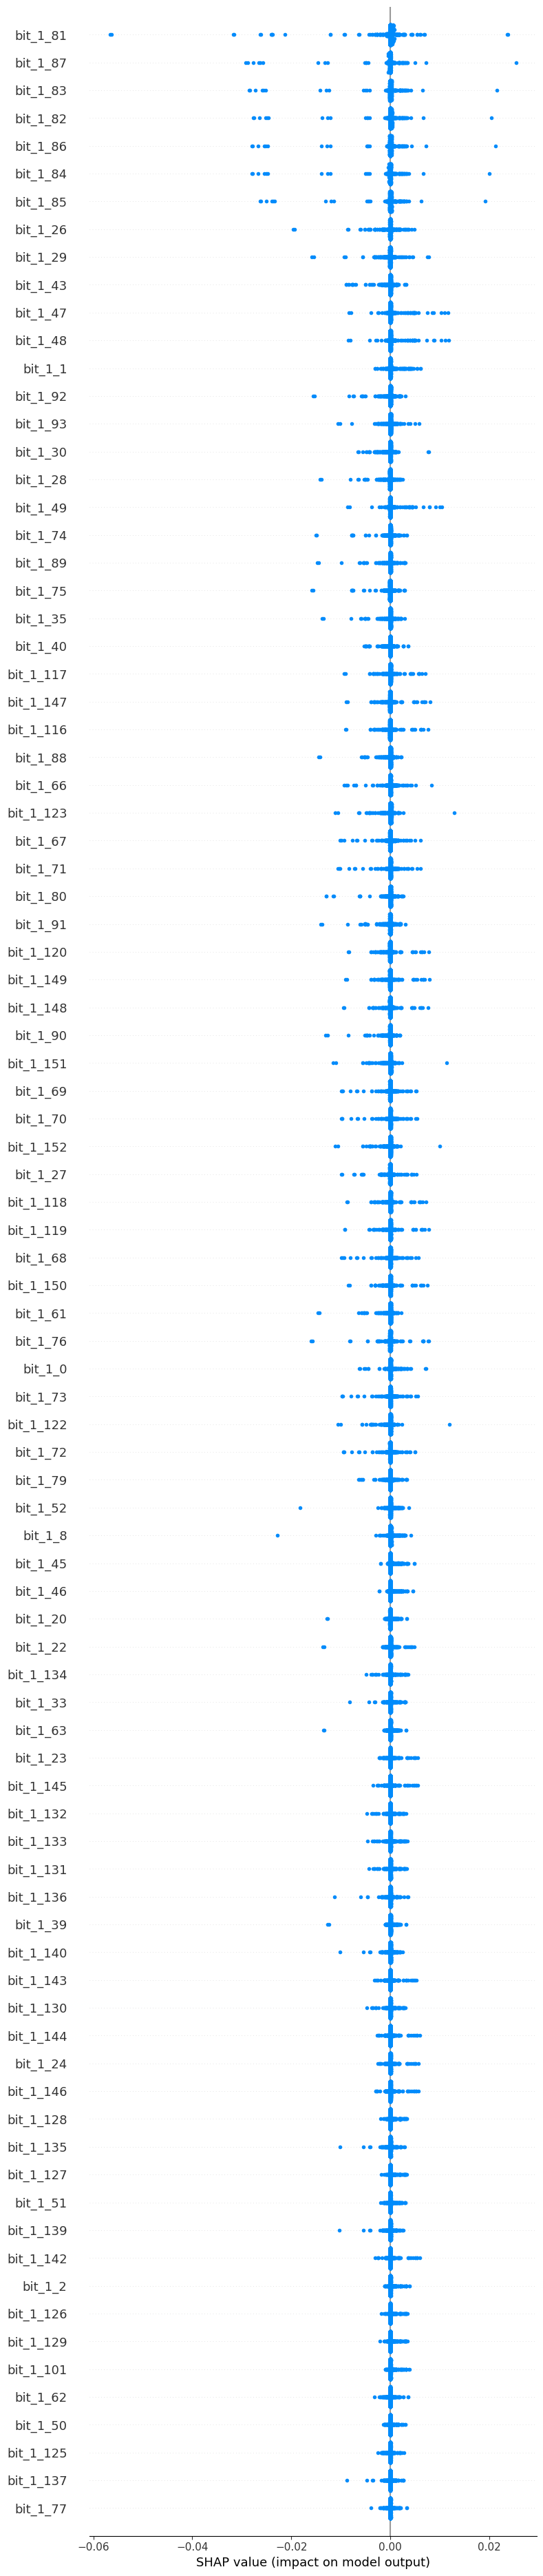

In [ ]:
shap.summary_plot(
    shap_values_matrix, feature_names=dataset.columns, max_display=90
)

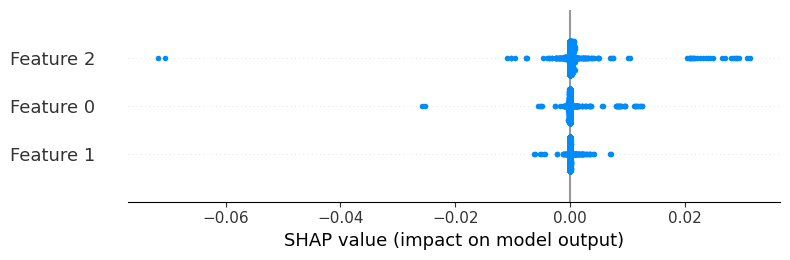

In [ ]:
shap.summary_plot(
    shap_values[0, :]
)  # , X_shap , feature_names = X_shap.columns.values, max_display=15, plot_type='violin')#[1][divided_colors['blue']])#, X_shap.loc[divided_colors['blue']].values, feature_names = X_shap.columns.values, max_display=15, plot_type='violin')

In [ ]:
selected_features = [
    f"bit_2_{i}" for i in descriptor_names
]  # replace these with your actual feature names

# Find the indices of these features
selected_indices = [
    list(dataset.columns).index(feature) for feature in selected_features
]

In [ ]:
dataset.iloc[divided_colors['green'], selected_indices]

bit_2_dipole  bit_2_molar_mass  bit_2_molar_volume  \
24      0.228211          0.112564            0.079146   
25      0.473627          0.098906            0.072080   
26      0.614986          0.617665            0.525954   
65      0.473627          0.098906            0.072080   
84      0.473627          0.098906            0.072080   
85      0.473627          0.098906            0.072080   
86      0.473627          0.098906            0.072080   
87      0.473627          0.098906            0.072080   

    bit_2_electronic_spatial_extent  bit_2_homo_energy  bit_2_lumo_energy  \
24                         0.016848           0.487466           0.936796   
25                         0.014873           0.000000           0.211213   
26                         0.483694           0.756763           0.991360   
65                         0.014873           0.000000           0.211213   
84                         0.014873           0.000000           0.211213   
85                         0.014873           0.000000           0.211213   
86                         0.014873           0.000000           0.211213   
87                         0.014873           0.000000           0.211213   

    bit_2_electronegativity  bit_2_hardness  bit_2_ES_root_dipole  \
24                 0.151573        0.837011              0.572174   
25                 0.953725        0.386150              0.595102   
26                 0.013659        0.797574              0.835903   
65                 0.953725        0.386150              0.595102   
84                 0.953725        0.386150              0.595102   
85                 0.953725        0.386150              0.595102   
86                 0.953725        0.386150              0.595102   
87                 0.953725        0.386150              0.595102   

    bit_2_ES_root_molar_volume  ...  bit_2_ES_osc_strength_1  \
24                    0.109040  ...                 0.041506   
25                    0.138092  ...                 0.196911   
26                    0.822258  ...                 0.009331   
65                    0.138092  ...                 0.196911   
84                    0.138092  ...                 0.196911   
85                    0.138092  ...                 0.196911   
86                    0.138092  ...                 0.196911   
87                    0.138092  ...                 0.196911   

    bit_2_ES_osc_strength_2  bit_2_ES_osc_strength_3  bit_2_ES_osc_strength_4  \
24                 0.000556                 0.792381                 0.261816   
25                 1.000000                 0.000000                 0.001062   
26                 0.000556                 0.859683                 0.539565   
65                 1.000000                 0.000000                 0.001062   
84                 1.000000                 0.000000                 0.001062   
85                 1.000000                 0.000000                 0.001062   
86                 1.000000                 0.000000                 0.001062   
87                 1.000000                 0.000000                 0.001062   

    bit_2_ES_osc_strength_5  bit_2_ES_osc_strength_6  bit_2_ES_osc_strength_7  \
24                 0.028060                 0.007842                 0.052997   
25                 0.002455                 0.000000                 0.189234   
26                 0.005612                 0.001758                 0.014428   
65                 0.002455                 0.000000                 0.189234   
84                 0.002455                 0.000000                 0.189234   
85                 0.002455                 0.000000                 0.189234   
86                 0.002455                 0.000000                 0.189234   
87                 0.002455                 0.000000                 0.189234   

    bit_2_ES_osc_strength_8  bit_2_ES_osc_strength_9  bit_2_ES_osc_strength_10  
24                 0.167902                 0.0